# My Movie Database (MMDb)

## Structure

- Sources
    - Trakt : Track what you watch and when
    - OMDb : Open Movie Database
    - IMDb : Internet Movie Database 
    
- Merge OMDb data with IMDb data based on Trakt's watched movies history

## Inputs

- Merged dataset : pickle
- Trakt : only by connection with API
- OMDb  : txt or connection with API
- IMDb  : txt or connection with API

## Outputs

- OMDb request result : txt
- IMDb request result : txt
- Merged dataset : pickle

---

# Hard settings

In [1]:
## OPTIONAL
# Get data
get_data = False

# Force api requests and get all data
force_request = False
#if force_request:
#    get_data = True

# Check data before analysis
data_check = False

# Export data
export = False
# Export data to pickle file
export_pickle = False
if export_pickle:
    export = True

In [2]:
## DON'T CHANGE
# Load Files
load_pickle = False
load_omdb = False
load_imdb = False

# Imports

In [3]:
# https://stackoverflow.com/questions/66920753/running-a-justpy-web-app-on-jupyter-returns-runtimeerror
import nest_asyncio
nest_asyncio.apply()

import os
import time

# Import functions
#https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
%run MMDb_functions.ipynb

In [4]:
path = os.getcwd()
src_path = path + '\\Desktop\\Data Analysis\\'

# Load Files

## Pickle file

In [5]:
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure. 
# “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, 
# whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
pkl_file = 'movies.pkl'
pkl_path = src_path + pkl_file

try:
    foo = pickle.load(open(pkl_path, "rb"))
except (OSError, IOError) as e:
    foo = 3
    #pickle.dump(foo, open(pkl_path, "wb"))
    
if isinstance(foo, pd.core.frame.DataFrame):
    load_pickle = True
    
    foo.sort_values(by='Timestamp', inplace=True)
    foo = foo.reset_index(drop=True)

    foo.info()
else:
    print('No pickle.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            903 non-null    object        
 1   Year             903 non-null    int32         
 2   imdbID           903 non-null    object        
 3   Rated            903 non-null    object        
 4   Runtime          903 non-null    int32         
 5   Genre            903 non-null    object        
 6   Director         903 non-null    object        
 7   Writer           903 non-null    object        
 8   Cinematographer  903 non-null    object        
 9   Actors           903 non-null    object        
 10  Plot             903 non-null    object        
 11  Language         903 non-null    object        
 12  Country          903 non-null    object        
 13  Metascore        903 non-null    int32         
 14  imdbRating       903 non-null    float64  

## Trakt

In [6]:
## Movies watched multiple times (between 2020 and 2022)
# Jojo Rabbit
# Dune (2021)
# The Trip
# Heavy Trip

# Method 'last_watched_movies" only gets last result

In [7]:
if get_data or force_request:
    # Initialize Trakt class
    trakt = TRAKT()
    
    from_date = '2018-01-01' # foo.Date.dt.date.max()
    # Create trakt dataframe
    df_trakt = trakt.create_df(start_date = from_date)    
    df_trakt.info()
    
    # Last movies added
    show_all(df_trakt.tail())

### New movies watched?

In [8]:
# PICKLE VS TRAKT
if get_data:
    data = []

    # Check if size is different (new movies watched)
    _, newMovies = check_new_movies(foo, df_trakt)

    if isinstance(foo, pd.core.frame.DataFrame) and newMovies > 0:
        # Pickle file exists
        # Get new movies
        data = df_trakt.sort_values(by='timestamp').iloc[-newMovies:,:].reset_index(drop=True)
        show_all(data)
        
        ## Reset df_trakt
        #df_trakt = df_trakt.iloc[-newMovies:,:].reset_index(drop=True)
        print('New Movies: ', newMovies)
        
    else:
        if force_request:
            print('Forcing request...')
        else:
            print('Get data mode.')
            
        # Select data to search in OMDb
        data = df_trakt.copy() #[['title','id']]        
        
else:
    newMovies = 0
    print('Do nothing.') 

Do nothing.


## OMDb

In [9]:
# Initialize OMDB class
omdb = OMDB()

In [10]:
if newMovies > 0 or not get_data:
    load_omdb = True
    
    try:
        omdb_file = 'omdb.txt'
        omdb_path = src_path + omdb_file
        
        df_omdb = omdb.load(omdb_path)
        ## Clean dataframe
        df_omdb = omdb.convert_columns(df_omdb)
        df_omdb.columns = [x.lower() for x in df_omdb.columns]

        df_omdb.info()
        
    except (OSError, IOError) as e:
        df_omdb = 3
else:
    df_omdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       903 non-null    object        
 1   year        903 non-null    int64         
 2   rated       903 non-null    object        
 3   released    903 non-null    object        
 4   runtime     903 non-null    int32         
 5   genre       903 non-null    object        
 6   director    903 non-null    object        
 7   writer      878 non-null    object        
 8   actors      902 non-null    object        
 9   plot        903 non-null    object        
 10  language    901 non-null    object        
 11  country     903 non-null    object        
 12  awards      855 non-null    object        
 13  poster      903 non-null    object        
 14  ratings     903 non-null    object        
 15  metascore   903 non-null    int32         
 16  imdbrating  900 non-null  

### Connect with OMDb

In [11]:
# Get new movies
if load_omdb or force_request:
    
    # Here newMovies is the diffence between foo and trakt  
    if (isinstance(df_omdb, pd.core.frame.DataFrame) and newMovies > 0):
        # Check difference
        _, newMovies = check_new_movies(df_omdb, df_trakt)
        
        # Here newMovies is the diffence between omdb and trakt  
        if newMovies != 0:
            print('Adding new movies to df... \n')
            df_omdb = look_iama_pickle(df_omdb, df_trakt, 'omdb') 
    
            # Get all columns
            all_cols = df_omdb.columns
        else:
            print('Leave OMDb alone!')
       
    else:
        if isinstance(df_omdb, pd.core.frame.DataFrame): # in case omdb file exist but don't want to retrieve new data
            pass
        elif isinstance(df_omdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')
            ## Copy foo if pickle exists and there's no new movies
            df_omdb = look_iama_pickle(foo, df_trakt, 'omdb', force_request)

            # Extract these columns
            all_cols = df_omdb.iloc[:,:-10].columns # from 'title' to 'time'
        else:
            print('Leave OMDb alone!')
    
    df_omdb.reset_index(drop=True, inplace=True)

#### Check for errors

In [12]:
# Bad movie info
if load_omdb:
    if 'error' in df_omdb.columns:
        print('Errors: ', len(df_omdb[df_omdb['error'].notnull()]))
        
        # analyze query errors
        errorlist= df_omdb[~df_omdb['error'].isna()].index
        show_all(df_trakt.iloc[errorlist])
    else:
        print('No errors.')

No errors.


#### Select data

In [13]:
# Filter columns for view
omdb_cols = ['title','year','runtime','genre','director','metascore','imdbrating','timestamp']

In [14]:
if load_omdb:
    # Force organize by date watched
    df_omdb_last = df_omdb.loc[:, omdb_cols]
    
    # Check last entries
    N = 10
    remove_view = ['actors','plot']
    show_all(df_omdb_last.tail(N))

#### Clean dataset

In [15]:
if load_omdb:
    ## Clean dataframe
    df_omdb = omdb.convert_columns(df_omdb)
    
    ### Drop duplicates just in case - such as Jojo Rabbit and Dune
    #df_omdb.drop_duplicates(['title','year','date'], keep='first', inplace=True)

## IMDb

In [16]:
# Initialize IMDB class and import imdb file
imdb = IMDB()

In [17]:
# newMovies may be set to 0 when omdb compares to trakt but we need to load imdb.txt if pickle is missing
if newMovies > 0 or not get_data:
    load_imdb = True
    
    try:
        imdb_file = 'imdb.txt'
        imdb_path = src_path + imdb_file
        df_imdb = imdb.load(imdb_path)
               
        # Clean imdb df
        df_imdb = imdb.convert_columns(df_imdb)
        df_imdb.columns = [x.lower() for x in df_imdb.columns]
        
        df_imdb.info()
        
    except (OSError, IOError) as e:
        df_imdb = 3
else:
    df_imdb = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 903 non-null    object        
 1   year                  903 non-null    int32         
 2   imdbid                903 non-null    object        
 3   runtimes              903 non-null    int32         
 4   genres                903 non-null    object        
 5   director              903 non-null    object        
 6   writer                903 non-null    object        
 7   cinematographer       903 non-null    object        
 8   cast                  903 non-null    object        
 9   countries             903 non-null    object        
 10  languages             903 non-null    object        
 11  rating                903 non-null    float64       
 12  votes                 903 non-null    int32         
 13  plot outline        

### Connect with IMDb

In [18]:
# Get new movies
if load_imdb or force_request:
    
    if (isinstance(df_imdb, pd.core.frame.DataFrame) and newMovies > 0):
        # Here newMovies is the diffence between imdb and trakt  
        _, newMovies = check_new_movies(df_imdb, df_trakt)

        print('Adding new movies to df... \n')
        df_imdb = look_iama_pickle(df_imdb, df_trakt, 'imdb', force_request)
    
    else:   
        if isinstance(df_imdb, pd.core.frame.DataFrame): # in case imdb file exist but don't want to retrieve new data
            pass
        if isinstance(df_imdb, int) or force_request: # no pickle saved OR force db request (all movies)
            print('Get all data. \n')   
            df_imdb = look_iama_pickle(foo, df_trakt, 'imdb', force_request)
        else:
            print('Leave IMDb alone!')
            
    if get_data:
        df_imdb['imdbid'] = df_trakt['id']
    else:
        pass

Leave IMDb alone!


#### Select data

In [19]:
# Filter columns for view
imdb_cols = ['title','year','runtimes','genres','director','rating','timestamp']

In [20]:
if load_imdb:
    # Force organize by date watched
    df_imdb_last = df_imdb.loc[:, imdb_cols]
    
    # Check last entries
    N = 10
    show_all(df_imdb_last.tail(N))

#### Clean dataset

In [21]:
if load_imdb:
    #df_imdb = imdb.clean_df(df_imdb)
    df_imdb = imdb.convert_columns(df_imdb)

---

# Merge DataFrames (OMDb & IMDb)

In [22]:
# If pickle exist and don't want more data, work with pickle
if load_pickle and not get_data:
    print('Get pickle.')
    df = foo.copy()

# If more new movies (get_data is on) OR no new movies but pickle don't exist - do the merge
else:   
    # Work with this df
    df = merge_dfs(df_omdb, df_imdb)
    
# Check data merging result
df.info()

Get pickle.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            903 non-null    object        
 1   Year             903 non-null    int32         
 2   imdbID           903 non-null    object        
 3   Rated            903 non-null    object        
 4   Runtime          903 non-null    int32         
 5   Genre            903 non-null    object        
 6   Director         903 non-null    object        
 7   Writer           903 non-null    object        
 8   Cinematographer  903 non-null    object        
 9   Actors           903 non-null    object        
 10  Plot             903 non-null    object        
 11  Language         903 non-null    object        
 12  Country          903 non-null    object        
 13  Metascore        903 non-null    int32         
 14  imdbRating       903 non-null 

In [23]:
# Last data from merged df
df.tail(3)

Title  Year    imdbID Rated  Runtime  \
900   They Live  1988   0096256     R       94   
901  The Hidden  1987   0093185     R       97   
902  Studio 666  2022  15374070     R      106   

                                Genre        Director  \
900  Action, Horror, Sci-Fi, Thriller  John Carpenter   
901          Horror, Sci-Fi, Thriller    Jack Sholder   
902             Comedy, Horror, Music    BJ McDonnell   

                                      Writer                 Cinematographer  \
900               John Carpenter, Ray Nelson                   Gary B. Kibbe   
901                                 Jim Kouf                 Jacques Haitkin   
902  Dave Grohl, Jeff Buhler, Rebecca Hughes  Michael Dallatorre, Eric Leach   

                                                Actors  \
900  Roddy Piper, Keith David, Meg Foster, George '...   
901  Kyle MacLachlan, Michael Nouri, Claudia Christ...   
902  Dave Grohl, Nate Mendel, Pat Smear, Taylor Haw...   

                                                  Plot Language  \
900  They influence our decisions without us knowin...  English   
901  A cop and an FBI agent race for answers after ...  English   
902  Legendary rock band Foo Fighters move into an ...  English   

           Country  Metascore  imdbRating  imdbVotes  \
900  United States         55         7.2     125131   
901  United States         69         7.0      18877   
902  United States         49         5.8       3239   

                                            Production           Timestamp  \
900              Alive Films, Larry Franco Productions 2022-03-21 22:01:45   
901  New Line Cinema, Heron Communications, Mega En... 2022-03-21 23:49:07   
902                     Roswell Films, Therapy Studios 2022-03-22 23:36:23   

          Date      Time  
900 2022-03-21  22:01:45  
901 2022-03-21  23:49:07  
902 2022-03-22  23:36:23

---

In [24]:
if data_check:
    input("Press Enter to continue...")
else:
    pass

---

# Export data

In [25]:
# Setup to export OMDb data (and therefore import - pickle file) and IMDb data
if export:
    ## Export pickle
    if export_pickle:
        df.to_pickle(pkl_path)
        
    ## Export omdb file
    omdb_file_export = 'omdb.txt'
    omdb_path_export = src_path + omdb_file_export
    df_omdb.to_csv(omdb_path_export, encoding='utf-8', index=False)  

    ## Export imdb file
    imdb_file_export = 'imdb.txt'
    imdb_path_export = src_path + imdb_file_export        
    df_imdb.to_csv(imdb_path_export, encoding='utf-8', index=False)       
else:
    pass

---

# Analysis

In [26]:
# Set plot style
plt.style.use('fivethirtyeight')

# Work with top 10
N = 10

In [27]:
# Any shorts?
short_cols = ['Title','Year','Runtime','Genre','Director']

## Show movies with less than 60 minute still in the dataset
#show_all(df[df.Runtime < 60].sort_values(by=['Runtime'])[short_cols])

# Show 'short' genre movies
show_all(df[df['Genre'].str.contains("Short")][short_cols])

# Remove 'short' genre from the df
shorts = df[df['Genre'].str.contains("Short")]

print('There are ' + str(len(shorts)) + ' shorts in the dataset.')
df = df[~df['Genre'].str.contains("Short")]

There are 9 shorts in the dataset.


In [28]:
# Show df after filtering
df.shape

(894, 20)

In [29]:
# Describe df (only object columns)
df[df.columns.difference(['Title', 'Actors', 'Plot', 'imdbID'])].describe(include=['object'])

Cinematographer        Country     Director  Genre Language Production  \
count              894            894          894    894      894        894   
unique             590            232          667    346      254        869   
top                N/A  United States  David Lynch  Drama  English        N/A   
freq                19            357           10     64      416          7   

       Rated      Time Writer  
count    894       894    894  
unique    17       857    799  
top        R  23:00:00    N/A  
freq     411         3     25

In [30]:
## Duplicated movies in the dataset (rewatched movies within date range)
#df[df[['Title','Year','Runtime']].duplicated(keep=False)][['Title','Year','Director','imdbRating','Timestamp']]

## Show entire DataFrame

In [31]:
data_check = False
if data_check:
    cols = ['Title','Year','Runtime','Genre','Director','Actors','Plot','Date']
    display(HTML(df[cols].sort_values('Date', ascending=False).to_html()))
else:
    pass

---

## Overview

In [32]:
# Get actual date
now = pd.Timestamp('now')
current_year = now.year

# Get list of years (originally from timestamp of date viewed - starts in 2020)
years = list(df.Date.dt.year.unique())
years.sort()

In [33]:
# All (movies and documentaries) watched by year
df_diff_watched_year, df_all_watched = totals_by_year(df, True, True)
df_all_watched.style.background_gradient(subset=[('Title','count')], axis=0)

In [34]:
# Movies (only) by year
df_movies_year, df_show_movies = totals_by_year(df, docs=False)

# Difference from previous year of movies watched
df_show_movies['Diff'] = df_movies_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_movies.style.background_gradient(cmap='RdBu', subset='Diff')

In [35]:
# Documentaries (only) by year
df_docs_year, df_show_docs = totals_by_year(df, docs=True)

# Difference from previous year of documentaries watched
df_show_docs['Diff'] = df_docs_year.diff().drop('Genre', axis=1).fillna(0).astype(int)

df_show_docs.style.background_gradient(cmap='RdBu', subset='Diff')

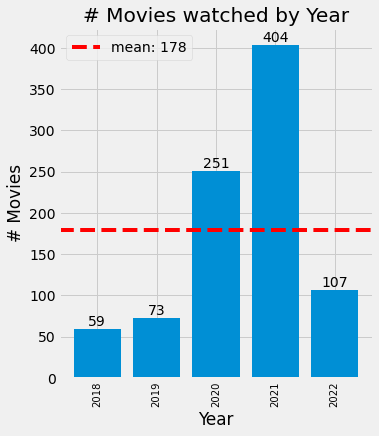

In [36]:
# Plot all watched by year
x = df_all_watched.index
y = df_all_watched[('Title','count')]

_, ax = plt.subplots(figsize=(len(x),6))
add_ticks_vbarplot(x, y, ax)     

plt.title('# Movies watched by Year')
plt.xlabel('Year')
plt.ylabel('# Movies')

label = 'mean: ' + str(int(y.mean())) # set label to print mean value
ax.axhline(y=y.mean(), color='red', ls='--', label=label)

plt.legend()
plt.show()

In [37]:
# Percentage difference from previous year
pct_col = 'pct (%)'

df_year_change = df_diff_watched_year.copy()
df_year_change = df_year_change.diff().fillna(0).astype(int)

df_year_change[pct_col] = pd.DataFrame(df_all_watched.pct_change()[('Title','count')]*100)
df_year_change[pct_col] = df_year_change[pct_col].fillna(0).astype(int)
df_year_change.drop(['Genre','Title'], axis=1, inplace=True)

df_year_change.style.background_gradient(cmap='RdBu', subset=pct_col, axis=0)

In [38]:
# Difference between years

# Get values from all movies watched
values = list(df_all_watched.iloc[:,-1])
# List difference between years
l = [i-j for i in values for j in values if i != j]
# Initialize 
results = []
j = 0

# Fill list 
for i in range(len(years)):
    temp_list = l[j:j+4] # get 4 values each time (doesn't contain difference between itself)
    temp_list.insert(i,0) # insert difference between the value itself =0
    results.append(temp_list) # append to list
    j += 4 # add step 

# Convert to dataframe
df_year_heatmap = pd.DataFrame(results, index=years, columns=years)
df_year_heatmap.style.background_gradient(cmap='RdBu', axis=None)

In [39]:
# All (movies + documentaries) watched per day in year
[
    [
        movies_per_day(df_diff_watched_year, year)
    ] for year in years
];

0.16 movies per day in 2018
0.2 movies per day in 2019
0.69 movies per day in 2020
1.11 movies per day in 2021
1.3 movies per day in 2022


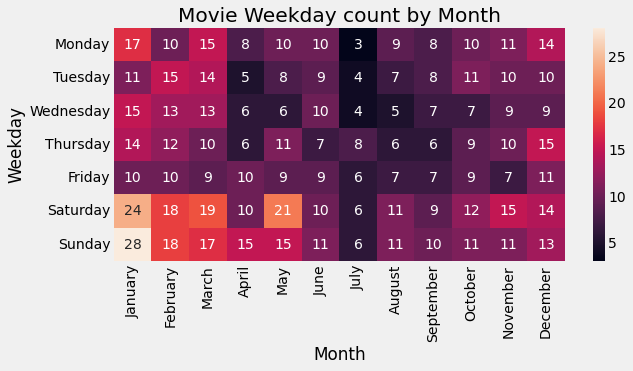

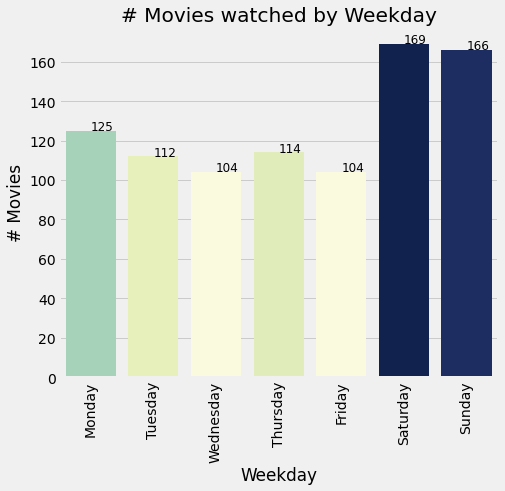

37% of the movies were watched on the weekend!


In [40]:
# Overview
plot_heatmap(df, 'Weekday', None)
plot_weekday_bar(df, None)

## Top IMDb 250 Movies

In [41]:
# Get list of IMDb top 250 movies
moviedb = IMDb()

top250 = moviedb.get_top250_movies()
# Top 250 movies dataframe
df_top250 = pd.DataFrame([[movie.get('title'), movie.get('year')] for movie in top250], columns=['Title','Year'])
# Merge to get top 250 movies seen since the beginning of data get
df_top250_seen = df[['Title','Year','Timestamp']].merge(df_top250, on=['Title', 'Year'])

# Total IMDb top 250 movies watched since 'year'
print('Total IMDb top 250 movies watched since ' + str(years[0]) + ': ' + str(df_top250_seen.shape[0]))

Total IMDb top 250 movies watched since 2018: 71


In [42]:
df_top250_seen['DateYear'] = df_top250_seen['Timestamp'].dt.year
gb_top250_seen = df_top250_seen.groupby('DateYear').agg({'Title':['count','; '.join]})

show_all(gb_top250_seen)

## By Year 

In [43]:
# Set by year dataframe
cols = ['Title','Year','Runtime','Genre','Director','imdbRating','Date','Time']

df_byear = df[cols].copy()

In [44]:
# All by month/year
ct_month_year = crosstab_by_year(df_byear).droplevel('Month', axis=1)
ct_month_year.style.background_gradient(axis=1, subset=ct_month_year.columns[:-1]) # evaluate by year

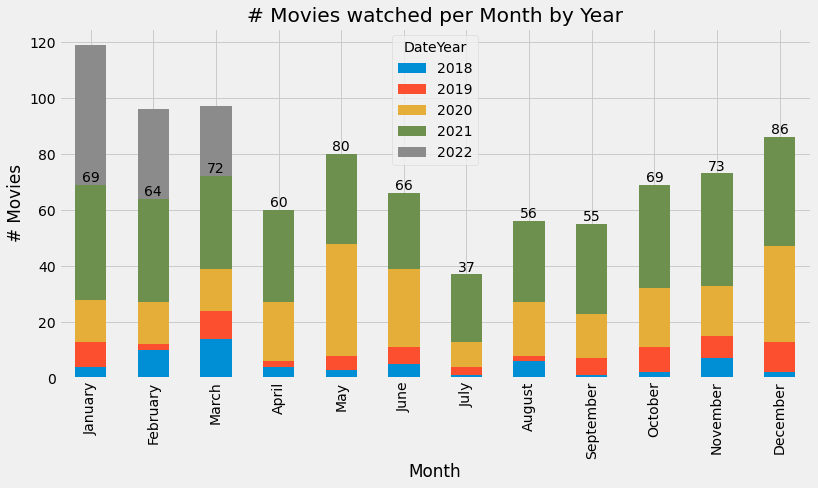

In [45]:
# Plot bar plot of movies watched month by year
plot_mby = crosstab_by_year(df_byear).droplevel('Month', axis=1).drop('', axis=1).T
ax = plot_mby.drop('All', axis=1).plot(kind='bar', stacked=True, figsize=(len(plot_mby),6));

ax.bar_label(ax.containers[len(years)-2])

plt.title('# Movies watched per Month by Year')
plt.xlabel('Month')
plt.ylabel('# Movies')

plt.show()

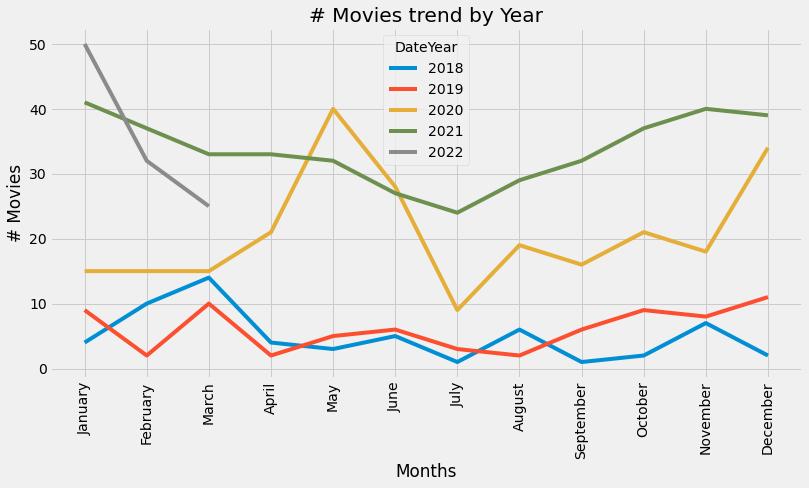

In [46]:
# Plot watched movies trend by year
plot_ty = crosstab_by_year(df_byear).droplevel('Month', axis=1).drop('All').drop('', axis=1).T
plot_ty.iloc[:,-1] = plot_ty.iloc[:,-1].replace(0, np.nan) # replace 0 values to nan values from months yet to come, for figure purposes

# Plot
ax = plot_ty.plot(figsize=(len(plot_ty),6));

ax.xaxis.set_ticks(np.arange(len(plot_ty.index)))
ax.xaxis.set_ticklabels(plot_ty.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('# Movies trend by Year')
plt.xlabel('Months')
plt.ylabel('# Movies')
    
plt.show()

In [47]:
# Difference from previous year (of movies & documentaries watched)
ct_month_year_diff = crosstab_by_year(df_byear).diff().drop('All').fillna(0).astype(int)
ct_month_year_diff = ct_month_year_diff.droplevel('Month', axis=1)
ct_month_year_diff.style.background_gradient(cmap='RdBu', subset=ct_month_year_diff.columns[:-1], axis=None) # evaluate by year

2018 



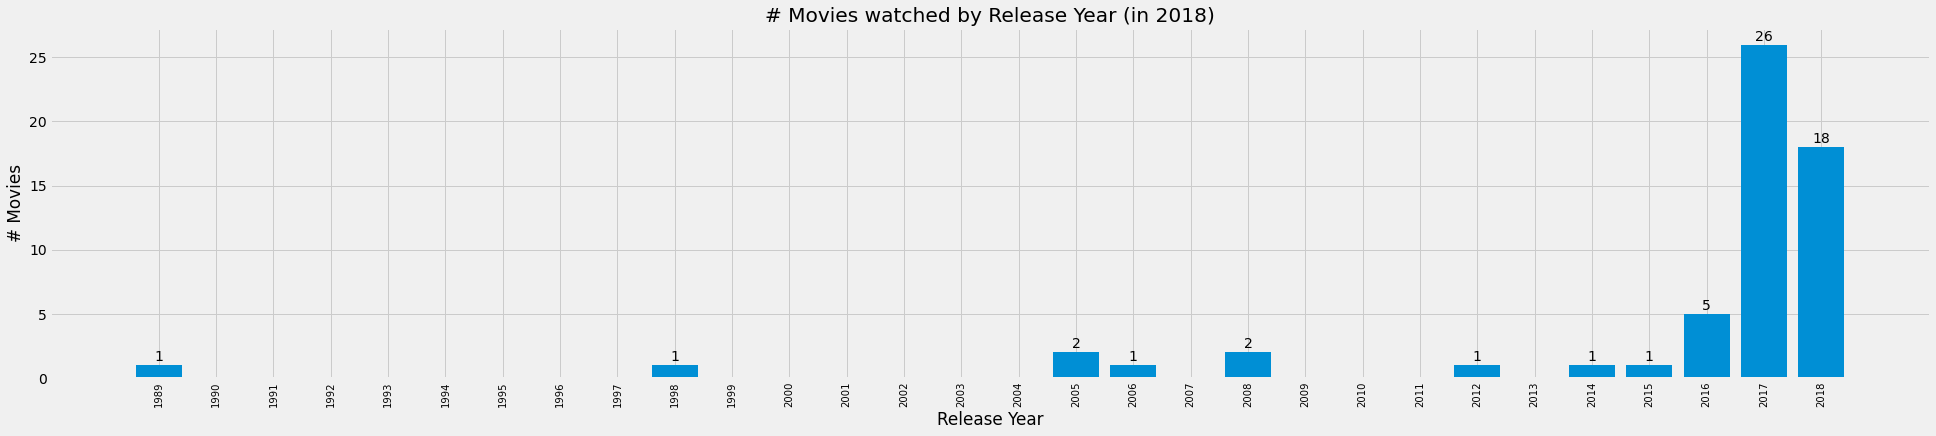

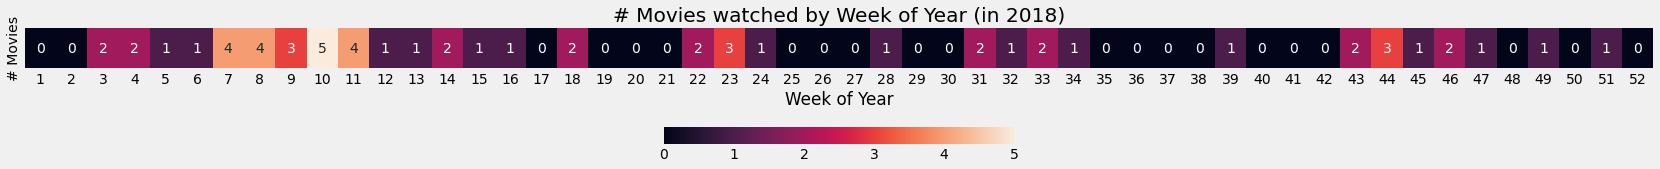

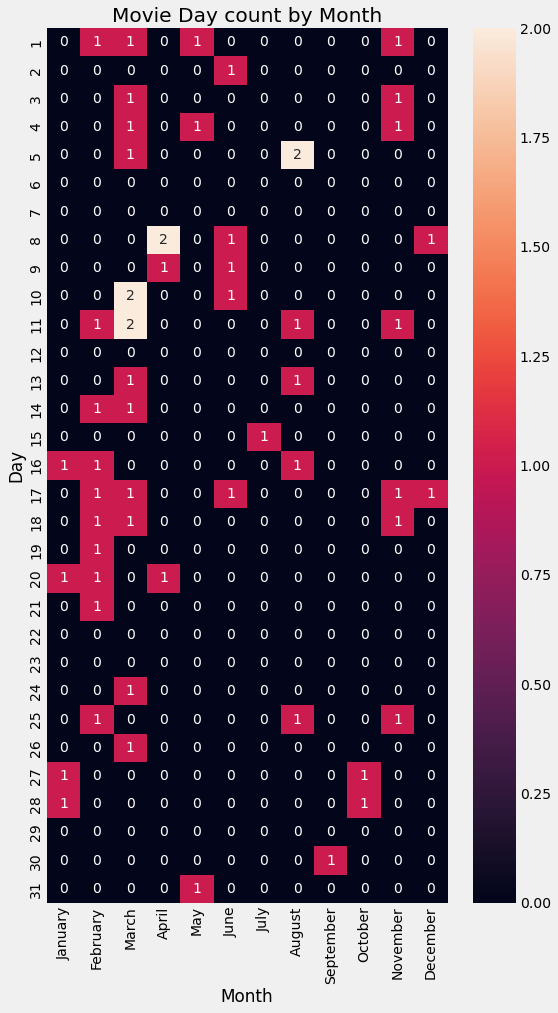

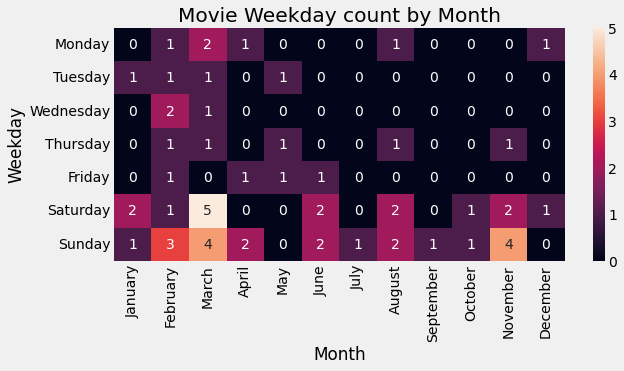

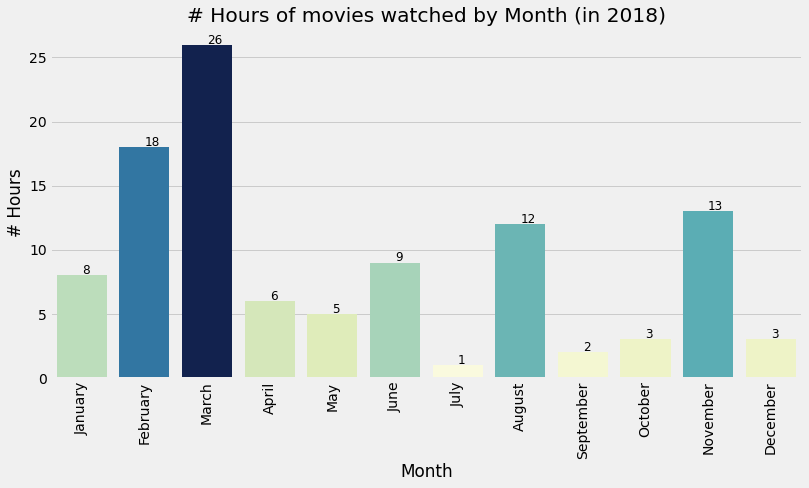

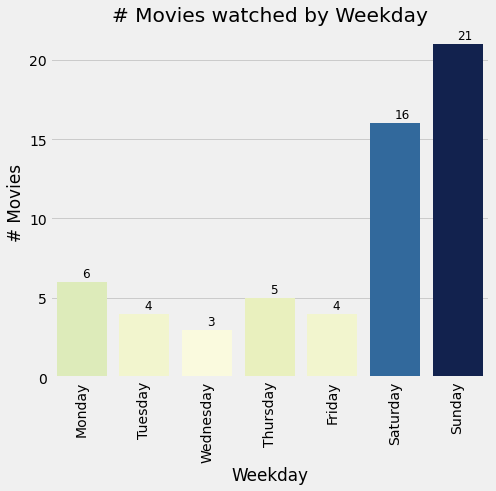

62% of the movies were watched on the weekend!



2019 



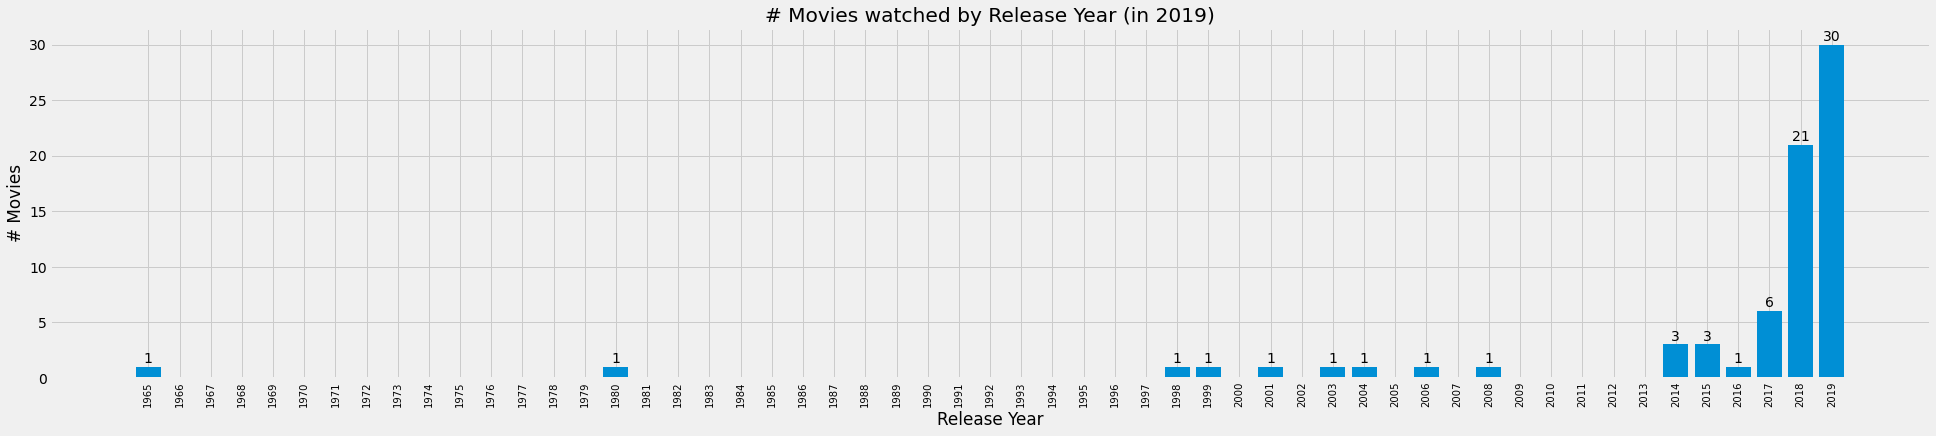

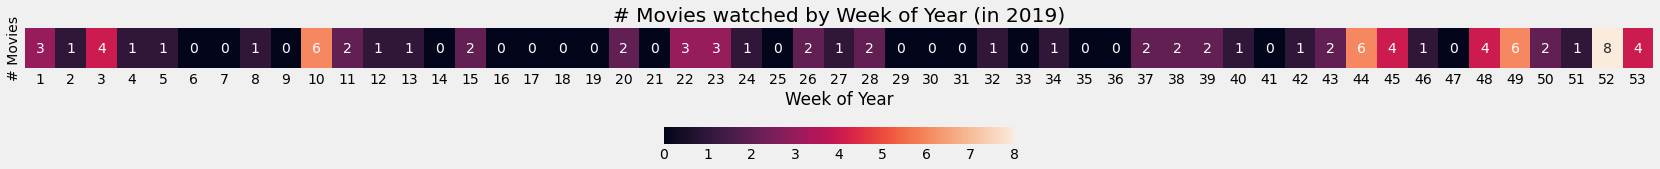

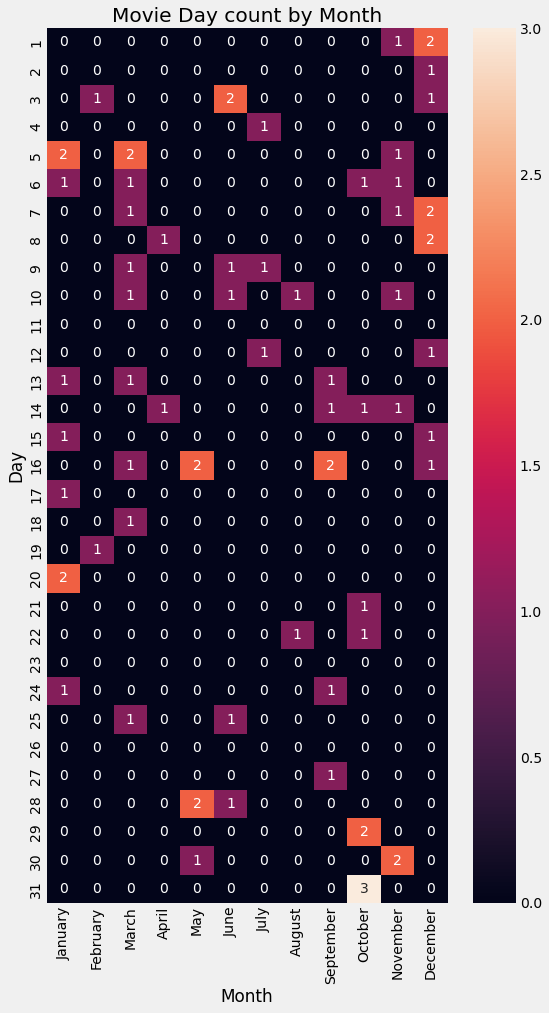

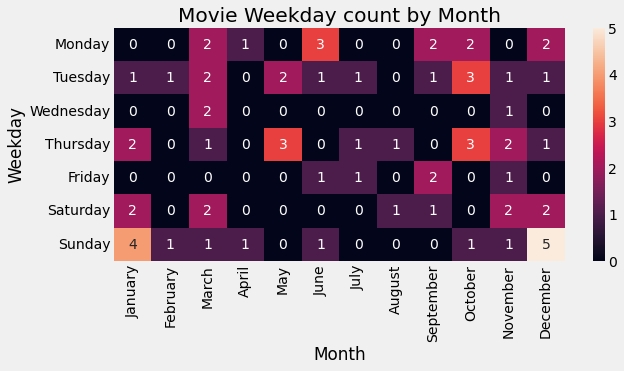

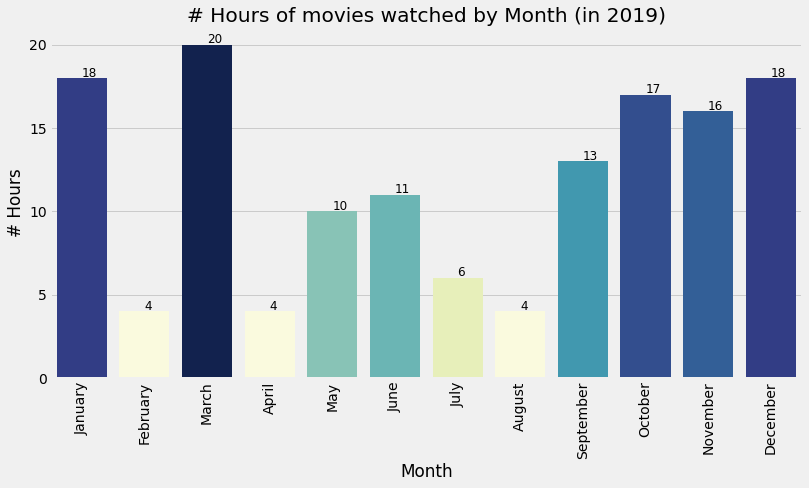

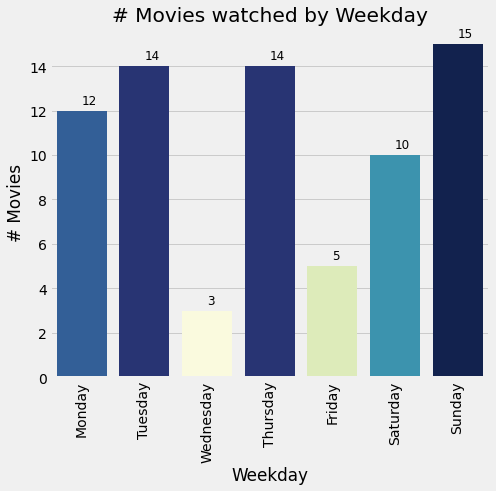

34% of the movies were watched on the weekend!



2020 



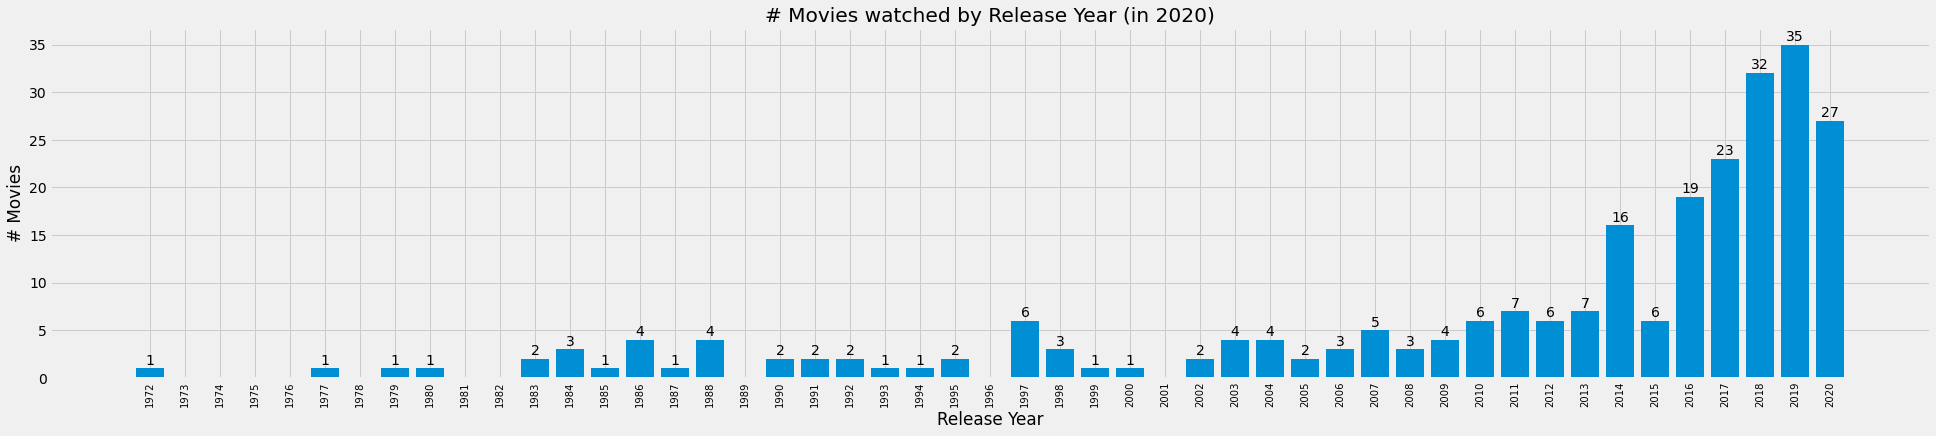

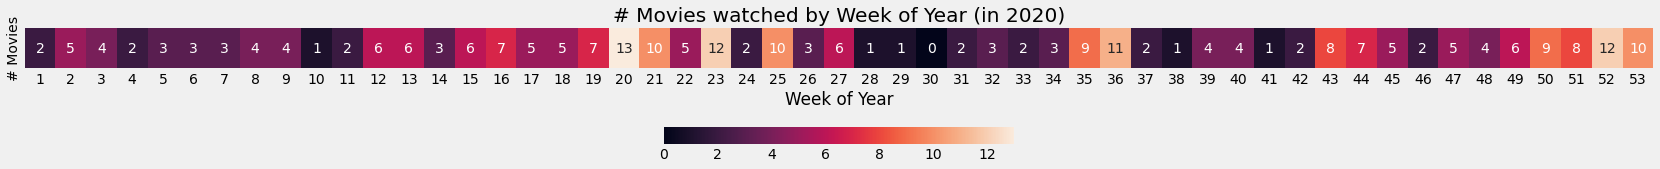

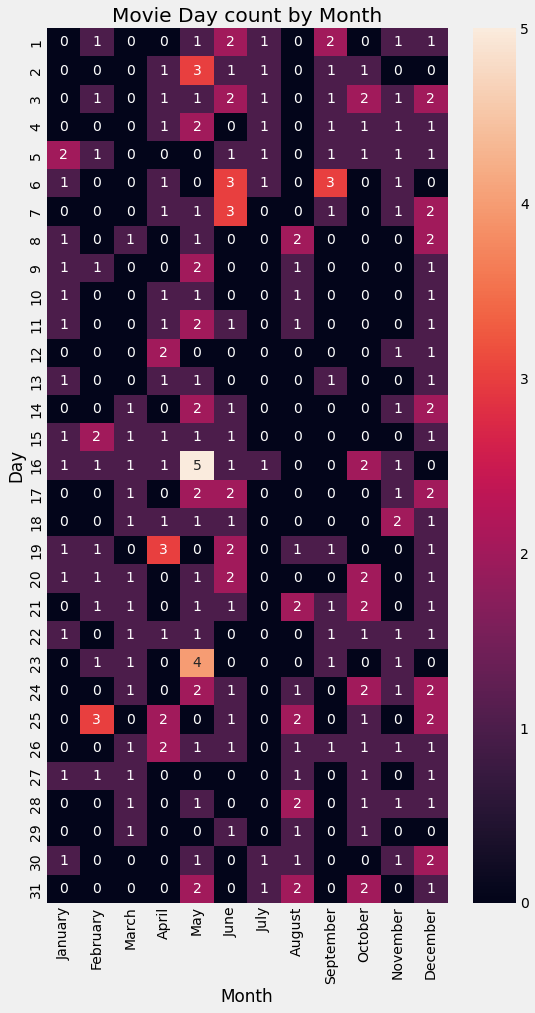

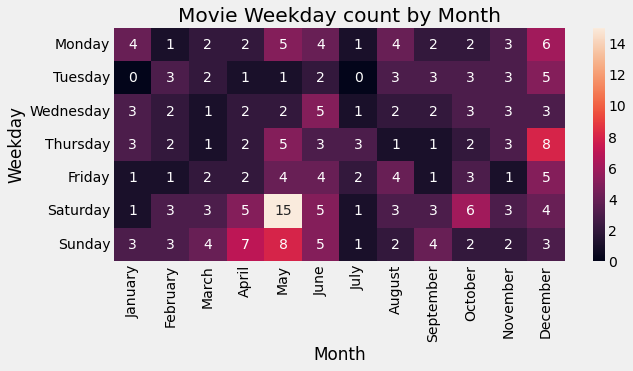

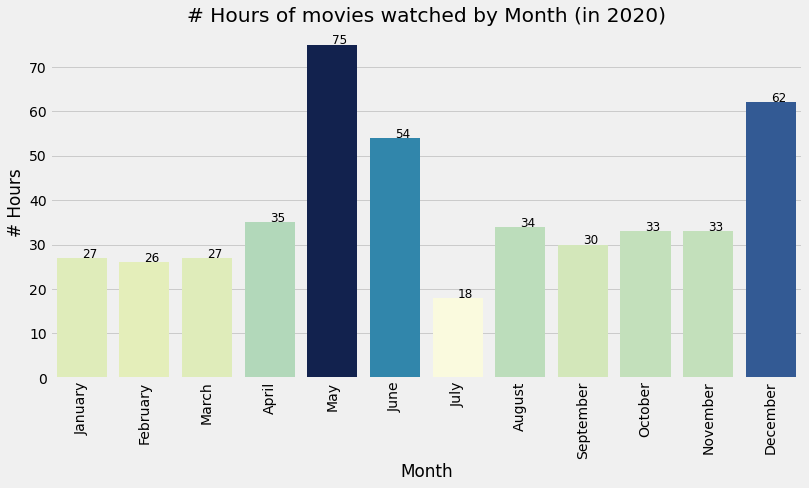

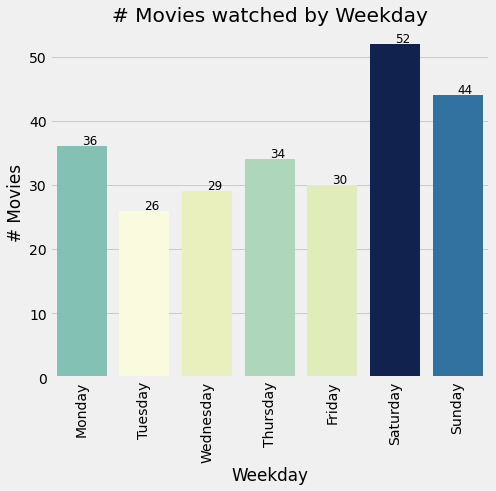

38% of the movies were watched on the weekend!



2021 



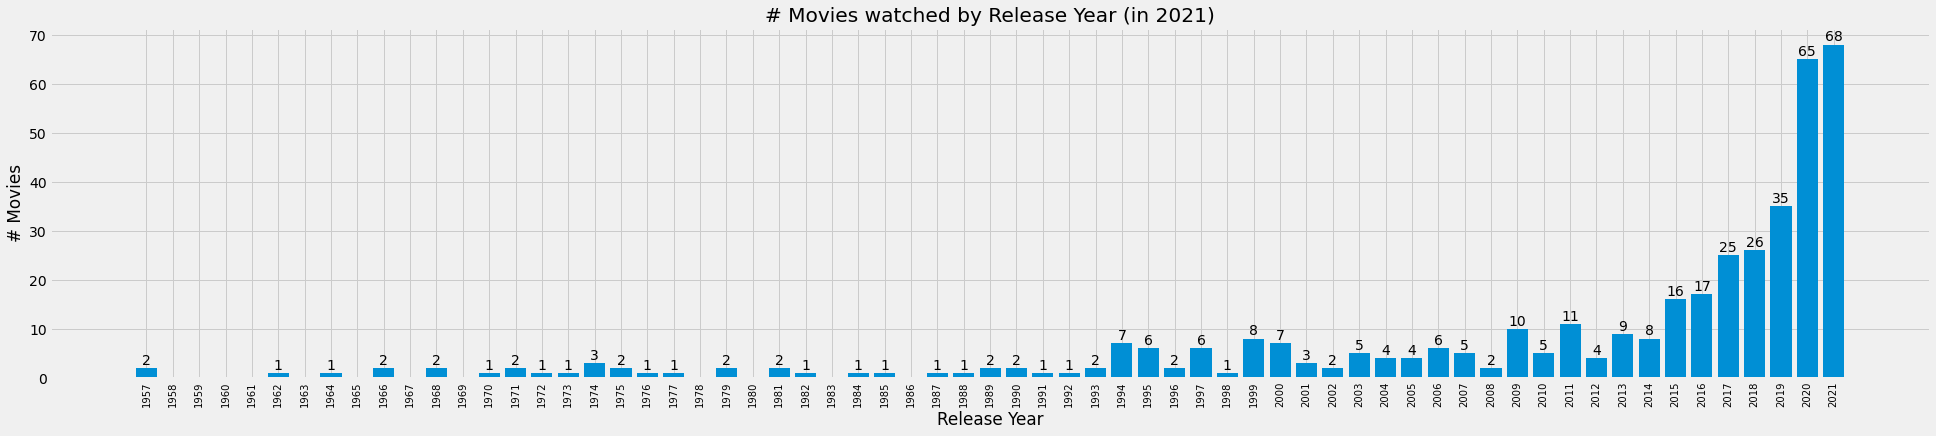

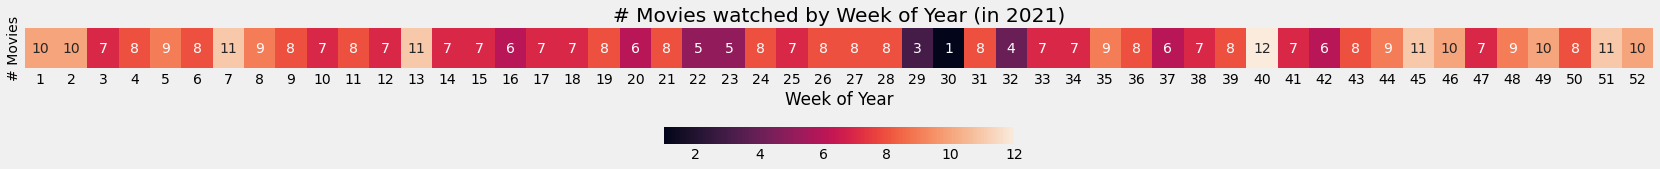

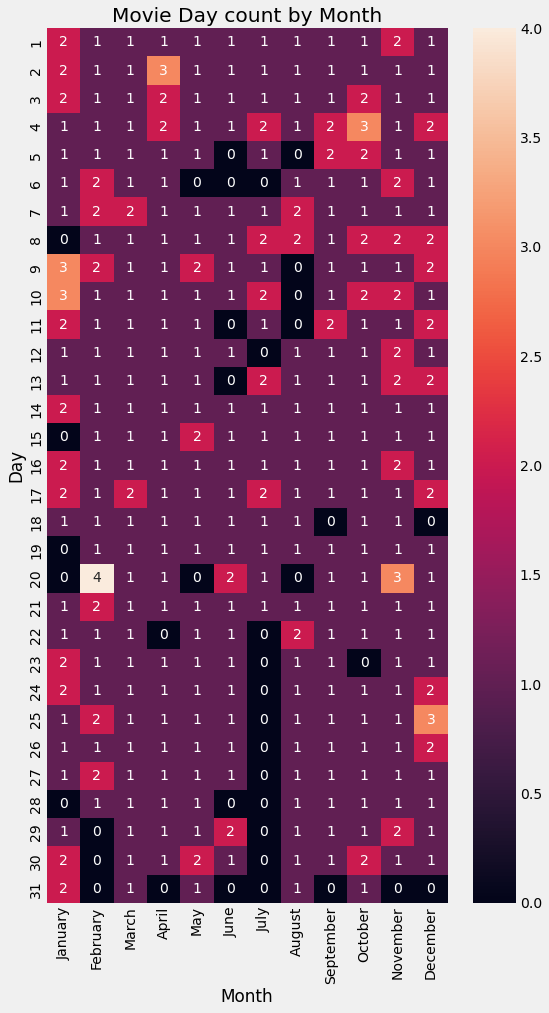

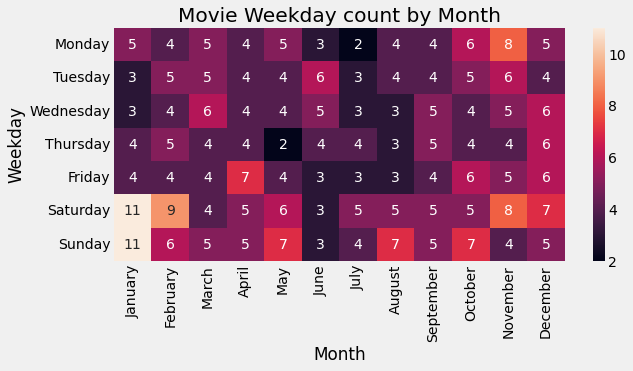

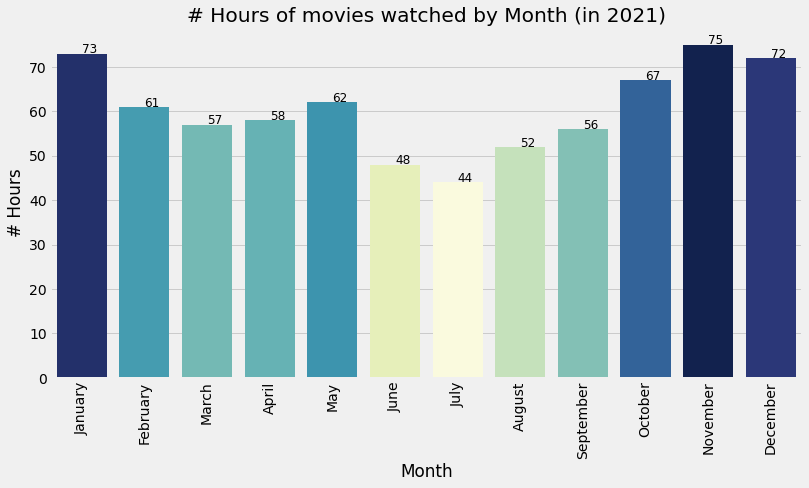

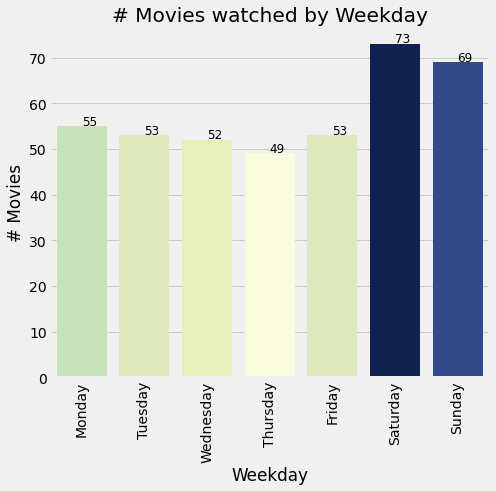

35% of the movies were watched on the weekend!



2022 



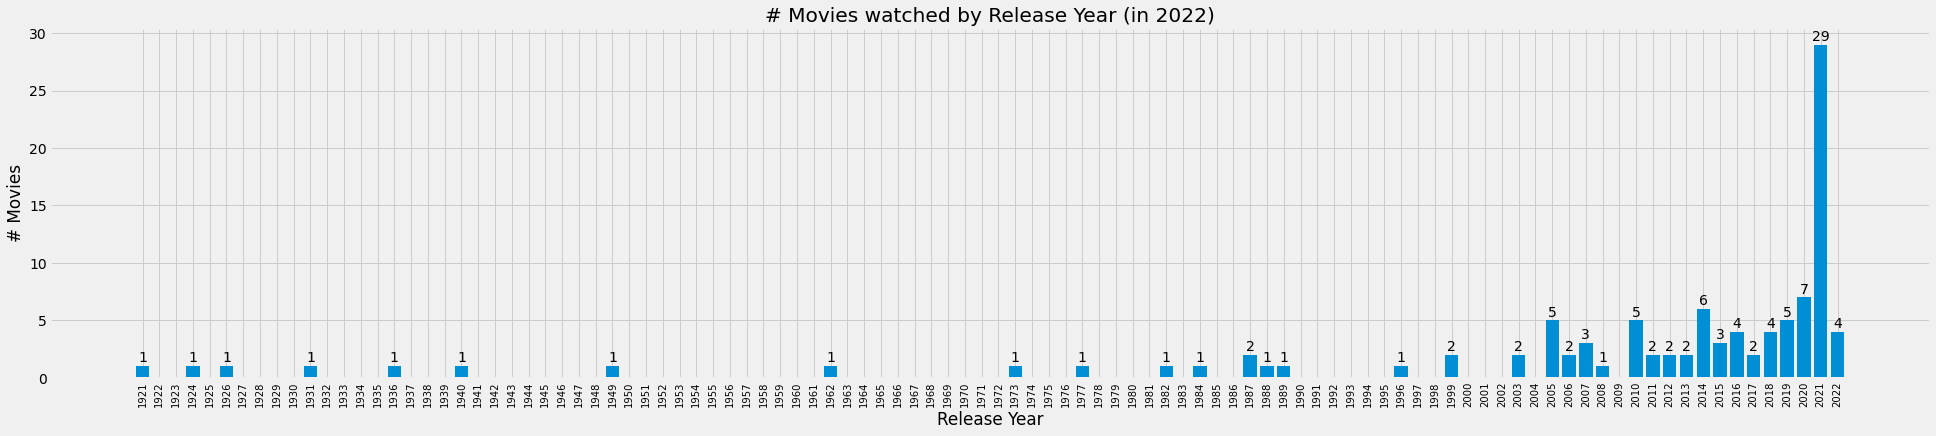

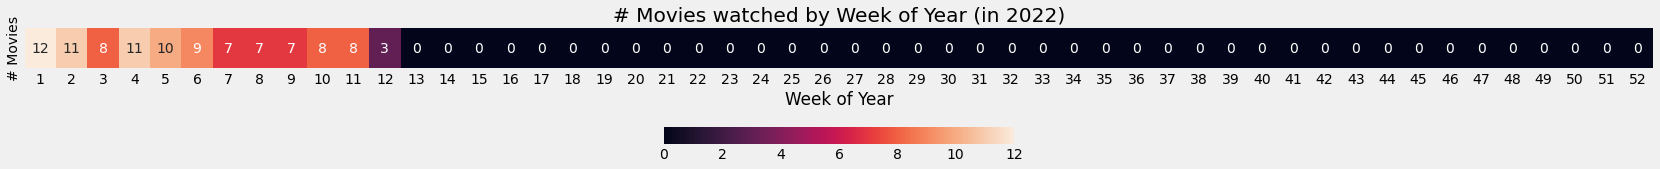

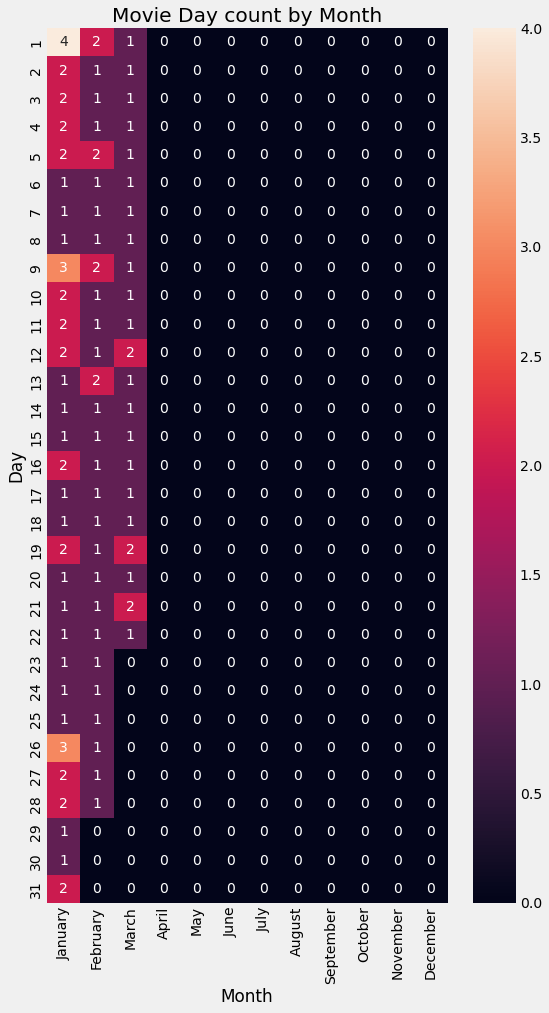

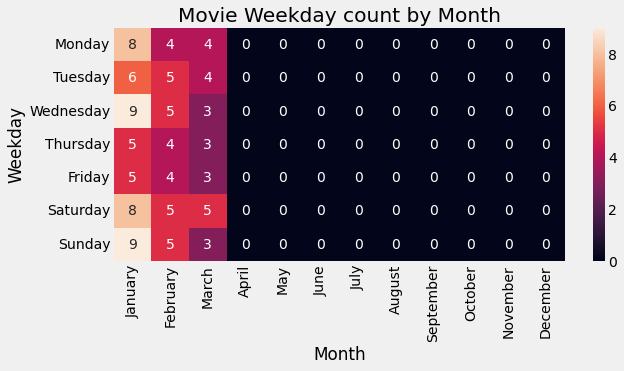

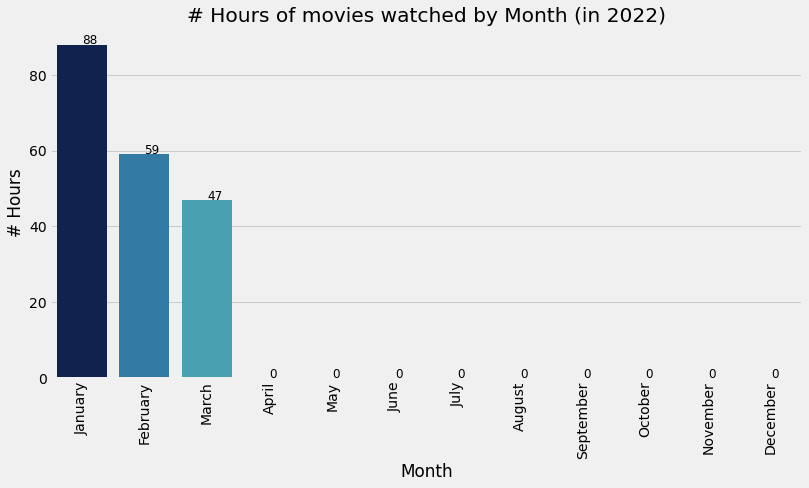

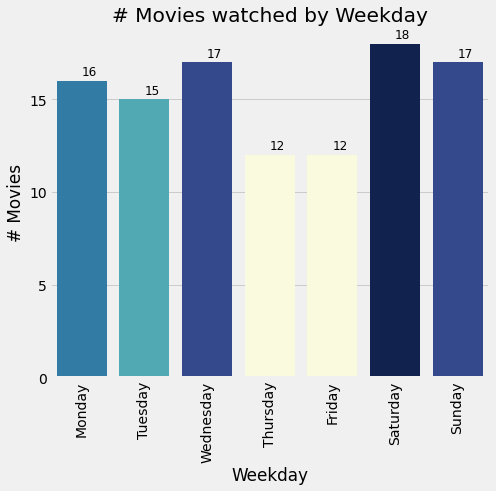

32% of the movies were watched on the weekend!





In [48]:
# Get overview by year (since 2020)
df_top_movies = df_byear[~df_byear['Genre'].str.contains('Documentary')][~df_byear.duplicated(['Title','Year'], keep='first')]

[
    [print(year,'\n'), 
     # remove movies watched more than once for this view
     show_all(df_top_movies[df_top_movies['Date'].dt.year == year].nlargest(N, 'imdbRating', keep='all')),
          
     plot_movie_trend(df_byear, year),
     
     plot_week_bar(df_byear, year),
     plot_heatmap(df_byear, 'Month', year),
     plot_heatmap(df_byear, 'Weekday', year),
     
     plot_hour_month_bar(df_byear, year),
     plot_weekday_bar(df_byear, year), 

     plt.show(),
     print('\n\n')] 
    for year in years
];

In [49]:
# Calendar - month days
first_year = str(df_byear['Date'].dt.year.min())
calendar = pd.DataFrame({'date': pd.date_range(first_year+'-01', now, freq='M')})
calendar['daysinmonths'] = calendar['date'].apply(lambda t: pd.Period(t, freq='S').days_in_month)

print('Days without any movie watched\n')
[
    [
        skip_days(df, calendar, year),
    ] 
    for year in years
];

Days without any movie watched

2018
By month: [27, 18, 19, 27, 28, 25, 30, 26, 29, 29, 23, 29]
Total: 310/365
84 %


2019
By month: [24, 26, 22, 28, 28, 25, 28, 29, 25, 25, 23, 23]
Total: 306/365
83 %


2020
By month: [17, 17, 16, 14, 7, 11, 22, 17, 17, 16, 13, 5]
Total: 172/366
46 %


2021
By month: [5, 0, 0, 1, 2, 5, 12, 5, 1, 1, 0, 2]
Total: 34/365
9 %


2022
By month: [0, 0]
Total: 0/59
0 %




In [50]:
# Days wiht most movies watched
df_byear = explode_date(df_byear)
df_byear_movies = df_byear.groupby('Date').agg({'WeekdayName':'unique', 
                                              'Title':['count','; '.join], 
                                              'Time':list, 
                                              'Runtime':[list,'sum']})

df_byear_movies[('WeekdayName','unique')] = df_byear_movies[('WeekdayName','unique')].map(lambda x : x[0])
show_all(df_byear_movies[df_byear_movies['Title']['count'] > 2]) # days with more than 2 movies watched

In [51]:
# Best movies watched (based on imdbRating) by month
cols = ['Year','Month','MonthName','Title','imdbRating','DateYear']
SHOW = 3 # show how many movies

df_movies_by_month = df_byear[~df_byear.duplicated(['Title','Year'], keep='first')][cols]
df_movies_by_month = df_movies_by_month.groupby(['DateYear','Month','MonthName'], as_index=False)

df_best_movies_by_month = df_movies_by_month.apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_movies_by_month = pd.crosstab(index=df_best_movies_by_month['DateYear'], 
                                      columns=[df_best_movies_by_month['Month'], df_best_movies_by_month['MonthName']],
                                      values=df_best_movies_by_month['Title'],
                                      aggfunc=' * '.join)

df_best_movies_by_month = df_best_movies_by_month.droplevel('Month', axis=1)
show_all(df_best_movies_by_month)

In [52]:
# Average movie rating by Month
df_best_month = df_byear[~df_byear.duplicated(['Title','Year'], keep='first')][cols]
df_best_month = pd.crosstab(index=df_best_month['DateYear'], 
                            columns=[df_best_month['Month'], df_best_month['MonthName']], 
                            values=df_best_month['imdbRating'], 
                            aggfunc='mean') #.round(1)

df_best_month = df_best_month.droplevel('Month', axis=1)

df_best_month.style.background_gradient(axis=1).set_precision(1) # evaluate by year

---

## Recent trend

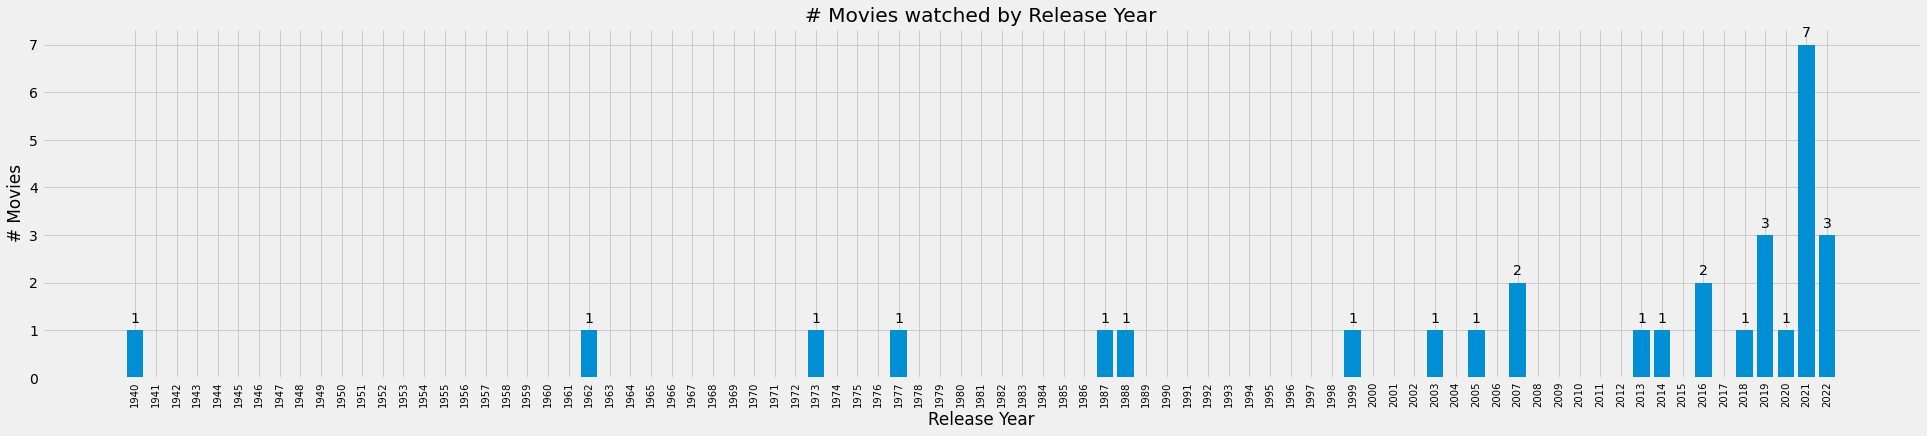

In [53]:
# Movies by Release Year (recent trend)
LAST = 30 # trakt shows last 60 movies
df_last_watched = df.tail(LAST)
plot_last_watched = df_last_watched.groupby(by='Year').agg({'Title': 'count'}).reset_index()

plot_movie_trend(plot_last_watched)

In [54]:
# Last movies watched
df_last_watched.groupby(['Year','Title']).agg({'imdbRating':'mean', 'Director':' '.join}).style.background_gradient(subset='imdbRating').set_precision(1)

In [55]:
## Any rewatched movie in the previous 60?
#df_last_watched[df_last_watched[['Title','Year','Director']].duplicated(keep=False)]

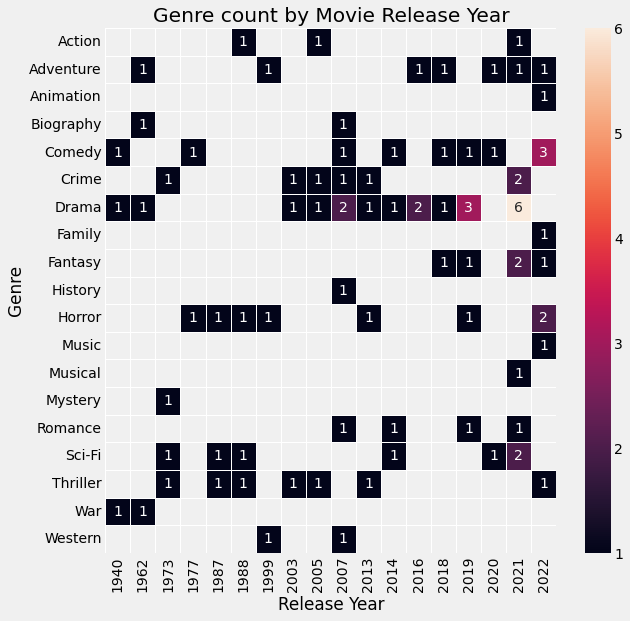

In [56]:
# Movies by Genre per Release Year (recent trend)
cols = ['Title','Year','Genre','imdbRating']

df_genre_year = df_last_watched[cols].copy()
df_genre_year['Genre'] = df_genre_year['Genre'].str.split(',').apply(lambda x: [e.strip() for e in x])

plot_last_genres = explode(df_genre_year, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_last_genres = plot_last_genres.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
xsize = len(plot_ct_last_genres.columns) // 2
ysize = len(plot_ct_last_genres.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.heatmap(plot_ct_last_genres, annot=True, linewidths=.5, ax=ax)
ax.set_xticklabels(plot_ct_last_genres.columns, rotation=90) 

plt.title('Genre count by Movie Release Year')
plt.xlabel('Release Year');

In [57]:
# Movies by Genre (recent trend)
df_plot_genres = df_genre_year.copy()

plot_last_genres = explode(df_plot_genres, ['Genre'])
plot_last_genres = plot_last_genres.groupby(['Genre']).agg({'Title':'count'}).sort_values(['Title'], ascending=False)
plot_last_genres

Title
Genre           
Drama         20
Comedy        10
Horror         8
Thriller       7
Crime          7
Sci-Fi         7
Adventure      7
Fantasy        5
Romance        4
Action         3
War            2
Western        2
Biography      2
Musical        1
Mystery        1
Music          1
Family         1
Animation      1
History        1

In [58]:
# Movies by Director (recent trend )
gb_last_watched = df_last_watched.groupby('Director').agg({'Title':[''.join,'count'], 'imdbRating':'mean'})
gb_last_watched = gb_last_watched.sort_values([('Title','count'), ('imdbRating','mean')], ascending=False).head(N)
gb_last_watched[('imdbRating','mean')] = gb_last_watched[('imdbRating','mean')].round(1)

show_all(gb_last_watched)

---

## Timestamp

In [59]:
# Setup timestamp here - to be used later
cols = ['Title','Year','Rated','Genre','Timestamp','Date','Time']
df_timestamp = df[cols].copy() 

explode_date(df_timestamp)
df_timestamp['Hour'] = df_timestamp['Timestamp'].dt.hour
df_timestamp['Minute'] = df_timestamp['Timestamp'].dt.minute

# https://stackoverflow.com/questions/62915974/pandas-group-by-time-interval-5min-10min-1day-1year-and-count-amount-of-ent
period = '15Min'
# divide hour into blocks of x minutes
df_timestamp['Period'] = pd.DataFrame(df_timestamp['Timestamp'].dt.floor(period))['Timestamp'].dt.minute

In [60]:
## Last watched movies timestamp
df_last_hour = df_timestamp.tail(LAST).copy()
ct_last_hour = pd.crosstab([df_last_hour['Weekday'], df_last_hour['WeekdayName']], df_last_hour['Hour'])
ct_last_hour = ct_last_hour.droplevel(0)

ct_last_hour.style.background_gradient(axis=None) # all values

In [61]:
# Create 24h range
range24 = np.arange(24)

# Analysis by hour of day
ycol = df_timestamp['Hour']

In [62]:
# Movies watched by hour per Weekday
xcol = [df_timestamp['Weekday'], df_timestamp['WeekdayName']]

ct_week_hour = pd.crosstab(xcol, ycol)
ct_week_hour = ct_week_hour.droplevel(0)

ct_week_hour.style.background_gradient(axis=1) # evaluate by weekday

In [63]:
# Movies watched by hour per Month
xcol = [df_timestamp['Month'], df_timestamp['MonthName']]

ct_month_hour = pd.crosstab(xcol, ycol)
ct_month_hour = ct_month_hour.droplevel(0)

ct_month_hour.style.background_gradient(axis=1) # evaluate by month

In [64]:
# Movies watched complete scenario
xcol = [df_timestamp['Month'], df_timestamp['MonthName'], df_timestamp['Weekday'], df_timestamp['WeekdayName']]

ct_month_week = pd.crosstab(xcol, ycol)
ct_month_week = ct_month_week.droplevel([0,2])

show_all(ct_month_week.style.background_gradient(axis=1))

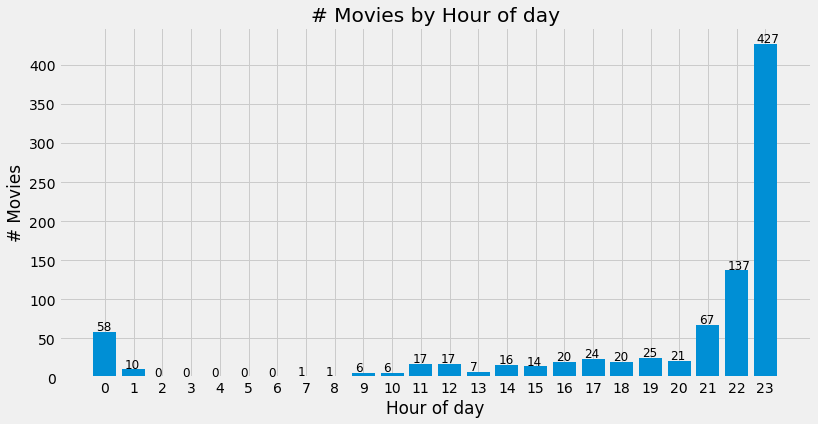

In [65]:
# Movies watched by hour of day (0-24)
plot_hour_day = df_timestamp.groupby('Hour').agg({'Title':'count'})

plot_24 = pd.DataFrame(range24, columns=['Hour']) # from 0 to 23, without missing a hour
plot_24['Title'] = plot_hour_day['Title']
plot_24['Title'] = plot_24['Title'].fillna(0).astype(int)

x = plot_24.Hour
y = plot_24.Title

# Plot
xsize = len(x) // 2

plt.figure(figsize=(xsize,6))
plt.bar(x, y)

plt.xlabel('Hour of day')
plt.ylabel('# Movies')
plt.title('# Movies by Hour of day')

plt.xticks(range24)

for i, rate in enumerate(y):
    plt.text(i-0.3, rate+2, rate, fontdict={'fontsize':12})

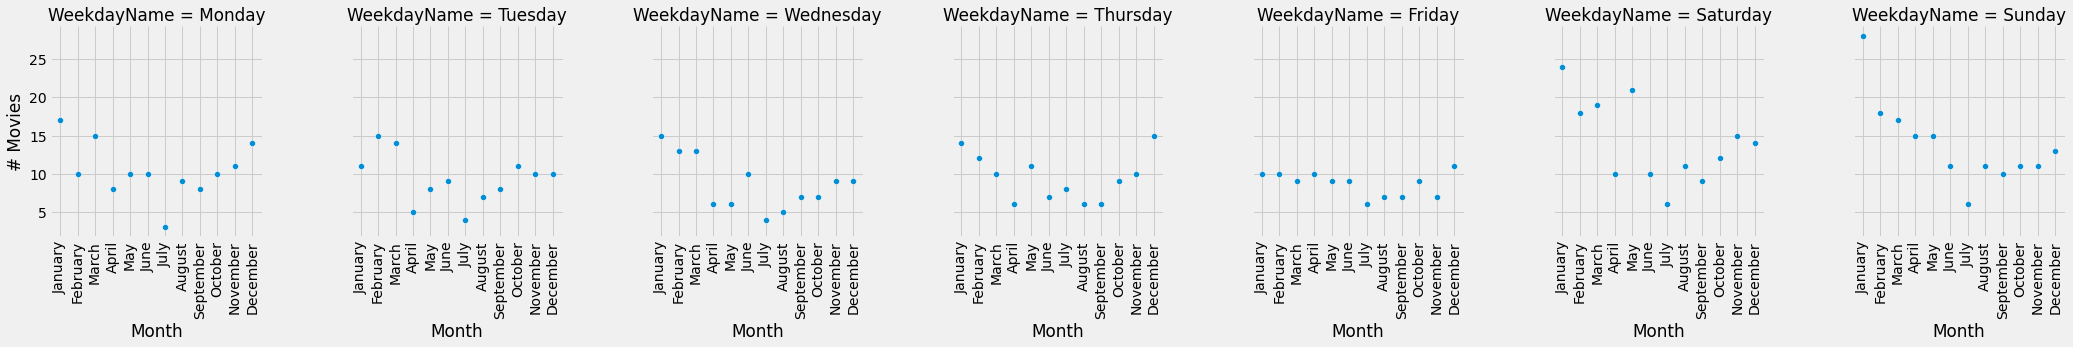

In [66]:
# Movies watched by Weekday / Month
cols = ['Month','MonthName','Weekday','WeekdayName']
gb_timestamp = df_timestamp.groupby(cols).agg({'Title':'count'}).reset_index()

# Plot
g = sns.FacetGrid(gb_timestamp, col="WeekdayName")
g.map(sns.scatterplot, "MonthName", "Title")
g.set_axis_labels("Month", "# Movies")
g.fig.set_figheight(5)
g.fig.set_figwidth(30);

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

2018 



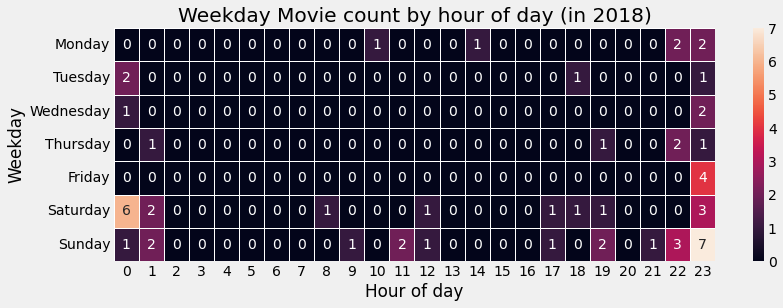



2019 



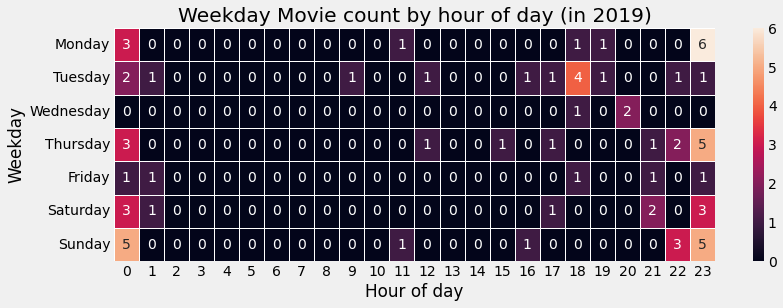



2020 



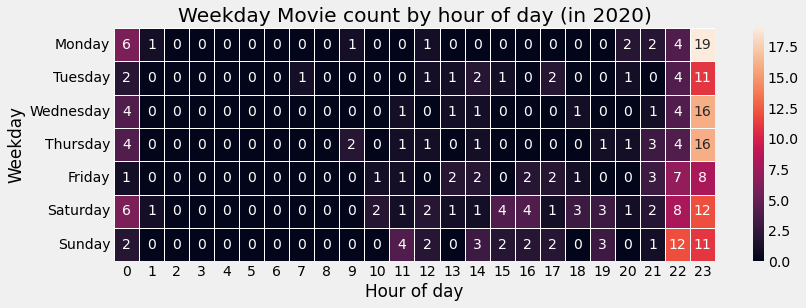



2021 



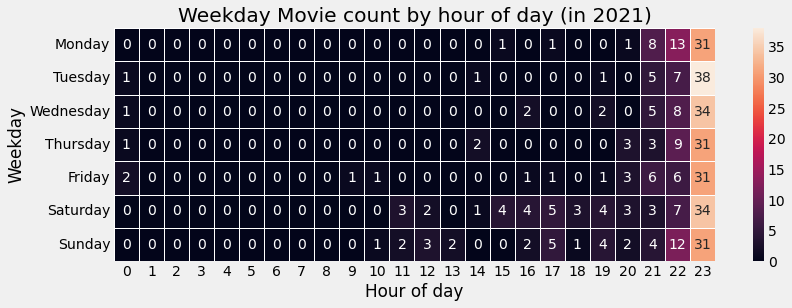



2022 



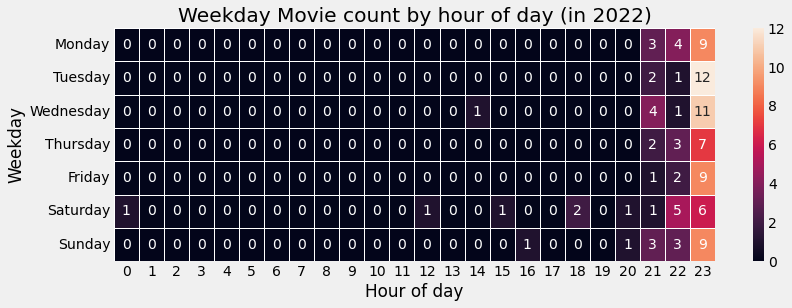

In [67]:
# Get overview by Year (since 2020)

# Create 24 hour dataframe
weekdays = ct_last_hour.index.values # get weekday names ordered from previously created dataframe 
df_24 = pd.DataFrame(0, index=weekdays, columns=range24)
df_24.index.name = 'WeekdayName'
df_24.columns.name = 'Hour'

xsize = len(df_24.columns) // 2

for year in years:
    plot_hour_weekday_year = df_timestamp[df_timestamp['Timestamp'].dt.year == year]
    
    print(year,'\n') 
    plot_hour_weekday_year = pd.crosstab([plot_hour_weekday_year['Weekday'], plot_hour_weekday_year['WeekdayName']], plot_hour_weekday_year['Hour'])
    plot_hour_weekday_year = plot_hour_weekday_year.droplevel(0)
    
    plot_24hour_weekday_year = pd.concat([plot_hour_weekday_year, df_24]).iloc[:7,:].fillna(0).astype(int)
    
    # Plot
    _, ax = plt.subplots(figsize=(xsize, 4))
    sns.heatmap(plot_24hour_weekday_year, annot=True, fmt="d", linewidths=.5, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0);
    plt.title('Weekday Movie count by hour of day (in ' + str(year) + ')')
    plt.xlabel('Hour of day')
    plt.ylabel('Weekday')
    plt.show()

    print('\n')

In [68]:
# Weekdays
df_time_genre = df_timestamp.copy()
# strip multiple genre
df_time_genre = split_explode(df_time_genre, 'Genre')

week_unique_days = df_time_genre.groupby(['Weekday','WeekdayName']).agg({'Date':'nunique', 'Title':'nunique'})
week_unique_days = week_unique_days.droplevel(0)

# Sum days and movies
total_days = week_unique_days['Date'].sum()
total_movies = week_unique_days['Title'].sum()

print('Total days with at least 1 movie watched:', total_days)
print('Total movies watched:', total_movies)

week_unique_days.style.background_gradient(subset='Date')

Total days with at least 1 movie watched: 720
Total movies watched: 894


In [69]:
# Analysis by genre
xcol = df_time_genre['Genre']

# Genre by Weekday
ycol = [df_time_genre['Weekday'], df_time_genre['WeekdayName']]
ct_genre_week = pd.crosstab(xcol, ycol).droplevel(0, axis=1)
ct_genre_week.style.background_gradient(axis=1) # evaluate by genre

In [70]:
# Genre by Month
ycol = [df_time_genre['Month'], df_time_genre['MonthName']]
ct_genre_month = pd.crosstab(xcol, ycol).droplevel(0, axis=1)
ct_genre_month.style.background_gradient(axis=1) # evaluate by genre

In [71]:
# Genre by Weekday per Month
ycol = [df_time_genre['Month'], df_time_genre['MonthName'], df_time_genre['Weekday'], df_time_genre['WeekdayName']]

ct_genre_week_month = pd.crosstab(xcol, ycol).T
ct_genre_week_month = ct_genre_week_month.droplevel([0,2])
show_all(ct_genre_week_month.style.background_gradient(axis=0))

## Release Year

In [72]:
# Set release year dataframe
cols = ['Title','Year','Runtime','Genre','Director','Metascore','imdbRating','imdbVotes','Date']

df_release_year = df[cols].copy()

In [73]:
# Last watched movies
N = 10
df_release_year[['Title','Year']].tail(N)

Title  Year
893               Comet  2014
894            Plus One  2019
895        Petite Maman  2021
896            Pleasure  2021
897      It Chapter Two  2019
898            Ravenous  1999
899  A Bittersweet Life  2005
900           They Live  1988
901          The Hidden  1987
902          Studio 666  2022

In [74]:
# Movies by Release Year
df_group_year = df_release_year.groupby(by='Year').agg({'Title': 'count',
                                                        'Runtime': np.mean,
                                                        'imdbRating': 'mean'}
                                                      ).sort_values(by=['Title'], ascending=False).round(1)

df_group_year['Runtime'] = df_group_year['Runtime'].round(0).astype(int)

show_all(df_group_year.style.background_gradient(subset='imdbRating').set_precision(1))

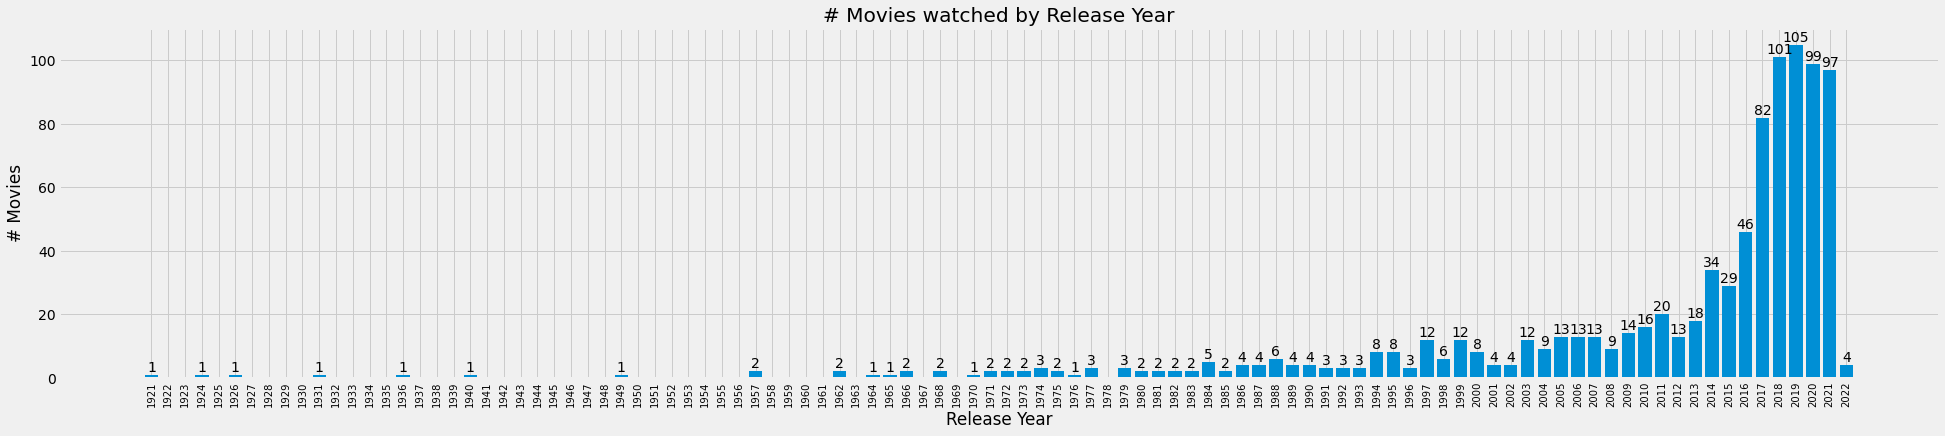

In [75]:
# Movies by Release Year
plot_movies_year = df_group_year.reset_index().sort_values('Year')

plot_movie_trend(plot_movies_year)

In [76]:
# Search by specific year
YEAR = 2002
df_release_year.groupby(by='Year').get_group(YEAR)

Title  Year  Runtime  \
201                Irreversible  2002       97   
295         Catch Me If You Can  2002      141   
483  Sympathy for Mr. Vengeance  2002      129   
546            Punch-Drunk Love  2002       95   

                                Genre              Director  Metascore  \
201   Crime, Drama, Mystery, Thriller            Gaspar Noé         51   
295           Biography, Crime, Drama      Steven Spielberg         75   
483            Crime, Drama, Thriller        Park Chan-wook         56   
546  Comedy, Drama, Romance, Thriller  Paul Thomas Anderson         78   

     imdbRating  imdbVotes       Date  
201         7.3     130561 2020-05-02  
295         8.1     928475 2020-08-31  
483         7.5      67529 2021-03-19  
546         7.3     160549 2021-05-17

In [77]:
# Top movies watched from last year (release year == last year)
latest_year = current_year - 1 

if len(df_release_year[df_release_year['Year'] == latest_year]) != 0:
    print(str(latest_year))
    df_latest_year = df_release_year.groupby(by='Year').get_group(latest_year)[df_release_year.Year == latest_year].drop_duplicates('Title')
    df_latest_year = df_latest_year.sort_values(['imdbRating','imdbVotes'], ascending=[False, False])
    
    show_all(df_latest_year)
else:
    None

2021


In [78]:
# Best movies by Release Year
BEST = 3
condition = 'Documentary' # remove this genre
cols = ['Title','Year','Runtime','imdbRating']

# Top movies
df_top_movies_year = df_release_year[~df_release_year['Genre'].str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_movies_year = df_top_movies_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_movies_year['Runtime'] = df_top_movies_year['Runtime'].astype(int)

show_all(df_top_movies_year.style.background_gradient(subset='imdbRating').set_precision(1))

In [79]:
# Top documentaries by Release Year
df_top_docs_year = df_release_year[df_release_year['Genre'].str.contains(condition)][cols].groupby(['Year','Title']).mean().sort_values(['Year','imdbRating'], ascending=False)
df_top_docs_year = df_top_docs_year.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)

df_top_docs_year['Runtime'] = df_top_docs_year['Runtime'].astype(int)

show_all(df_top_docs_year.style.background_gradient(subset='imdbRating').set_precision(1))

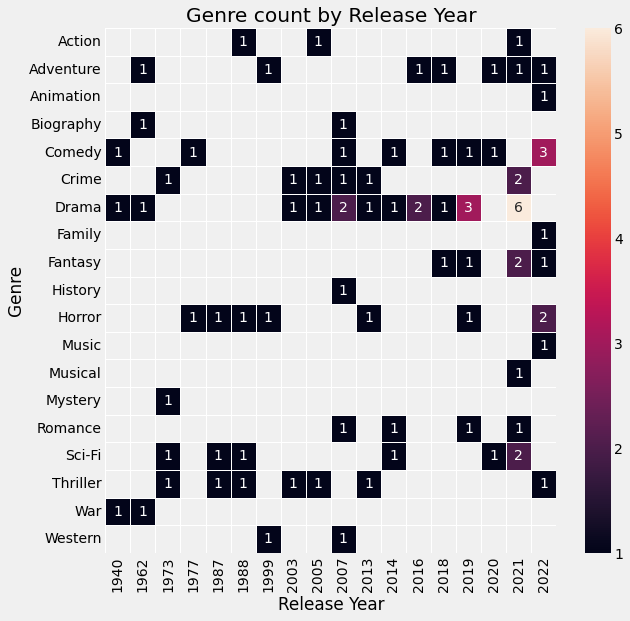

In [80]:
# Genre count by Release Year
plot_genre_year = explode(df_genre_year, ['Genre'])
plot_genre_year = plot_genre_year.groupby(['Year','Genre']).agg({'Title':'count'}).sort_values(['Year','Title'], ascending=False)
plot_ct_genre_year = plot_genre_year.unstack().T.reset_index().set_index('Genre').drop(['level_0'], axis=1)

# Plot
xsize = len(plot_ct_genre_year.columns) // 2
ysize = len(plot_ct_genre_year.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
ax = sns.heatmap(plot_ct_genre_year, annot=True, linewidths=.5, ax=ax)
plt.title('Genre count by Release Year')
plt.xlabel('Release Year')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [81]:
# Prepare plotting
year_list = plot_movies_year['Year']
x = 'Year'

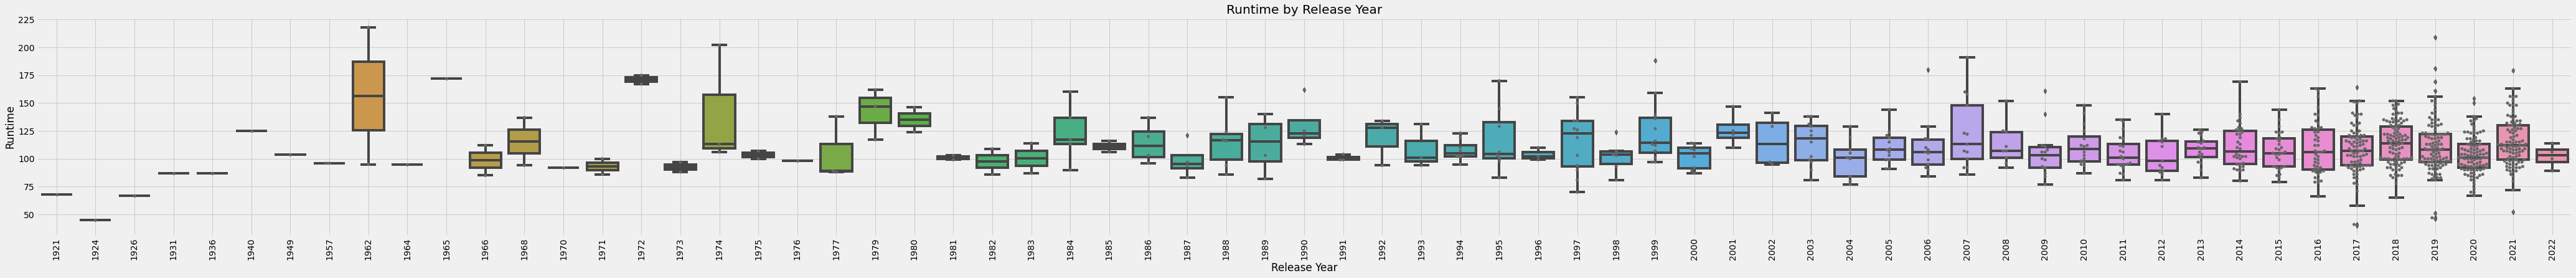

In [82]:
# Runtime by Release Year
y = 'Runtime'
plot_box_swarm(x, y, df, year_list)

In [83]:
# Time spent watching movies
runtime = df_release_year['Runtime'].sum()

print(runtime.astype(int), 'minutes')
print((runtime / 60).astype(int), 'hours')
print((runtime / (60*24)).astype(int), 'days')

98587 minutes
1643 hours
68 days


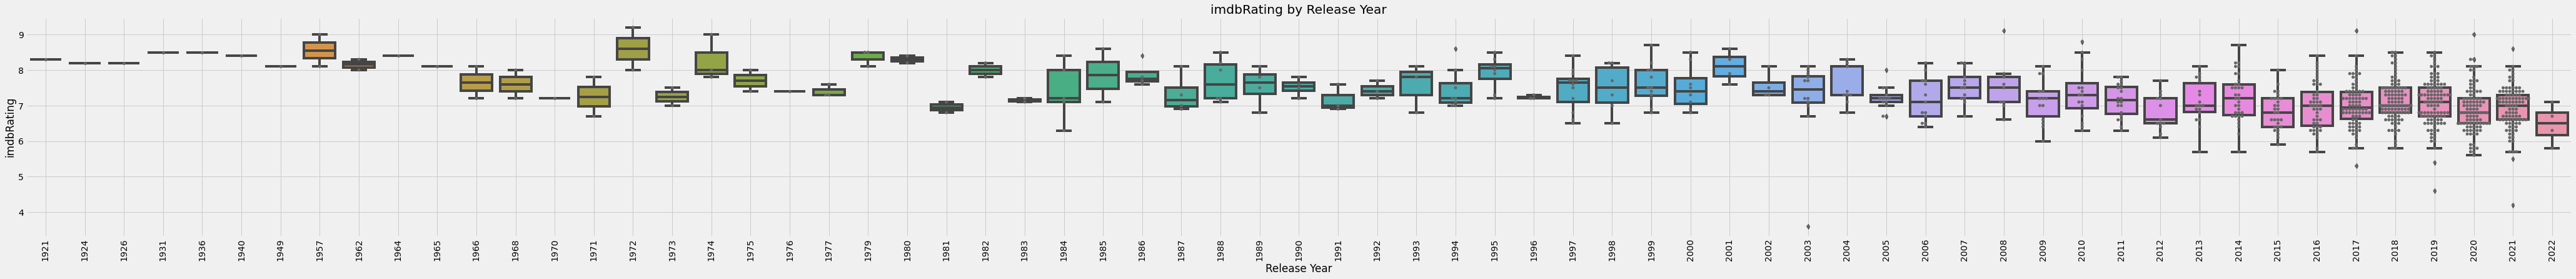

In [84]:
# imdbRating by Release Year
y = 'imdbRating'
plot_box_swarm(x, y, df, year_list)

### Decade

In [85]:
# Set decade dataframe
cols = ['Title', 'Year', 'Runtime', 'imdbRating', 'Genre', 'Language']

df_decade = df[cols].copy()

In [86]:
# Movies by Decade
df_decade['Decade'] = df_decade['Year'].astype(int)//10*10 # convert to decade

movies_decade = df_decade.groupby('Decade').agg({'Title': 'count', 
                                                 'Runtime': 'mean',
                                                 'imdbRating': 'mean'}).round(1)

movies_decade['Runtime'] = movies_decade['Runtime'].round(0).astype(int)
movies_decade.style.background_gradient(subset='imdbRating').set_precision(1)

In [87]:
# Highest rating movies by Decade
BEST = 3
condition = 'Documentary' # filter this out

df_top_rating_decade = df_decade[~df_decade['Genre'].str.contains(condition)] # filter out documentary 
df_top_rating_decade = df_top_rating_decade.drop_duplicates(subset=['Title','Year'], keep='first')
df_top_rating_decade = df_top_rating_decade.set_index(['Decade','Title']).sort_values(['Decade','imdbRating'], ascending=False)

df_top_rating_decade = df_top_rating_decade.groupby(level=0, as_index=False).apply(lambda x: x.nlargest(BEST, 'imdbRating', keep='all')).reset_index(level=0, drop=True)
df_top_rating_decade

Year  Runtime  \
Decade Title                                                               
1920   The Kid                                             1921       68   
       Sherlock Jr.                                        1924       45   
       The General                                         1926       67   
1930   City Lights                                         1931       87   
       Modern Times                                        1936       87   
1940   The Great Dictator                                  1940      125   
       The Third Man                                       1949      104   
1950   12 Angry Men                                        1957       96   
       The Seventh Seal                                    1957       96   
1960   Dr. Strangelove or: How I Learned to Stop Worry...  1964       95   
       Lawrence of Arabia                                  1962      218   
       The Sound of Music                                  1965      172   
       Persona                                             1966       85   
1970   The Godfather                                       1972      175   
       The Godfather: Part II                              1974      202   
       Alien                                               1979      117   
       Apocalypse Now                                      1979      147   
1980   Back to the Future                                  1985      116   
       Cinema Paradiso                                     1988      155   
       The Shining                                         1980      146   
       Aliens                                              1986      137   
       Amadeus                                             1984      160   
1990   The Matrix                                          1999      136   
       Léon: The Professional                              1994      110   
       The Usual Suspects                                  1995      106   
2000   The Dark Knight                                     2008      152   
       Spirited Away                                       2001      125   
       Memento                                             2000      113   
2010   Inception                                           2010      148   
       Interstellar                                        2014      169   
       Avengers: Infinity War                              2018      149   
       Parasite                                            2019      132   
2020   Spider-Man: No Way Home                             2021      148   
       The Father                                          2020       97   
       Soul                                                2020      100   
       Dune                                                2021      155   

                                                           imdbRating  \
Decade Title                                                            
1920   The Kid                                                    8.3   
       Sherlock Jr.                                               8.2   
       The General                                                8.2   
1930   City Lights                                                8.5   
       Modern Times                                               8.5   
1940   The Great Dictator                                         8.4   
       The Third Man                                              8.1   
1950   12 Angry Men                                               9.0   
       The Seventh Seal                                           8.1   
1960   Dr. Strangelove or: How I Learned to Stop Worry...         8.4   
       Lawrence of Arabia                                         8.3   
       The Sound of Music                                         8.1   
       Persona                                                    8.1   
1970   The Godfather                                              9.2   
  

In [88]:
# Return cross-section
DEC = 1970
df_top_rating_decade.xs(DEC)

Year  Runtime  imdbRating                Genre  \
Title                                                                    
The Godfather           1972      175         9.2         Crime, Drama   
The Godfather: Part II  1974      202         9.0         Crime, Drama   
Alien                   1979      117         8.5       Horror, Sci-Fi   
Apocalypse Now          1979      147         8.5  Drama, Mystery, War   

                                                          Language  
Title                                                               
The Godfather                              English, Italian, Latin  
The Godfather: Part II  English, Italian, Spanish, Latin, Sicilian  
Alien                                                      English  
Apocalypse Now                         English, French, Vietnamese

In [89]:
# Prepare plotting
x = 'Decade'
decade_list = df_decade.sort_values('Decade').Decade.unique()

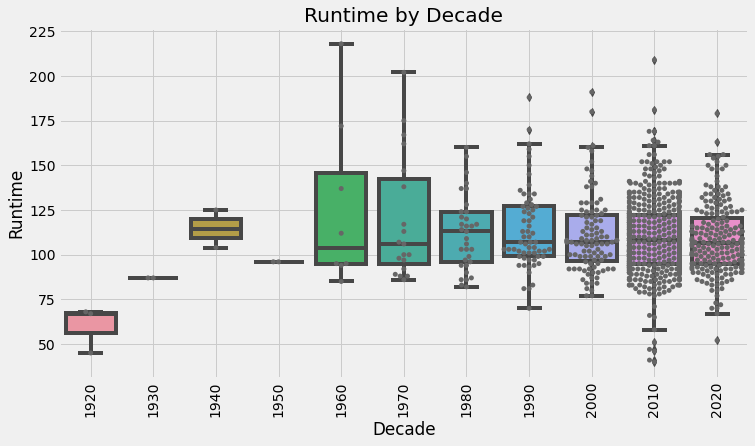

In [90]:
# Runtime by Decade
y = 'Runtime'
plot_box_swarm(x, y, df_decade, decade_list)

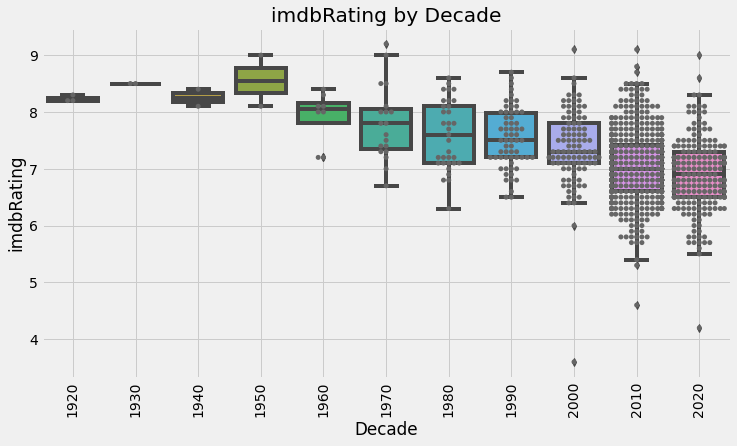

In [91]:
# imdbRating by Decade
y = 'imdbRating'
plot_box_swarm(x, y, df_decade, decade_list)

## Rated

In [92]:
# Set rated dataframe
cols = ['Title','Rated','Runtime','Genre','imdbRating']

df_rated = df[cols].copy()

In [93]:
# Movie analysis by Rated
df_rated_avg = get_mean_value(df_rated, 'Rated', 'Runtime')
df_rated_avg['imdbRating'] = get_mean_value(df_rated, 'Rated', 'imdbRating')['imdbRating']

In [94]:
# Prepare plotting
rated_list = df_rated_avg.index.sort_values()
x = 'Rated'

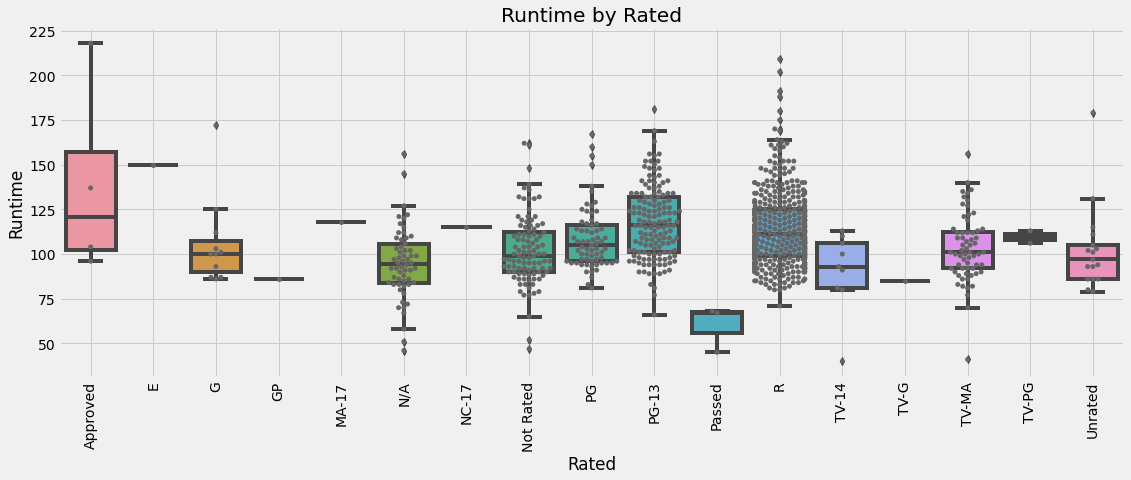

In [95]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'Runtime'
plot_box_swarm(x, y, df_rated, rated_list)

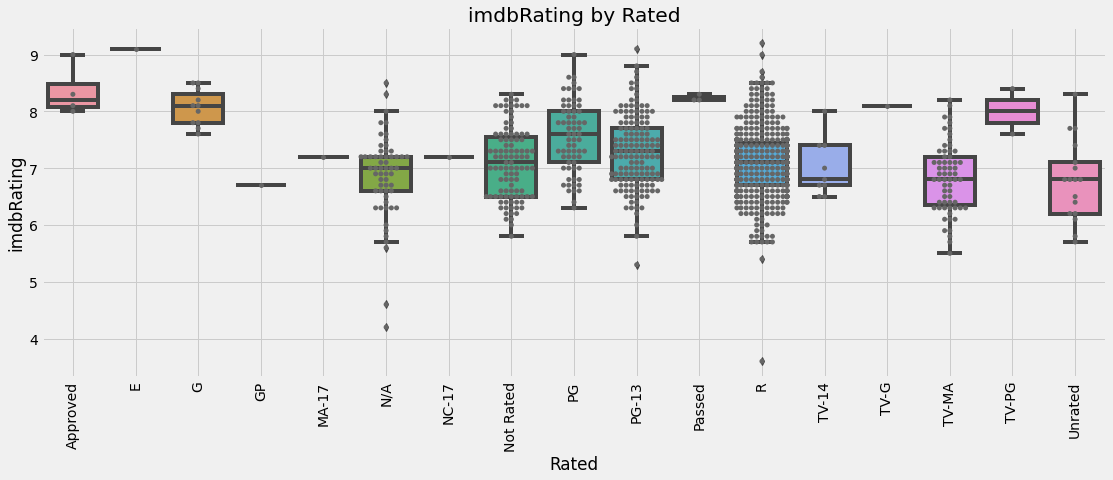

In [96]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'imdbRating'
plot_box_swarm(x, y, df_rated, rated_list)

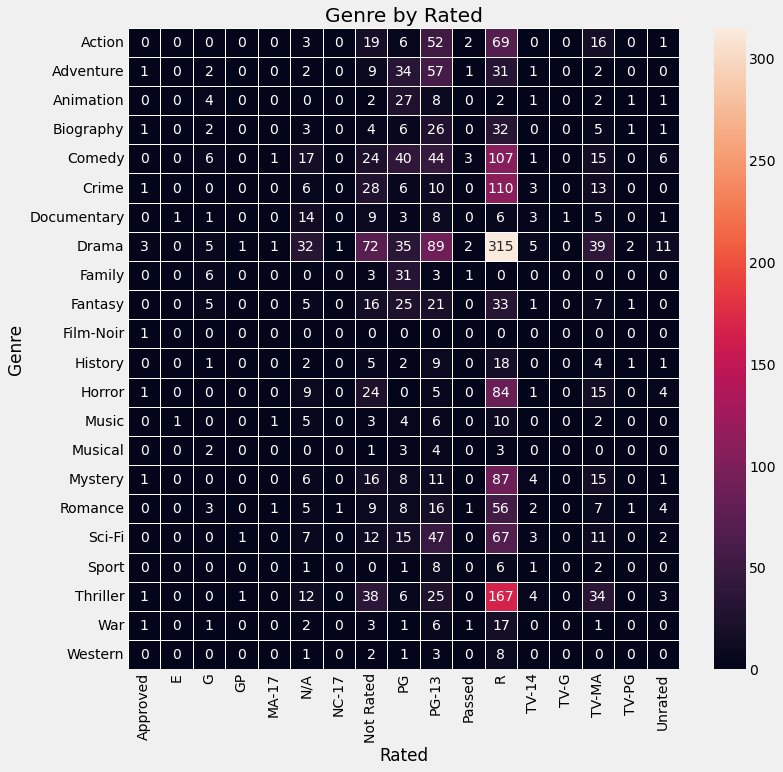

In [97]:
# Genre by Rated
df_explode_genre = df_rated.copy()

df_explode_genre = split_explode(df_explode_genre, 'Genre')
plot_ct_rated_genre = pd.crosstab(df_explode_genre['Genre'], df_explode_genre.Rated) #, margins=True)

# Plot
xsize = len(plot_ct_rated_genre.columns) // 1.5
ysize = len(plot_ct_rated_genre.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.heatmap(plot_ct_rated_genre, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title('Genre by Rated');

## Runtime

In [98]:
# Set runtime dataframe
cols = ['Title','Year','Genre','Runtime','Metascore','imdbRating']

df_runtime = df[cols].copy()

In [99]:
print('Mean runtime: ' + str(int(round(df_runtime['Runtime'].mean(), 0))))
print('Median runtime: ' + str(int(round(df_runtime['Runtime'].median(), 0)))) 

Mean runtime: 110
Median runtime: 107


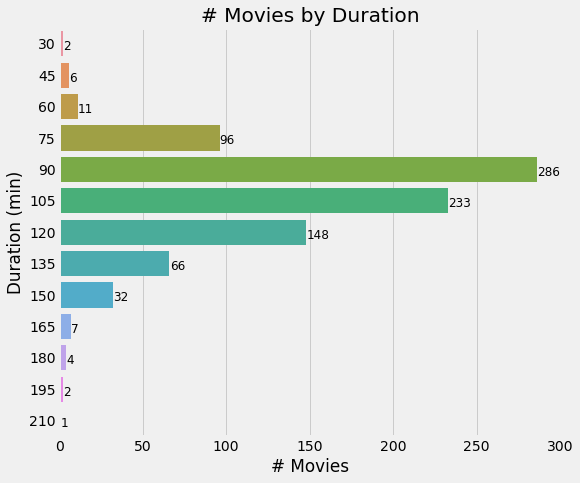

In [100]:
period = 15 # group data in groups of 15 minutes
df_runtime['Duration'] = df_runtime['Runtime'].floordiv(period) * period 
df_runtime_group = df_runtime.groupby('Duration').agg({'Title':'count'})

# Plot
plot_duration_movies = df_runtime_group.reset_index()

plt.figure(figsize=(8,7))
sns.barplot(x='Title', y='Duration', data=plot_duration_movies, orient='h');

plt.title('# Movies by Duration')
plt.xlabel('# Movies')
plt.ylabel('Duration (min)')

for i, rate in enumerate(plot_duration_movies["Title"]):
    plt.text(rate+0.1, i+0.2, rate, fontdict={'fontsize':12})

In [101]:
# Longest movies
print('Movies over 120 minutes (2 hours):   ', len(df_runtime[df_runtime.Runtime > 120]))
print('Movies over 150 minutes (2.5 hours): ', len(df_runtime[df_runtime.Runtime > 150]))
print('Movies over 180 minutes (3 hours):   ', len(df_runtime[df_runtime.Runtime > 180]))

N = 10
show_all(df_runtime.iloc[:,:-1].nlargest(N, 'Runtime', keep='all').drop_duplicates().set_index('Title'))

Movies over 120 minutes (2 hours):    254
Movies over 150 minutes (2.5 hours):  42
Movies over 180 minutes (3 hours):    6


## Genre

In [102]:
# Set genre dataframe
cols = ['Title','Year','Genre','Runtime','imdbRating','Date']

df_genre = df[cols].copy()

In [103]:
# Number of unique genres
print('Unique genres: ' + str(counter_display(df_genre, 'Genre', 'Title').index.nunique()))

# Unique genres
list(counter_display(df_genre, 'Genre', 'Title').index.unique().sort_values())

Unique genres: 22


['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [104]:
# Check genre of recently watched movies 
N = 10
df_genre.tail(N)

Title  Year                             Genre  Runtime  \
893               Comet  2014    Comedy, Drama, Romance, Sci-Fi       91   
894            Plus One  2019            Comedy, Drama, Romance       98   
895        Petite Maman  2021                    Drama, Fantasy       72   
896            Pleasure  2021                             Drama      109   
897      It Chapter Two  2019            Drama, Fantasy, Horror      169   
898            Ravenous  1999        Adventure, Horror, Western      101   
899  A Bittersweet Life  2005    Action, Crime, Drama, Thriller      119   
900           They Live  1988  Action, Horror, Sci-Fi, Thriller       94   
901          The Hidden  1987          Horror, Sci-Fi, Thriller       97   
902          Studio 666  2022             Comedy, Horror, Music      106   

     imdbRating       Date  
893         6.7 2022-03-15  
894         6.6 2022-03-16  
895         7.4 2022-03-17  
896         6.3 2022-03-18  
897         6.5 2022-03-19  
898         6.9 2022-03-19  
899         7.5 2022-03-20  
900         7.2 2022-03-21  
901         7.0 2022-03-21  
902         5.8 2022-03-22

In [105]:
# Top movie genres
df_explode_genre = df_genre.copy()

# do this for visualization below
df_explode_genre = split_explode(df_explode_genre, 'Genre')

In [106]:
# Statistic analysis of Runtime by Genre
df_genre_runtime_stats = df_explode_genre.drop('imdbRating', axis=1).groupby('Genre')['Runtime'].describe()

stat_cols = df_genre_runtime_stats.columns.values #['count','mean','std','min','max']

df_genre_runtime_stats[stat_cols] = df_genre_runtime_stats[stat_cols].fillna(0).astype(int)
df_genre_runtime_stats.sort_values('count', inplace=True, ascending=False)

df_genre_runtime_stats.style.background_gradient(subset='mean')

In [107]:
# Statistic analysis of imdbRating by Genre
df_genre_rating_stats = df_explode_genre.drop('Runtime', axis=1).groupby('Genre')['imdbRating'].describe()

stat_cols = df_genre_rating_stats.columns.values

df_genre_rating_stats[stat_cols] = df_genre_rating_stats[stat_cols].fillna(0).round(1)
df_genre_rating_stats['count'] = df_genre_rating_stats['count'].astype(int)
df_genre_rating_stats.sort_values('count', inplace=True, ascending=False)

df_genre_rating_stats.style.background_gradient(subset='mean').set_precision(1)

In [108]:
# Genre (runtime and rating mean values)
df_genre_top_stats = pd.DataFrame(index = df_genre_runtime_stats.index)

df_genre_top_stats['count'] = df_genre_runtime_stats['count']
df_genre_top_stats['runtime'] = df_genre_runtime_stats['mean']
df_genre_top_stats['ratings'] = df_genre_rating_stats['mean']

df_genre_top_stats

count  runtime  ratings
Genre                               
Drama          613      112      7.2
Thriller       291      110      7.0
Comedy         264      103      7.1
Crime          177      113      7.2
Action         168      118      7.1
Sci-Fi         165      114      7.0
Mystery        149      111      7.0
Horror         143      105      6.7
Adventure      140      117      7.2
Fantasy        114      112      7.1
Romance        114      110      7.2
Biography       81      122      7.4
Documentary     52       89      7.6
Animation       48      100      7.7
Family          44      101      7.6
History         43      116      7.4
War             33      117      7.6
Music           32      109      7.4
Sport           19      114      7.4
Western         15      118      7.1
Musical         13      120      7.3
Film-Noir        1      104      8.1

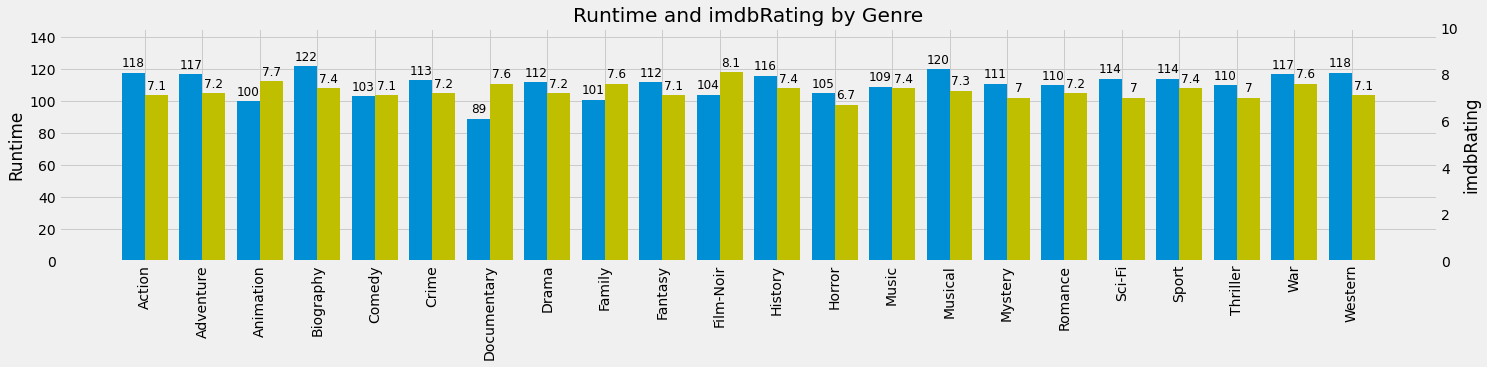

In [109]:
# Plot genre data
df_genre_data = df_genre_top_stats.reset_index().sort_values(by='Genre')

labels = df_genre_data['Genre'] # all genres
x = np.arange(len(labels)) # range of genres
width = 0.4 # the width of the bars

# Create plot
xsize = len(labels)

_, ax1 = plt.subplots(figsize=(xsize, 4))
ax2 = ax1.twinx()

# Bar plots
bar1 = ax1.bar(x - width/2, df_genre_data.runtime, width, label='Runtime')
bar2 = ax2.bar(x + width/2, df_genre_data.ratings, width, label='imdbRating', color='y')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('Runtime and imdbRating by Genre')
ax1.set_ylabel('Runtime')
ax2.set_ylabel('imdbRating')
ax1.bar_label(bar1, padding=3, fontsize=12)
ax2.bar_label(bar2, padding=3, fontsize=12)
ax2.yaxis.grid(False)

# Set ticks and limits
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90) 
ax1.set_ylim(0, int(np.ceil(df_genre_data.runtime.max() + 3*df_genre_data.runtime.std()))) # set y max limit as max value + 3 std
ax2.set_ylim(0, 10) # imdbRating from 0 to 10

plt.show()

In [110]:
# Prepare ploting
x = 'Genre'
# get genre order a-z
genre_list = counter_display(df, 'Genre', 'Title', None).index.unique().sort_values()

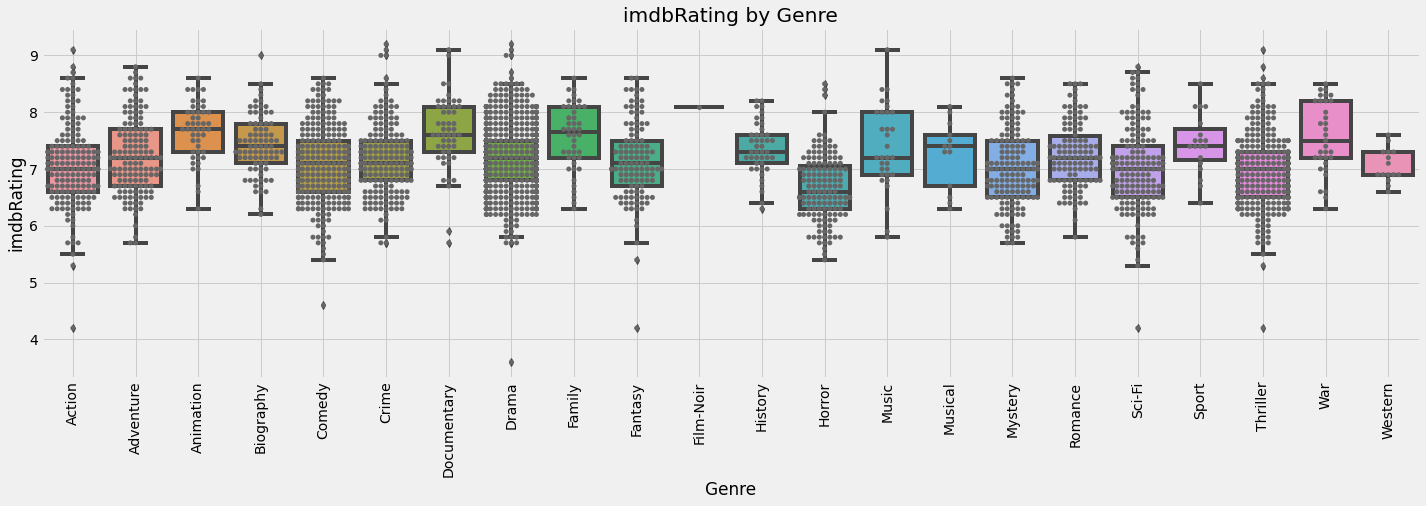

In [111]:
# The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2)
y = 'imdbRating'
plot_box_swarm(x, y, df_explode_genre, genre_list)

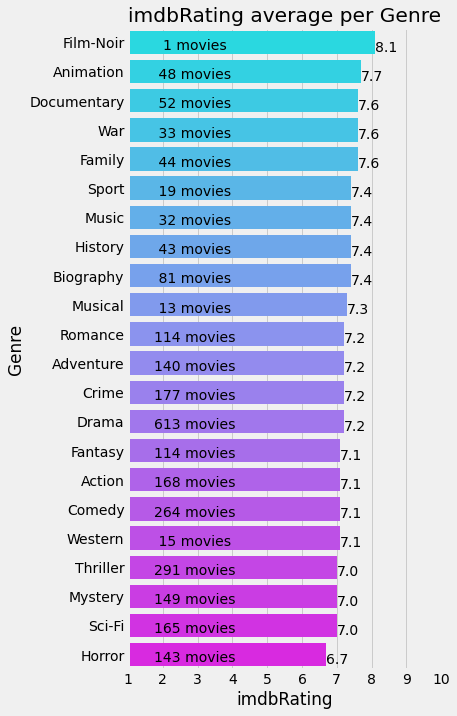

In [112]:
# Genre with highest imdbRating
df_genre_rating_stats.sort_values(by='mean', ascending=False, inplace=True)

# Plot
# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
ratings = [1, 10] # imdbRating from 1 to 10
xsize = ratings[1] // 2
ysize = len(df_genre_rating_stats.index) // 2

plt.figure(figsize=(xsize,ysize))
sns.barplot(y=df_genre_rating_stats.index, x=df_genre_rating_stats["mean"], palette='cool', orient="h")

plt.title('imdbRating average per Genre')
plt.xlabel('imdbRating')
plt.xlim(ratings) 
plt.xticks(np.arange(ratings[0], ratings[1]+1, step=1))

for i, counts in enumerate(df_genre_rating_stats["count"]):
    plt.text(ratings[0]+0.5, i+0.25, f"{counts:>5} movies")
    plt.text(df_genre_rating_stats["mean"][i], i+0.3, df_genre_rating_stats["mean"][i])
    
plt.show()

In [113]:
# Number of unique combination of genres
df_genre[['Genre','Title']].groupby(by='Genre').count().reset_index()['Genre'].nunique()

346

In [114]:
# Top movie genres combination
df_genre_date = df_genre.copy()
df_genre_date['Year'] = df_genre['Date'].dt.year

df_genre_date.drop(columns='Date', inplace=True)
pd.crosstab(df_genre_date['Genre'], df_genre_date['Year'], margins=True).nlargest(N+1, 'All', keep='all') # +1 because 'All' takes 1 spot 

Year                             2018  2019  2020  2021  2022  All
Genre                                                             
All                                59    73   251   404   107  894
Drama                               1     3    22    26    12   64
Comedy, Drama                       7     4    12    18     2   43
Crime, Drama, Thriller              2     3    11    10     4   30
Documentary                         2     1     9     9     2   23
Comedy, Drama, Romance              0     1     0    12     8   21
Drama, Romance                      0     2     5    11     3   21
Crime, Drama                        1     1     4     9     3   18
Crime, Drama, Mystery, Thriller     0     3     6     7     1   17
Action, Adventure, Sci-Fi           4     3     1     5     0   13
Biography, Drama                    0     1     6     6     0   13
Drama, Mystery, Thriller            0     1     3     7     2   13

In [115]:
# Genre combination with most movies, showing worst and best rated movies
df_genre_agg = df_genre.groupby(by='Genre').agg({'imdbRating':['min','max','mean'], 
                                                 'Title':['count']})
df_genre_agg.reset_index(inplace=True)

df_genre_agg[('Title','worst')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmin().fillna(0).astype(int)].reset_index(drop=True)['Title']
df_genre_agg[('Title','best')] = df_genre.loc[df_genre.groupby('Genre')['imdbRating'].idxmax().fillna(0).astype(int)].reset_index(drop=True)['Title']

df_genre_agg = df_genre_agg.set_index([('Genre','')]).sort_values(by=[('Title','count')], ascending=False).round(1)
df_genre_agg.index.rename('Genre', inplace=True)

df_genre_agg.nlargest(N, [('Title', 'count')], keep='all')

imdbRating           Title  \
                                       min  max mean count   
Genre                                                        
Drama                                  3.6  8.4  7.1    64   
Comedy, Drama                          6.2  8.2  7.1    43   
Crime, Drama, Thriller                 6.3  8.4  7.2    30   
Documentary                            5.9  8.5  7.5    23   
Drama, Romance                         6.1  8.5  7.4    21   
Comedy, Drama, Romance                 6.4  8.5  7.2    21   
Crime, Drama                           6.3  9.2  7.5    18   
Crime, Drama, Mystery, Thriller        6.3  8.5  7.2    17   
Drama, Mystery, Thriller               5.9  8.2  7.2    13   
Action, Adventure, Sci-Fi              6.3  8.5  7.3    13   
Biography, Drama                       6.6  8.2  7.5    13   

                                                            \
                                                     worst   
Genre                                                        
Drama                                             The Room   
Comedy, Drama                                    Chevalier   
Crime, Drama, Thriller                                Kimi   
Documentary                           Expedition Happiness   
Drama, Romance                                        Love   
Comedy, Drama, Romance                        On the Rocks   
Crime, Drama                     The Many Saints of Newark   
Crime, Drama, Mystery, Thriller               Shimmer Lake   
Drama, Mystery, Thriller                        Horse Girl   
Action, Adventure, Sci-Fi                             Dune   
Biography, Drama                                       Joy   

                                                         
                                                   best  
Genre                                                    
Drama                                         Capernaum  
Comedy, Drama                           The Truman Show  
Crime, Drama, Thriller                            Joker  
Documentary                             Untamed Romania  
Drama, Romance                          Cinema Paradiso  
Comedy, Drama, Romance                      City Lights  
Crime, Drama                              The Godfather  
Crime, Drama, Mystery, Thriller      The Usual Suspects  
Drama, Mystery, Thriller                The Sixth Sense  
Action, Adventure, Sci-Fi        Avengers: Infinity War  
Biography, Drama                       The Elephant Man

In [116]:
# Genre combination with higher imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nlargest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                     min  max mean count   
Genre                                                                      
Documentary, Music                                   8.0  9.1  8.4     3   
Action, Adventure, Sci-Fi, Thriller                  7.3  8.8  8.2     3   
Adventure, Drama, Sci-Fi                             6.9  8.7  7.9     3   
Documentary, History                                 7.5  8.1  7.8     3   
Comedy, Drama, War                                   6.9  8.4  7.7     3   
Action, Crime, Drama, Thriller                       6.5  9.1  7.6    10   
Comedy, Drama, Thriller                              6.8  8.5  7.6     4   
Mystery, Thriller                                    6.7  8.5  7.6     3   
Documentary                                          5.9  8.5  7.5    23   
Crime, Drama                                         6.3  9.2  7.5    18   
Biography, Drama                                     6.6  8.2  7.5    13   
Biography, Crime, Drama                              6.6  8.1  7.5     5   
Animation, Adventure, Comedy, Family, Fantasy        7.1  7.7  7.5     4   
Biography, Drama, Sport                              7.4  7.6  7.5     3   

                                                                          \
                                                                   worst   
Genre                                                                      
Documentary, Music                              Tripping with Nils Frahm   
Action, Adventure, Sci-Fi, Thriller                  Alita: Battle Angel   
Adventure, Drama, Sci-Fi                                           Finch   
Documentary, History                                    One Child Nation   
Comedy, Drama, War                                      Last Flag Flying   
Action, Crime, Drama, Thriller                               Enforcement   
Comedy, Drama, Thriller                                   Under the Tree   
Mystery, Thriller                                                    Run   
Documentary                                         Expedition Happiness   
Crime, Drama                                   The Many Saints of Newark   
Biography, Drama                                                     Joy   
Biography, Crime, Drama                             The Snowtown Murders   
Animation, Adventure, Comedy, Family, Fantasy                Turning Red   
Biography, Drama, Sport                                   McFarland, USA   

                                                                           
                                                                     best  
Genre                                                                      
Documentary, Music                             Hans Zimmer Live in Prague  
Action, Adventure, Sci-Fi, Thriller                             Inception  
Adventure, Drama, Sci-Fi                                     Interstellar  
Documentary, History                                            Apollo 11  
Comedy, Drama, War                                     The Great Dictator  
Action, Crime, Drama, Thriller                            The Dark Knight  
Comedy, Drama, Thriller                                          Parasite  
Mystery, Thriller                                                 Memento  
Documentary                                               Untamed Romania  
Crime, Drama                                                The Godfather  
Biography, Drama                                         The Elephant Man  
Biography, Crime, Drama                               Catch Me If You Can  
Animation, Adventure, Comedy, Family, Fantasy                 Toy Story 4  
Biography, Drama, Sport                                         Moneyball

In [117]:
# Genre combination with lower imdbRating
df_genre_agg[df_genre_agg[('Title','count')] > 2].nsmallest(N, [('imdbRating','mean')], keep='all')

imdbRating           Title  \
                                                min  max mean count   
Genre                                                                 
Comedy, Horror, Sci-Fi                          5.6  6.5  6.1     3   
Horror, Mystery, Sci-Fi, Thriller               5.8  6.8  6.3     5   
Comedy, Horror                                  5.7  7.3  6.3     4   
Action, Comedy, Horror, Thriller                5.5  6.9  6.3     3   
Drama, Horror, Thriller                         6.2  7.2  6.5     8   
Drama, Sci-Fi, Thriller                         6.0  6.8  6.5     6   
Comedy, Horror, Thriller                        6.1  6.7  6.5     5   
Drama, Horror, Mystery, Sci-Fi, Thriller        6.2  7.1  6.5     4   
Horror, Mystery, Thriller                       5.9  7.5  6.6     5   
Drama, Horror, Mystery                          6.2  6.9  6.6     3   
Crime, Drama, Horror, Thriller                  6.4  6.9  6.6     3   

                                                                        \
                                                                 worst   
Genre                                                                    
Comedy, Horror, Sci-Fi                                     Fried Barry   
Horror, Mystery, Sci-Fi, Thriller                             The Void   
Comedy, Horror                                    The Greasy Strangler   
Action, Comedy, Horror, Thriller                    Willy's Wonderland   
Drama, Horror, Thriller                              Boys in the Trees   
Drama, Sci-Fi, Thriller                                     Fast Color   
Comedy, Horror, Thriller                                 The Beta Test   
Drama, Horror, Mystery, Sci-Fi, Thriller             It Comes at Night   
Horror, Mystery, Thriller                     The Blackcoat's Daughter   
Drama, Horror, Mystery                    Fear Street: Part One - 1994   
Crime, Drama, Horror, Thriller                                 Creep 2   

                                                                                      
                                                                                best  
Genre                                                                                 
Comedy, Horror, Sci-Fi                                                       Slither  
Horror, Mystery, Sci-Fi, Thriller                                           eXistenZ  
Comedy, Horror                                                                 House  
Action, Comedy, Horror, Thriller                                            The Trip  
Drama, Horror, Thriller                                                 Dead Ringers  
Drama, Sci-Fi, Thriller                                                       Primer  
Comedy, Horror, Thriller                  Behind the Mask: The Rise of Leslie Vernon  
Drama, Horror, Mystery, Sci-Fi, Thriller                           The Invisible Man  
Horror, Mystery, Thriller                                             The Wicker Man  
Drama, Horror, Mystery                                                     The Witch  
Crime, Drama, Horror, Thriller                                Nothing Bad Can Happen

In [118]:
# Most watched genres, with rating and worst/best movie from each genre
df_top_genres_year = df_genre[~df_genre['Genre'].str.contains('Documentary')][~df_genre.duplicated(['Title','Year'], keep='first')]

SHOW = 5

[
    [
        print(year),
        # all movies
        most_watched_genre_combo(df_top_genres_year, SHOW, year),
        most_watched_genre(df_top_genres_year, SHOW, year),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [119]:
# Best movies by genre in each decade
SHOW = 3

df_decade_genre = df_decade.copy()

df_decade_genre = split_explode(df_decade_genre, 'Genre')
df_best_decade_genre = df_decade_genre.groupby(['Decade','Genre'], as_index=False).apply(lambda x: x.nlargest(SHOW, 'imdbRating', keep='last'))
df_best_decade_genre = pd.crosstab(index=df_best_decade_genre['Genre'], 
                                   columns=df_best_decade_genre['Decade'], 
                                   values=df_best_decade_genre['Title'], 
                                   aggfunc=' * '.join)

show_all(df_best_decade_genre)

In [120]:
## List of unique genres
#unique_genres = list(counter_display(df, 'Genre', 'Title').index) 
#unique_genres.sort()
#
## Best movies by genre
#[
#    [print(genre), 
#     show_all(df_decade[df_decade['Genre'].str.contains(genre)].set_index(['Decade','Title']).sort_values(['Decade','imdbRating'], ascending=False).groupby(level=0, as_index=False).apply(lambda x: x.head(1)).reset_index(level=0, drop=True)),
#     print('\n'),
#     print('***************************************************************\n')
#    ]
#    for genre in unique_genres
#];

In [121]:
# Common Genre double pairing
df_genres_pairs = pairing(df_genre, 'Genre')

# Show top pairs
N = 20
show_all(df_genres_pairs.nlargest(N, 'Count', keep='all'))

In [122]:
# Common Genre triple pairing
df_genres_pairs = pairing(df_genre, 'Genre', pair=3)

# Show top pairs
N = 20
show_all(df_genres_pairs.nlargest(N, 'Count', keep='all'))

## Director

In [123]:
# Number of unique Directors (single or multiple)
len(counter_display(df, 'Director', 'Title', None).index)

734

In [124]:
# Set director dataframe
cols = ['Title','Year','Runtime','Director','Cinematographer','Genre','Actors','imdbRating','imdbVotes','Production','Date']

df_director = df[cols].copy()
# No duplicated movies
df_director = df_director[~df_director.duplicated(['Title','Year'], keep='first')]
df_director = df_director[~df_director.duplicated(['Title','Director'], keep='first')]
# Drop documentaries
df_director = df_director[~df_director['Genre'].str.contains('Documentary')].reset_index(drop=True) 

In [125]:
# Directors with most movies wached
df_dirrat = get_mean_value(df_director, 'Director', 'imdbRating')
df_dirrat['Runtime'] = get_mean_value(df_director, 'Director', 'Runtime')['Runtime']

# Most watched Directors - no Docs
print('Directors with only 1 movie watched: ' + str(len(df_dirrat[df_dirrat['Total'] == 1])))
print('Directors with more than 1 movie watched: ' + str(len(df_dirrat[df_dirrat['Total'] > 1])))
print('Directors with more than 2 movies watched: ' + str(len(df_dirrat[df_dirrat['Total'] > 2])))

Directors with only 1 movie watched: 526
Directors with more than 1 movie watched: 146
Directors with more than 2 movies watched: 45


In [126]:
# Most watched Directors by Year
[
    [
        print(year),
        show_all(get_mean_value(df_director[df_director['Date'].dt.year == year], 'Director', 'imdbRating').query('Total > 1').sort_values(['Total','imdbRating'], ascending=False)),
        print('\n'),
    ]
    for year in years
];

2018




2019




2020




2021




2022


In [127]:
# Directors with most movies watched
show_all(df_dirrat[df_dirrat['Total'] > 2].sort_values(by=['Total','imdbRating'], ascending=False))

In [128]:
# Highest rating directors (with more than 1 movie watched)
N = 10
show_all(df_dirrat[df_dirrat['Total'] > 1].nlargest(N, 'imdbRating', keep='all'))

In [129]:
# Top rated directors with only 1 movie watched
df_dirrat[~df_dirrat['Movies'].apply(pd.Series).duplicated()][df_dirrat.Total == 1].nlargest(N, 'imdbRating', keep='all') # columns with list values # remove duplicated list values

Total                                 Movies  imdbRating  \
Director                                                                     
Sidney Lumet          1                           12 Angry Men         9.0   
Peter Ramsey          1      Spider-Man: Into the Spider-Verse         8.4   
Makoto Shinkai        1                             Your Name.         8.4   
Nadine Labaki         1                              Capernaum         8.4   
Milos Forman          1                                Amadeus         8.4   
Adrian Molina         1                                   Coco         8.4   
Todd Phillips         1                                  Joker         8.4   
Anand Gandhi          1                                Tumbbad         8.3   
Michel Gondry         1  Eternal Sunshine of the Spotless Mind         8.3   
Sam Mendes            1                                   1917         8.3   
Florian Zeller        1                             The Father         8.3   
David Lean            1                     Lawrence of Arabia         8.3   
Darren Aronofsky      1                    Requiem for a Dream         8.3   

                  Runtime  
Director                   
Sidney Lumet           96  
Peter Ramsey          117  
Makoto Shinkai        106  
Nadine Labaki         126  
Milos Forman          160  
Adrian Molina         105  
Todd Phillips         122  
Anand Gandhi          104  
Michel Gondry         108  
Sam Mendes            119  
Florian Zeller         97  
David Lean            218  
Darren Aronofsky      102

In [130]:
# Lowest rating directors
show_all(df_dirrat[df_dirrat['Total'] > 1].nsmallest(N, 'imdbRating', keep='all'))

In [131]:
# Genre by Director
df_genre_director = df_director.copy()

cols = ['Genre','Director']
for col in cols:
    df_genre_director = split_explode(df_genre_director, col)

director_movies = df_dirrat[df_dirrat['Total'] > 2].index
ct_genre_director = pd.crosstab(df_genre_director['Director'], df_genre_director['Genre']).loc[director_movies]

In [132]:
# Top Director by Genre
df_genre_top_director = pd.crosstab(df_genre_director['Director'], df_genre_director['Genre'])
list_genres = df_genre_top_director.columns

for i in range(len(list_genres)):
    # genre
    gnr = []
    gnr = list_genres[i]
    
    df_genre_temp = pd.DataFrame(df_genre_top_director.nlargest(3, gnr)[gnr])
    df_genre_temp['Movies'] = np.nan
    df_genre_temp['Movies'] = df_genre_temp['Movies'].astype('object') # need to make sure the column you are inserting into has dtype=object
    
    # director
    drctr = []
    drctr = list(df_genre_temp.index)
    for j in range(len(drctr)):
        # movies
        mvs = []
        mvs = '; '.join(df[df['Director'].str.contains(drctr[j])][df['Genre'].str.contains(gnr)]['Title'])
        
        df_genre_temp.at[drctr[j], 'Movies'] = mvs # .at instead of .loc

    show_all(df_genre_temp)
    
    print('\n'),
    print('***************************************************************\n')



***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************





***************************************************************



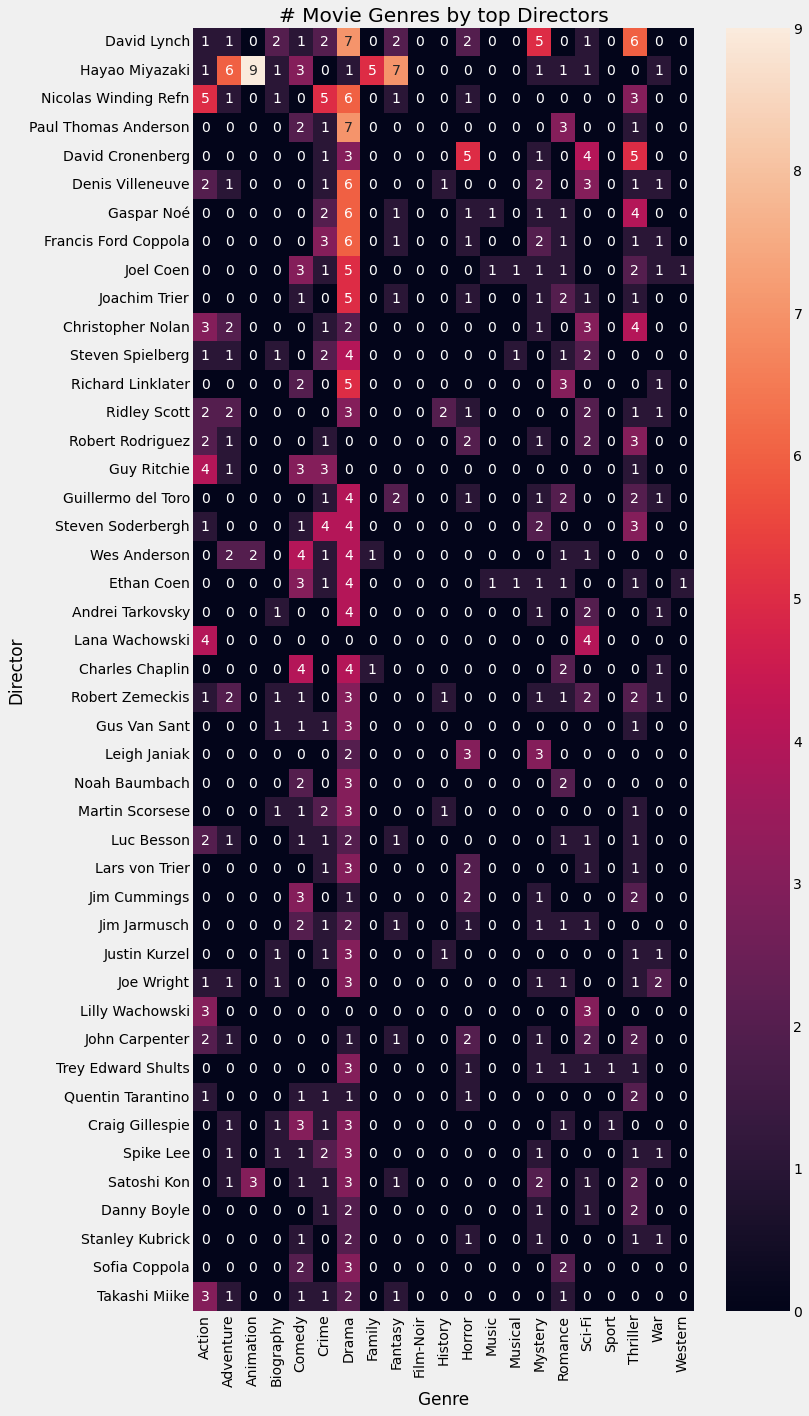

In [133]:
# Plot movie genres by top Directors
xsize = len(ct_genre_director.columns) // 2
ysize = len(ct_genre_director.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))

ax = sns.heatmap(ct_genre_director, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 
plt.title('# Movie Genres by top Directors');

In [134]:
# search data by director
director = 'Joachim Trier'
df[df['Director'].str.contains(director)].iloc[:,:-6]

Title  Year    imdbID      Rated  Runtime  \
426                         Thelma  2017   6304046  Not Rated      116   
667                        Reprise  2006   0827517          R      105   
826  The Worst Person in the World  2021  10370710          R      128   
865              Oslo, August 31st  2011   1736633  Not Rated       95   
866              Louder Than Bombs  2015   2217859          R      109   

                                                 Genre       Director  \
426  Drama, Fantasy, Horror, Mystery, Romance, Sci-...  Joachim Trier   
667                                              Drama  Joachim Trier   
826                             Comedy, Drama, Romance  Joachim Trier   
865                                              Drama  Joachim Trier   
866                                              Drama  Joachim Trier   

                                                Writer Cinematographer  \
426                          Eskil Vogt, Joachim Trier      Jakob Ihre   
667                          Eskil Vogt, Joachim Trier      Jakob Ihre   
826                          Eskil Vogt, Joachim Trier    Kasper Tuxen   
865  Eskil Vogt, Joachim Trier, Pierre Drieu La Roc...      Jakob Ihre   
866                          Eskil Vogt, Joachim Trier      Jakob Ihre   

                                                Actors  \
426  Eili Harboe, Kaya Wilkins, Henrik Rafaelsen, E...   
667  Anders Danielsen Lie, Espen Klouman Høiner, Vi...   
826  Renate Reinsve, Anders Danielsen Lie, Herbert ...   
865  Anders Danielsen Lie, Malin Crépin, Aksel Than...   
866  Gabriel Byrne, Isabelle Huppert, Jesse Eisenbe...   

                                                  Plot            Language  \
426  A confused religious girl tries to deny her fe...  Norwegian, Swedish   
667  Two competitive friends, fueled by literary as...           Norwegian   
826  The chronicles of four years in the life of Ju...           Norwegian   
865  One day in the life of Anders, a young recover...  Norwegian, English   
866  The fractious family of a father and his two s...     English, French   

                                    Country  Metascore  imdbRating  imdbVotes  \
426         Norway, France, Denmark, Sweden         74         7.0      30838   
667                                  Norway         79         7.3      10996   
826         Norway, France, Sweden, Denmark         90         7.9      28366   
865                 Norway, Denmark, Sweden         84         7.6      22570   
866  Norway, France, Denmark, United States         70         6.6      12954   

                                            Production           Timestamp  \
426  Motlys, Memento Films International, Film i Vä... 2021-02-01 21:08:00   
667  4 1/2 Film, Filmlance International AB, Spille... 2021-09-24 23:05:59   
826  Oslo Pictures, MK2 Productions, Film i Väst, S... 2022-01-18 23:15:20   
865  Motlys, Don't Look Now, Norsk Filminstitutt, N... 2022-02-16 23:37:30   
866  Motlys, Memento Films Production, Nimbus Film ... 2022-02-17 23:16:04   

          Date      Time  
426 2021-02-01  21:08:00  
667 2021-09-24  23:05:59  
826 2022-01-18  23:15:20  
865 2022-02-16  23:37:30  
866 2022-02-17  23:16:04

In [135]:
# Director average votes by movie
df_director_votes = df_director.copy()

df_director_votes = split_explode(df_director_votes, 'Director')
df_director_avg_votes = get_mean_value(df_director_votes, 'Director', 'imdbVotes')
df_director_avg_votes['imdbRating'] = get_mean_value(df_director_votes, 'Director', 'imdbRating')['imdbRating']
df_director_avg_votes['imdbVotes'] = df_director_avg_votes['Total'] * df_director_avg_votes['imdbVotes']

# Most votes
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nlargest(N, 'imdbVotes', keep='all'))

In [136]:
# Fewer votes
show_all(df_director_avg_votes[df_director_avg_votes.Total > 1].nsmallest(N, 'imdbVotes', keep='all'))

In [137]:
## Less known directors to follow
# more than 1 movie watched
# less votes than 50% quantile
# imdbRating average over 6
show_all(df_director_avg_votes[df_director_avg_votes['Total'] > 1][df_director_avg_votes['imdbVotes'] < df_director_avg_votes['imdbVotes'].quantile(0.5)][df_director_avg_votes['imdbRating'] > 6.0])

In [138]:
# Director / Cinematographer
df_director_cinema = df_director.copy()

gb_director_cinema_pair = double_group_info(df_director_cinema, 'Director', 'Cinematographer', 1)
show_all(gb_director_cinema_pair)

In [139]:
# Director / Actors
df_director_actor = df_director[['Director','Actors','Title','imdbRating']].copy()
df_director_actor = split_explode(df_director_actor, 'Director')
df_director_actor = split_explode(df_director_actor, 'Actors')

gb_director_actor_pair = double_group_info(df_director_actor, 'Director', 'Actors')
show_all(gb_director_actor_pair.nlargest(20, ('Title','count'), keep='all'))

In [140]:
# Director / Production
df_director_production = df_director.copy()

gb_director_production_pair = double_group_info(df_director_production, 'Director', 'Production', 1)
show_all(gb_director_production_pair)

## Writer

In [141]:
# Number of unique Writer (single or multiple)
len(counter_display(df,'Writer','Title', None).index)

1576

In [142]:
# Set writer dataframe
df_writer = df.copy()

df_writer['Writer'] = df_writer['Writer'].str.split(',').apply(lambda x: [e.strip() for e in x])
df_writer['Writer'] = df_writer['Writer'].apply(lambda x: list(set(x))) # remove duplicates
df_writer = explode(df_writer, ['Writer'])
df_writer = df_writer[~df_writer['Writer'].str.startswith('N/A')] # remove 'N/A'
# Drop documentaries
df_writer = df_writer[~df_writer['Genre'].isin(['Documentary'])]

In [143]:
# Highest rating writers
df_writer_rating = df_writer.copy()
df_writer_rating = get_mean_value(df_writer_rating, 'Writer', 'imdbRating')

# Writer with most movies watched
show_all(df_writer_rating.nlargest(N, 'Total', keep='all'))

In [144]:
# Writer with highest average rating, by movies watched (greater than 2)
show_all(df_writer_rating[df_writer_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

In [145]:
df_director_writer = df[~df['Genre'].str.contains('Documentary')].copy()

# Number of movies where the director was also the writer 
len(df_director_writer[df_director_writer['Director'] == df_director_writer['Writer']])

222

In [146]:
# Top Director/Writer
df_director_writer = df_writer.copy()

df_director_writer = split_explode(df_director_writer, 'Director')
gb_director_writer = df_director_writer[df_director_writer['Director'] == df_director_writer['Writer']].groupby('Director').agg({'Title':['count', '; '.join]})
show_all(gb_director_writer.nlargest(N,('Title','count'), keep='all'))

In [147]:
# Writer / Director
N = 10

df_writer_pair = df_director_writer.copy()

gb_writer_director_pair = double_group_info(df_writer_pair, 'Writer', 'Director', 1)
show_all(gb_writer_director_pair.nlargest(N, ('Title','count'), keep='all'))

In [148]:
# Best pairing Writer / Director based on imdbRating where the Writer is not the Director (it can also be but isn't considered)
# Top N
N = 20

df_writer_pair = df_director_writer.copy()

# drop Marvel directors (too many writers and not that interesting to me)
df_writer_pair = df_writer_pair[~df_writer_pair['Director'].isin(['Anthony Russo','Joe Russo','Jon Watts'])]

# Special double group
# group by 
gb_writer_pair = df_writer_pair.groupby(['Writer','Director']).agg({'Title':['count','; '.join],'imdbRating':'mean'})
gb_writer_pair['imdbRating'] = gb_writer_pair['imdbRating'] .round(2)
gb_writer_pair = gb_writer_pair[gb_writer_pair[('Title','count')] > 1].reset_index()
# Writer is not the Director
gb_writer_pair = gb_writer_pair[gb_writer_pair['Writer'] != gb_writer_pair['Director']].set_index(['Writer','Director'])
# Sort by imdbRating
gb_writer_pair = gb_writer_pair.nlargest(N, ('imdbRating','mean'), keep='all')

show_all(gb_writer_pair)

## Cinematographers

In [149]:
# Number of unique Cinematographer (single or multiple)
len(counter_display(df, 'Cinematographer', 'Title', None).index)

653

In [150]:
# Set cinematographer dataframe
cols = ['Title','Year','Runtime','Genre','Director','Cinematographer','imdbRating','Production','Date']

df_cinema = df[cols].copy()
df_cinema = df_cinema[~df_cinema['Cinematographer'].str.startswith('N/A')] # remove 'N/A'

In [151]:
# Highest rating cinematographers
df_cinema_rating = df_cinema.copy()
df_cinema_rating = get_mean_value(df_cinema_rating, 'Cinematographer', 'imdbRating')

# Cinematographers with most movies watched
show_all(df_cinema_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

In [152]:
# Cinematographer with highest average rating, by movies watched (greater than 2)
show_all(df_cinema_rating[df_cinema_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

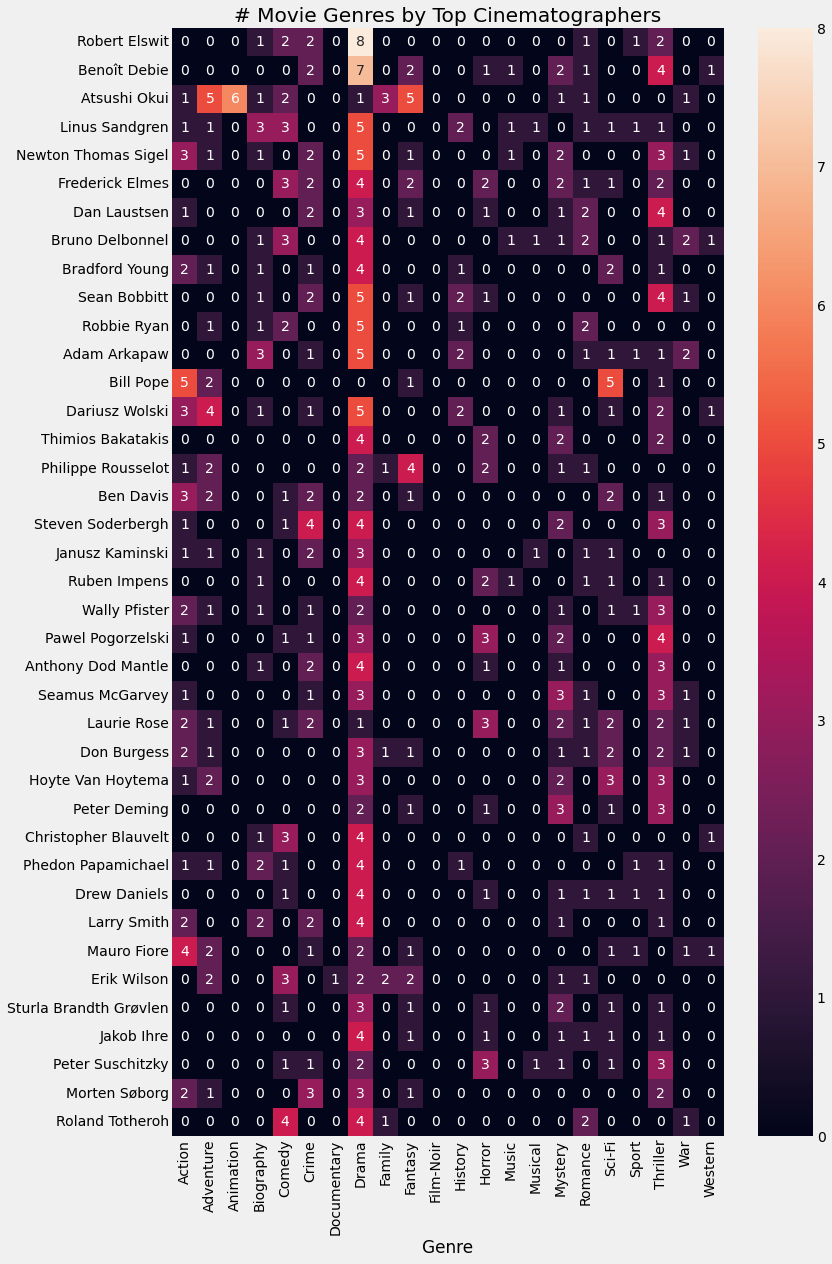

In [153]:
# Genre by Cinematographers
cols = ['Title','Cinematographer','Genre']
df_cinema_genre = df[cols].copy()

df_cinema_genre = split_explode(df_cinema_genre, 'Genre')
df_cinema_genre = split_explode(df_cinema_genre, 'Cinematographer')

cinema_movies = counter_display(df_cinema, 'Cinematographer', 'Title', N).index
plot_ct_cinema_genre = pd.crosstab(df_cinema_genre['Cinematographer'], df_cinema_genre['Genre']).loc[cinema_movies].iloc[1:,:]

# Plot
xsize = len(plot_ct_cinema_genre.columns) // 2
ysize = len(plot_ct_cinema_genre.index) // 2

fig, ax = plt.subplots(figsize=(xsize,ysize))
ax = sns.heatmap(plot_ct_cinema_genre, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('# Movie Genres by Top Cinematographers');

In [154]:
# Cinematographer / Director
N = 10

df_cinema_pair = df_cinema.copy()

gb_cinema_director_pair = double_group_info(df_cinema_pair, 'Cinematographer', 'Director', 1)
show_all(gb_cinema_director_pair.nlargest(N, ('Title','count'), keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

In [155]:
# Cinematographer / Director
df_cinema_director = df_cinema[['Cinematographer','Director','Title']].copy()
df_cinema_director = split_explode(df_cinema_director, 'Cinematographer')
df_cinema_director = split_explode(df_cinema_director, 'Director')

#gb_cinema_director = double_group_info(df_cinema_director, 'Cinematographer', 'Director')
#show_all(gb_cinema_director.nlargest(10, ('Title','count'), keep='all'))
gb_cinema_director = df_cinema_director.groupby(['Cinematographer','Director']).agg({'Title':['count','; '.join]})
show_all(gb_cinema_director[gb_cinema_director[('Title','count')] > 1])

## Actors

In [156]:
# Set actors dataframe
cols = ['Title','Year','Genre','Director','Actors','imdbRating']

df_actors = df[cols].copy()

# Filter documentaries
condition = 'Documentary'
query = "Genre not in '" + condition + "'"
df_actors = df_actors[cols].query(query).copy()

# Drop duplicates
df_actors.drop_duplicates(subset=['Title','Year','Director'], keep='first', inplace=True) # include director for cases likes Swan Song (2021)

# Drop list of 'too small role' - 'uncredited' actors with multiple appearances 
list_actors_drop = ['Mark Falvo','Arnold Montey','Rosemary Howard','Jimmy Star',
                    'Joseph Oliveira','Bridget Hoffman','Kadrolsha Ona Carole','Richard Price',
                    'Doris McCarthy','Bern Collaço','Dee Bradley Baker','Jorge Leon Martinez',
                    'John Gettier','Jeffrey Neil','David Evestaff','Martin Palmer',
                    'Stan Lee','J. Nathan Simmons','Michael E. Stogner','John W. Iwanonkiw',
                    'Richard Nixon','John F. Kennedy','Lyndon B. Johnson', # US presidents appear a few times in documentaries
                    'Walter Cronkite']

df_actors['Actors'] = df_actors['Actors'].str.replace(', |'.join(list_actors_drop), '')
df_actors['Actors'] = df_actors['Actors'].str.replace(' ,','')

In [157]:
df_counter_actors = counter_display(df_actors, 'Actors', 'Title', None)

# Number of actors
len(df_counter_actors.index)

41022

In [158]:
# Top N actors
N = 20
df_top_actors = df_counter_actors.copy()

top_actors = df_top_actors.nlargest(N, 'Title', keep='all')
top_actors

Title
Willem Dafoe               17
Adam Driver                14
Keanu Reeves               14
Bill Murray                13
Brad Pitt                  12
Ryan Gosling               12
Bruce Willis               11
Benedict Cumberbatch       11
Matt Damon                 11
Laurence Fishburne         11
Philip Seymour Hoffman     10
Samuel L. Jackson          10
Timothée Chalamet          10
Jesse Plemons              10
J.K. Simmons               10
Tilda Swinton              10
Udo Kier                    9
Alfred Molina               9
Mark Ruffalo                9
Laura Dern                  9
Scarlett Johansson          9
Benedict Wong               9
Bill Camp                   9
Cate Blanchett              9
Nicolas Cage                9
Ben Mendelsohn              9

In [159]:
# Get list of top n actors
list_top_actors = top_actors.index.values
list_top_actors.sort()

# filtering by list of top actors
df_actor_rating = get_mean_value(df_actors, 'Actors', 'imdbRating')

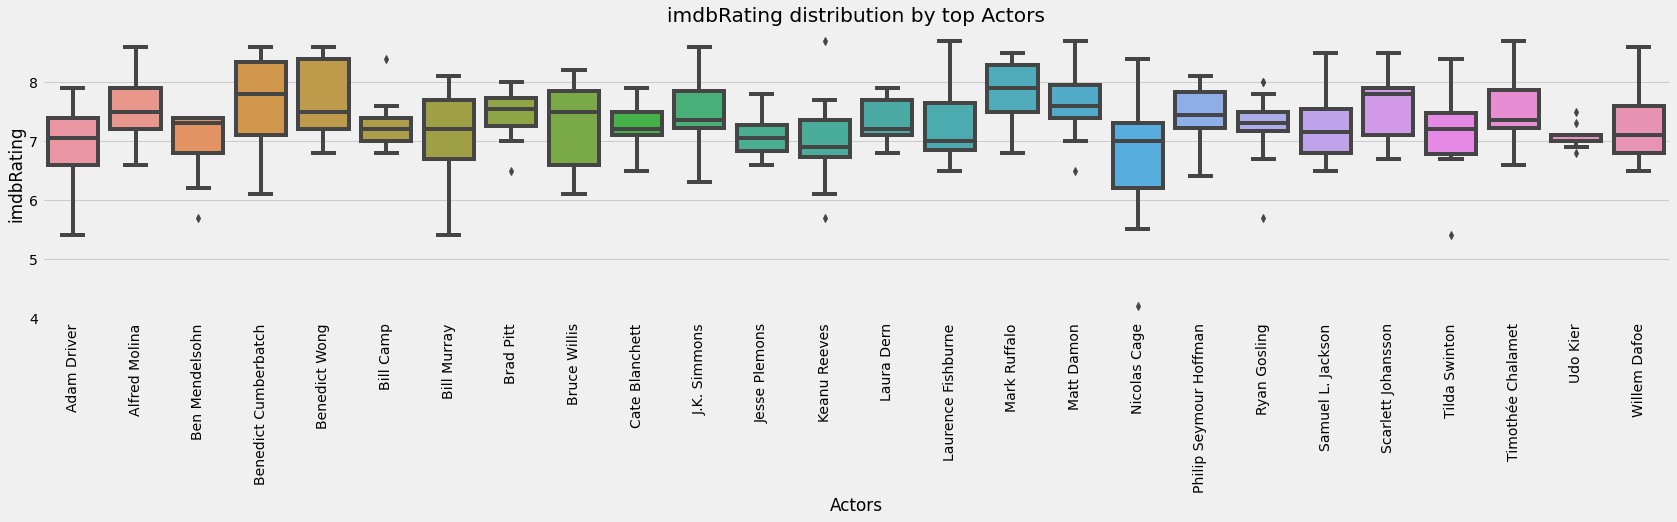

In [160]:
# Movie rating distribution by top Actors
df_dist_top_actor = df_actors.copy()

df_dist_top_actor = split_explode(df_dist_top_actor, 'Actors')    
df_dist_top_actor = df_dist_top_actor[df_dist_top_actor['Actors'].str.contains('|'.join(list_top_actors))]
df_dist_top_actor = df_dist_top_actor[['Actors','imdbRating']].sort_values(by='Actors')

x = df_dist_top_actor['Actors']
y = df_dist_top_actor['imdbRating']

# Plot
ratings = [1,10]
xsize = len(x.unique())
ysize = ratings[1] // 2

_, ax = plt.subplots(figsize=(xsize,ysize))
sns.boxplot(x, y)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) 

plt.title('imdbRating distribution by top Actors')
plt.show()

In [161]:
# Actors with most movies watched
show_all(df_actor_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset='imdbRating').set_precision(2))

In [162]:
# Highest rating actors
show_all(df_actor_rating[df_actor_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all')) # multiple results from The Godfather trilogy

In [163]:
# Lowest rating actors
show_all(df_actor_rating[df_actor_rating['Total'] > 1].nsmallest(N, 'imdbRating', keep='all'))

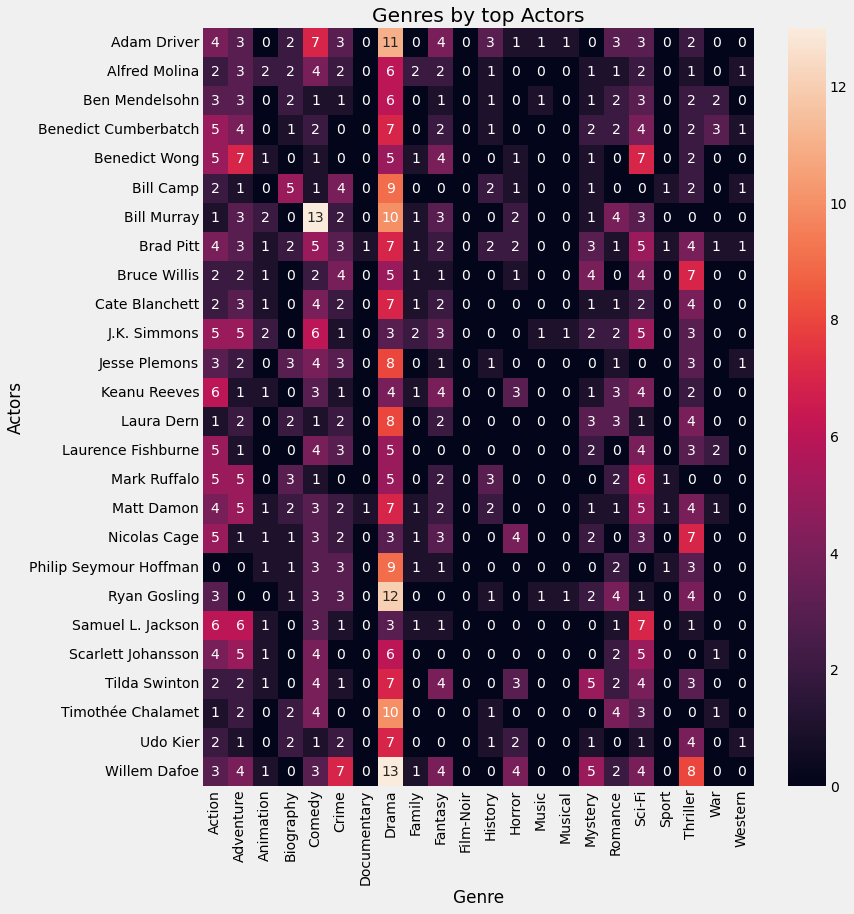

In [164]:
# Genre by Actor
df_genre_actor = df_actors.copy()

cols = ['Genre','Actors']
for col in cols:
    df_genre_actor = split_explode(df_genre_actor, col)

# Top actors
plot_ct_actor_genre = pd.crosstab(df_genre_actor['Actors'], df_genre_actor['Genre']).loc[list_top_actors]

# Plot
xsize = len(plot_ct_actor_genre.columns) // 2
ysize = len(plot_ct_actor_genre.index) // 2

_, ax = plt.subplots(figsize=(xsize,ysize))

plt.title('Genres by top Actors')
ax = sns.heatmap(plot_ct_actor_genre, annot=True, fmt="d")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

In [165]:
# Top actor in each genre
df_genre_top_actor = df_genre_actor.groupby(['Actors','Genre']).agg({'Title':['count','; '.join]}).sort_values(('Title','count'), ascending=False).reset_index()
df_genre_top_actor = df_genre_top_actor.groupby('Genre').apply(lambda x: x.nlargest(1, ('Title','count'), keep='first'))
df_genre_top_actor = df_genre_top_actor.droplevel(1).drop('Genre', axis=1)

show_all(df_genre_top_actor)

In [166]:
## search by specific actor
#df[df.Actors.str.contains('Tom Holland')] # Tom Holland != Tom Hollander

In [167]:
# Common Actors pairing
df_actors_pairs = pairing(df_actors, 'Actors')

## TOO MANY ADDITIONAL CREW ACTORS
# Show top pairs
N = 10
show_all(df_actors_pairs.nlargest(N, 'Count', keep='all'))

## Country

In [168]:
# Set country dataframe
cols = ['Title','Year','Director','Language','Country','imdbRating','Date']

df_country = df[cols].copy()

In [169]:
# Number of different countries
df_country_counter = counter_display(df_country, 'Country', 'Title', None)

len(df_country_counter.index)

65

In [170]:
# Country of last watched movies
N = 10

df_country.tail(N)

Title  Year                  Director  \
893               Comet  2014                Sam Esmail   
894            Plus One  2019  Jeff Chan, Andrew Rhymer   
895        Petite Maman  2021            Céline Sciamma   
896            Pleasure  2021             Ninja Thyberg   
897      It Chapter Two  2019           Andy Muschietti   
898            Ravenous  1999              Antonia Bird   
899  A Bittersweet Life  2005              Jee-woon Kim   
900           They Live  1988            John Carpenter   
901          The Hidden  1987              Jack Sholder   
902          Studio 666  2022              BJ McDonnell   

                                    Language  \
893                                  English   
894                                  English   
895                                   French   
896                         English, Swedish   
897  English, North American Indian, Spanish   
898        English, Italian, Spanish, Washoe   
899                          Korean, Russian   
900                                  English   
901                                  English   
902                                  English   

                                            Country  imdbRating       Date  
893                                   United States         6.7 2022-03-15  
894                                   United States         6.6 2022-03-16  
895                                          France         7.4 2022-03-17  
896                     Sweden, Netherlands, France         6.3 2022-03-18  
897                                   United States         6.5 2022-03-19  
898  United Kingdom, Mexico, United States, Czechia         6.9 2022-03-19  
899                                     South Korea         7.5 2022-03-20  
900                                   United States         7.2 2022-03-21  
901                                   United States         7.0 2022-03-21  
902                                   United States         5.8 2022-03-22

In [171]:
# Top countries
TOP = 30

# Simple solution without filtering by year 
#df_country_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_country_counter_year = counter_display(df_country[df_country['Date'].dt.year == year], 'Country', 'Title', None).copy()
        df_country_counter_year = df_country_counter_year.reset_index()
        df_country_counter_year.columns = ['index', year]
    else:
        add_country = counter_display(df_country[df_country['Date'].dt.year == year], 'Country', 'Title', None).reset_index()
        add_country.columns = ['index',year]
        # merge new year counter
        df_country_counter_year = df_country_counter_year.merge(add_country, how='outer', on='index')

df_country_counter_year.rename(columns={'index':'Country'}, inplace=True)
df_country_counter_year.set_index('Country', inplace=True)
df_country_counter_year = df_country_counter_year.fillna(0).astype(int)

# add 'All' column with sum by country
df_country_counter_year.loc[:,'All'] = df_country_counter_year.sum(axis=1)
# show TOP countries
df_country_counter_year = df_country_counter_year.nlargest(TOP, 'All', keep='all')

df_country_counter_year.style.background_gradient(subset=df_country_counter_year.columns[:-1], axis=1) # evaluate by country

# Top 2 countries always US and UK
# 2021 holds most top results per country since it was the year with clearly most movies watched

In [172]:
# Countries with higher average rating
df_country_rat = get_mean_value(df_country, 'Country', 'imdbRating')

# List of top countries
top_countries = df_country_counter.index[:3] # drop top 3 countries - most common

df_country_filter = df_country_rat.reset_index() 
df_country_filter = df_country_filter[~df_country_filter['Country'].isin(top_countries)].set_index('Country')

## 50% quantile
#qtl05 = df_country_counter.quantile(0.5)[0]
df_top_country_rat = df_country_filter[df_country_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_country_rat)

In [173]:
# Country / Director
df_country_director = df_country.copy()

gb_country_director_pair = double_group_info(df_country_director, 'Country', 'Director')
show_all(gb_country_director_pair)

## Language

In [174]:
# Set language dataframe
cols = ['Title','Year','Director','imdbRating','Language','Date']

df_language = df[cols].copy()

In [175]:
# Number of different languages
df_language_counter = counter_display(df, 'Language', 'Title', None)

len(df_language_counter.index)

99

In [176]:
# Language of last watched movies
N = 10

df_language.tail(N)

Title  Year                  Director  imdbRating  \
893               Comet  2014                Sam Esmail         6.7   
894            Plus One  2019  Jeff Chan, Andrew Rhymer         6.6   
895        Petite Maman  2021            Céline Sciamma         7.4   
896            Pleasure  2021             Ninja Thyberg         6.3   
897      It Chapter Two  2019           Andy Muschietti         6.5   
898            Ravenous  1999              Antonia Bird         6.9   
899  A Bittersweet Life  2005              Jee-woon Kim         7.5   
900           They Live  1988            John Carpenter         7.2   
901          The Hidden  1987              Jack Sholder         7.0   
902          Studio 666  2022              BJ McDonnell         5.8   

                                    Language       Date  
893                                  English 2022-03-15  
894                                  English 2022-03-16  
895                                   French 2022-03-17  
896                         English, Swedish 2022-03-18  
897  English, North American Indian, Spanish 2022-03-19  
898        English, Italian, Spanish, Washoe 2022-03-19  
899                          Korean, Russian 2022-03-20  
900                                  English 2022-03-21  
901                                  English 2022-03-21  
902                                  English 2022-03-22

In [177]:
# Top languages
TOP = 30

# Simple solution without filtering by year 
#df_language_counter.nlargest(N, 'Title', keep='all')

# create dataframe
for year in years:
    if year == years[0]:
        df_language_counter_year = counter_display(df_language[df_language['Date'].dt.year == year], 'Language', 'Title', None).copy()
        df_language_counter_year = df_language_counter_year.reset_index()
        df_language_counter_year.columns = ['index', year]
    else:
        add_language = counter_display(df_language[df_language['Date'].dt.year == year], 'Language', 'Title', None).reset_index()
        add_language.columns = ['index',year]
        # merge new year counter
        df_language_counter_year = df_language_counter_year.merge(add_language, how='outer', on='index')

df_language_counter_year.rename(columns={'index':'Language'}, inplace=True)
df_language_counter_year.set_index('Language', inplace=True)
df_language_counter_year = df_language_counter_year.fillna(0).astype(int)

# add 'All' column with sum by language
df_language_counter_year.loc[:,'All'] = df_language_counter_year.sum(axis=1)
# show TOP languages
df_language_counter_year = df_language_counter_year.nlargest(TOP, 'All', keep='all')

df_language_counter_year.style.background_gradient(subset=df_language_counter_year.columns[:-1], axis=1) # evaluate by languange

In [178]:
# Language average rating
df_language_rat = get_mean_value(df_language, 'Language', 'imdbRating')

# List top languages
top_countries = df_language_counter.index[:3] # drop top 3 languages (english, french, spanish)

df_language_filter = df_language_rat.reset_index() 
df_language_filter = df_language_filter[~df_language_filter['Language'].isin(top_countries)].set_index('Language')

## 50% quantile
#qtl05 = df_language_counter.quantile(0.5)[0]
df_top_language_rat = df_language_filter[df_language_filter.Total > 3].nlargest(N, 'imdbRating', keep='all')

show_all(df_top_language_rat)

In [179]:
# Language / Director
df_language_director = df_language.copy()

gb_language_director_pair = double_group_info(df_language_director, 'Language', 'Director')
show_all(gb_language_director_pair)

## Rating

In [180]:
# Example
# https://codingnomads.co/blog/data-analysis-example-analyzing-movie-ratings-with-python/

In [181]:
# Set rating dataframe
cols = ['Title','Year','Runtime','Genre','Language','Metascore','imdbRating','imdbVotes','Date']

df_rating = df[cols].copy()

In [182]:
# imdbRating and Metascore stats
df_rating[['imdbRating', 'Metascore']][df['Metascore'] != 0].describe().round(2)

imdbRating  Metascore
count      794.00     794.00
mean         7.15      71.43
std          0.66      12.67
min          3.60       9.00
25%          6.70      64.00
50%          7.10      72.00
75%          7.57      81.00
max          9.20     100.00

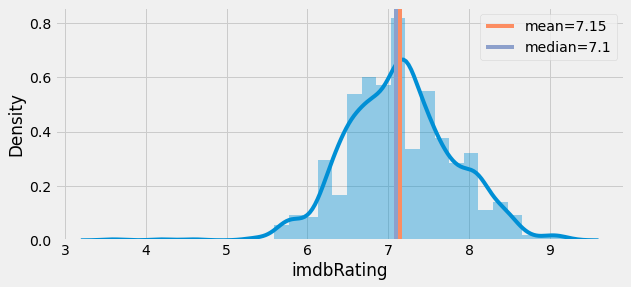

In [183]:
# imdbRating distribution
# Plot imdbRating
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)

plot_rating = df_rating['imdbRating']

ax1 = sns.distplot(plot_rating, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_rating.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rating.mean(), 2)}")
ax1.axvline(x=plot_rating.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rating.median(), 2)}")
plt.legend();

In [184]:
## https://en.wikipedia.org/wiki/Kurtosis
# Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution 
# and corresponding ways of estimating it from a sample from a population
plot_rating.kurtosis()

1.0895511997652845

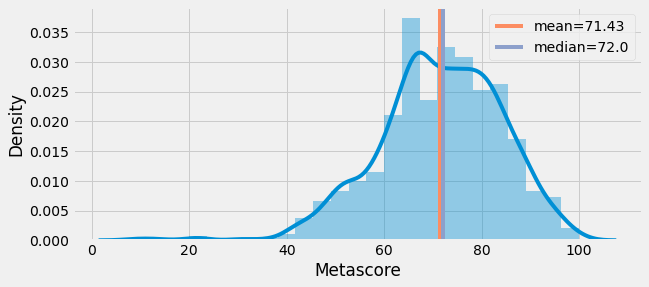

In [185]:
# Metascore distribution
# Plot Metascore
plot_meta = df_rating[df_rating['Metascore'] != 0]['Metascore']

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)

ax1 = sns.distplot(plot_meta, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_meta.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_meta.mean(), 2)}")
ax1.axvline(x=plot_meta.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_meta.median(), 2)}")
plt.legend();

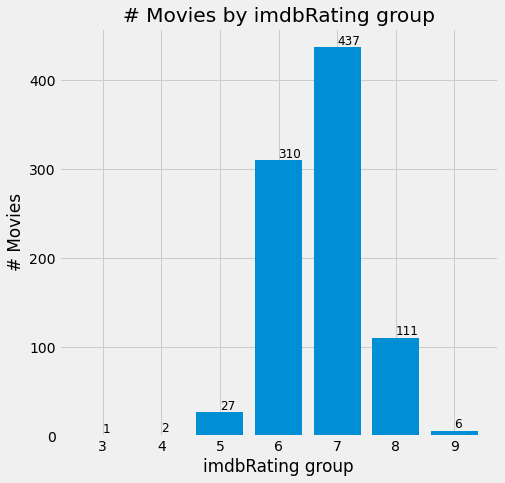

In [186]:
# Number of movies by imdbRating group
df_rating_group = df_rating[['Title', 'imdbRating']].groupby((df_rating['imdbRating']//1)).agg({'Title': 'count'})

x = df_rating_group.index
y = df_rating_group['Title']

# Plot
xsize = len(x)
ysize = len(y)

plt.figure(figsize=(xsize,ysize))
plt.bar(x,y)

for i, rate in enumerate(y):
    plt.text(i+3, rate+3, rate, fontdict={'fontsize':12})

plt.title('# Movies by imdbRating group')
plt.xlabel('imdbRating group')
plt.ylabel('# Movies')
plt.show()

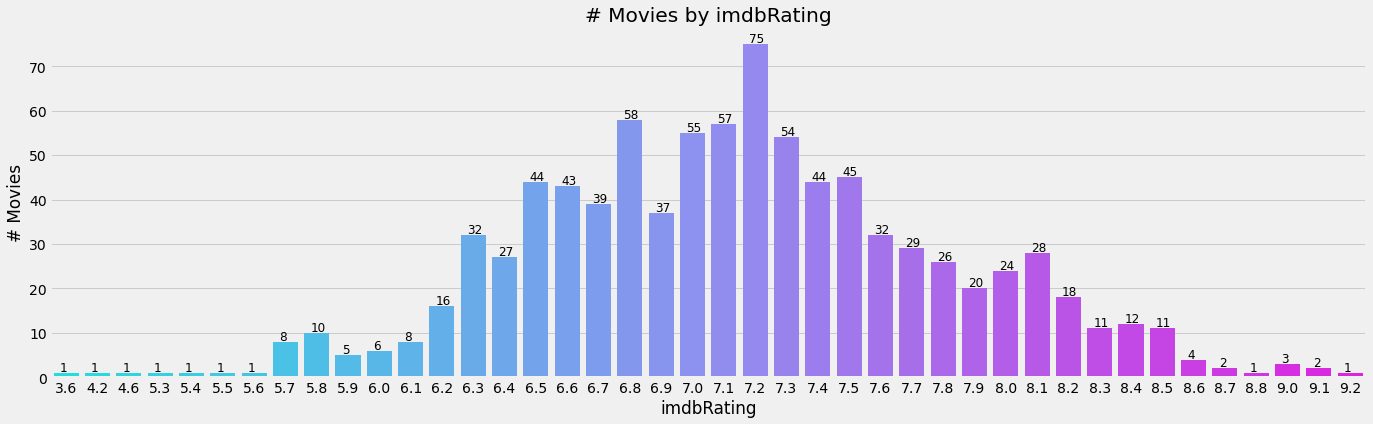

In [187]:
# Number of movies by imdbRating value
df_rating_float = df_rating[['Title', 'imdbRating']].groupby((df_rating['imdbRating'])).agg({'Title': 'count'})

x = np.round(df_rating_float.index, 1)
y = df_rating_float.Title

# Plot
xsize = len(df_rating_float.index) // 2

plt.figure(figsize=(xsize,6))
sns.barplot(x=x, y=y, palette="cool");

for i, rate in enumerate(y):
    plt.text(i-0.2, rate+0.4, rate, fontdict={'fontsize':12})

plt.title('# Movies by imdbRating')
plt.ylabel('# Movies')
plt.show()

In [188]:
# search by rating
rating = 6

gb_rating_below = df_rating[df_rating['imdbRating'] < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating').groupby('imdbRating').agg({'Title':'; '.join})
show_all(gb_rating_below)

In [189]:
# Movies watched this year below rating (see above)
df_rating[df_rating['Date'].dt.year == current_year][df_rating['imdbRating'] < rating][['Title','Runtime','imdbRating']].sort_values(by='imdbRating')

Title  Runtime  imdbRating
841  Prisoners of the Ghostland      103         4.2
814                  Lost River       95         5.7
840        The Greasy Strangler       93         5.7
892            Save Yourselves!       93         5.7
902                  Studio 666      106         5.8
864            Uncle Peckerhead       97         5.9
870                         Cam       94         5.9

In [190]:
# Movies with highest rating watched this year
df_current_year = df_rating[df_rating['Date'].dt.year == current_year]

# no documentaries, no duplicated
df_current_year = df_current_year[~df_current_year['Genre'].str.contains('Documentary')][~df.duplicated(['Title','Year'], keep='last')]
df_current_year.nlargest(N, 'imdbRating', keep='all')

Title  Year  Runtime  \
795             Interstellar  2014      169   
889  Spider-Man: No Way Home  2021      148   
806              City Lights  1931       87   
810             Modern Times  1936       87   
853                  Amadeus  1984      160   
873       The Great Dictator  1940      125   
801                  The Kid  1921       68   
891       Lawrence of Arabia  1962      218   
797             Sherlock Jr.  1924       45   
798              The General  1926       67   

                                     Genre                         Language  \
795               Adventure, Drama, Sci-Fi                          English   
889     Action, Adventure, Fantasy, Sci-Fi                          English   
806                 Comedy, Drama, Romance                    None, English   
810                 Comedy, Drama, Romance                          English   
853                Biography, Drama, Music  English, Italian, Latin, German   
873                     Comedy, Drama, War        English, Esperanto, Latin   
801                  Comedy, Drama, Family                          English   
891       Adventure, Biography, Drama, War         English, Arabic, Turkish   
797                Action, Comedy, Romance                    None, English   
798  Action, Adventure, Comedy, Drama, War                          English   

     Metascore  imdbRating  imdbVotes       Date  
795         74         8.7    1707089 2022-01-01  
889         71         8.6     539929 2022-03-12  
806         99         8.5     180503 2022-01-05  
810         96         8.5     235595 2022-01-09  
853         88         8.4     391227 2022-02-06  
873          0         8.4     218787 2022-02-24  
801          0         8.3     123711 2022-01-03  
891        100         8.3     286185 2022-03-13  
797          0         8.2      48002 2022-01-01  
798          0         8.2      89253 2022-01-01

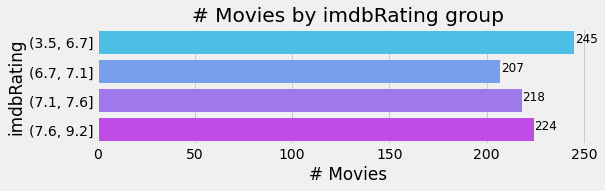

In [191]:
# Number of movies by imdbRating group

# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_rating['imdbRating'], q=4, precision=1, retbins=True) # 4 for quartiles
ratings_avg = df_rating.groupby(groups).agg({"Title": 'count'})

# Plot
ysize = len(ratings_avg) // 2

plt.figure(figsize=(8,ysize))
sns.barplot(y=ratings_avg.index, x=ratings_avg['Title'], palette='cool')
plt.title('# Movies by imdbRating group')
plt.xlabel('# Movies')

for i, rate in enumerate(ratings_avg["Title"]):
    plt.text(rate+0.1, i, rate, fontdict={'fontsize':12})

plt.show()

In [192]:
# Movies ranked in the 25th percentile minus 2 standard deviations
qtl_2std = df_rating['imdbRating'].quantile(0.25) - 2*df_rating['imdbRating'].std()
df_rating[df_rating['imdbRating'] < qtl_2std]

Title  Year  Runtime  \
169                        Geostorm  2017      109   
193                        The Room  2003       99   
204  The First Temptation of Christ  2019       46   
841      Prisoners of the Ghostland  2021      103   

                                 Genre  \
169           Action, Sci-Fi, Thriller   
193                              Drama   
204                             Comedy   
841  Action, Fantasy, Sci-Fi, Thriller   

                                        Language  Metascore  imdbRating  \
169  English, Cantonese, Russian, Hindi, Spanish         21         5.3   
193                                      English          9         3.6   
204                                   Portuguese          0         4.6   
841          English, Japanese, Mandarin, French         53         4.2   

     imdbVotes       Date  
169     104779 2020-03-21  
193      87707 2020-04-22  
204       3381 2020-05-04  
841       9683 2022-01-28

### Hidden Gems

In [193]:
# Select columns and data
df_hidden_gems = df_rating.copy()

# General filter
df_hidden_gems = df_hidden_gems[df_hidden_gems['Year'] < current_year-1]
df_hidden_gems = df_hidden_gems[~df_hidden_gems['Genre'].str.contains('Documentary')]

df_hidden_gems['Metascore'].replace('N/A', 0, regex=True, inplace=True)
df_hidden_gems['Metascore'] = df_hidden_gems['Metascore'].astype(int)

# Sum imdbRating with normalized metascore to create a global rating
df_hidden_gems['Rate20'] = df_hidden_gems['imdbRating'] + (df_hidden_gems['Metascore'] / 10)

# Stats
df_hidden_gems_stats = df_hidden_gems.describe().round(1)
# Select columns to show statistics
cols = df_hidden_gems_stats.columns.values
cols = np.delete(cols, [3,5])
# Show
df_hidden_gems_stats[cols] = df_hidden_gems_stats[cols].astype(int)
df_hidden_gems_stats

Year  Runtime  Metascore  imdbRating  imdbVotes  Rate20
count   746      746        746       746.0        746   746.0
mean   2009      111         64         7.1     163569    13.6
std      14       21         24         0.7     254975     2.7
min    1921       41          0         3.6        676     4.5
25%    2006       96         61         6.7      21208    12.9
50%    2016      108         70         7.1      73577    14.0
75%    2018      123         80         7.6     195122    15.3
max    2020      218        100         9.2    2524553    19.2

In [194]:
# Filter by number of votes and rating
vote_qtl = df_hidden_gems['imdbVotes'].quantile(0.25) # less than 25% quantile of votes
rate20_qtl = df_hidden_gems['Rate20'].quantile(0.35) # more than 35% quantile of rate20 (imdbRating + Metascore*)

df_hidden_gems = df_hidden_gems[df_hidden_gems['imdbVotes'] < vote_qtl][df_hidden_gems['Rate20'] > rate20_qtl]

# Hidden gems watched by Year
[
    [
        print(str(year)),
        show_all(df_hidden_gems[df_hidden_gems['Date'].dt.year == year].nlargest(20, 'Rate20', keep='all')),
        print('\n')
    ] for year in years
];

2018




2019




2020




2021




2022


### Runtime / imdbRating

In [195]:
# Correlation?
df_rating[['Runtime','imdbRating']].corr(method='pearson').round(2)

Runtime  imdbRating
Runtime        1.00        0.27
imdbRating     0.27        1.00

In [196]:
# Stats
df_runtime_rating = df_rating[['Runtime','imdbRating']].copy()
df_runtime_rating.describe().round(1)

Runtime  imdbRating
count    894.0       894.0
mean     110.3         7.1
std       21.8         0.7
min       40.0         3.6
25%       95.0         6.7
50%      107.0         7.1
75%      123.0         7.6
max      218.0         9.2

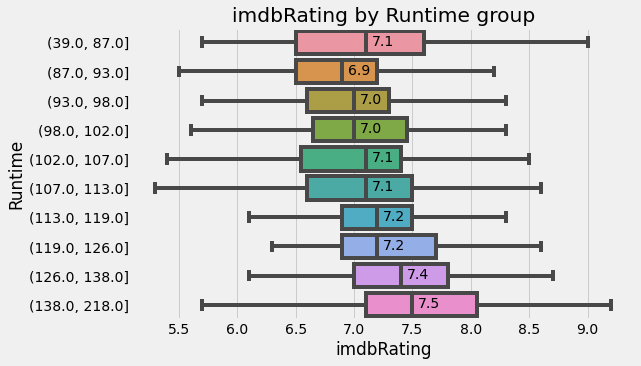

In [197]:
# https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
[groups, edges] = pd.qcut(df_runtime_rating['Runtime'], 10, precision=0, retbins=True)
ratings_avg = df_runtime_rating.groupby(groups).agg({"imdbRating": np.median})

# Plot
ysize = len(ratings_avg) // 2

plt.figure(figsize=(8,ysize))
sns.boxplot(y=groups, x="imdbRating", data=df_runtime_rating, orient="h", showfliers=False)

for i, rate in enumerate(ratings_avg["imdbRating"]):
    plt.text(rate+0.05, i+0.1, round(rate,1))

plt.title('imdbRating by Runtime group')
plt.show()

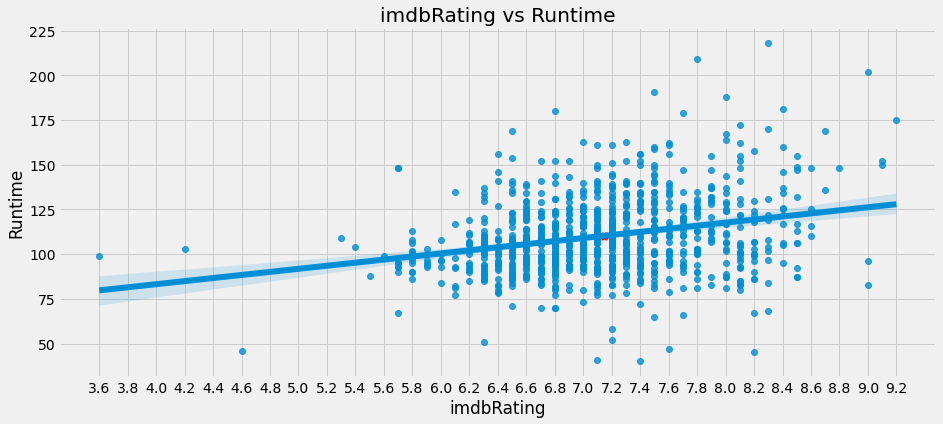

In [198]:
# Movie centroid based on runtime and imdbRating
x = df_runtime_rating['imdbRating']
y = df_runtime_rating['Runtime']
centroid = df_runtime_rating.mean(axis=0) # centroid

# Plot
xticks = np.arange(x.min(), x.max()+0.1, step=0.2)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))  
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(xticks)
plt.title('imdbRating vs Runtime')
plt.show()

In [199]:
# https://stackoverflow.com/questions/45418353/get-nearest-coordinates-from-pandas-df-from-centroid-of-coordinates

# The center will just be the average x and y 
# plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()
#df.loc[plotme.loc[[plotme.sub(plotme.mean()).pow(2).sum(1).idxmin()]].index]

centroid

Runtime       110.276286
imdbRating      7.145190
dtype: float64

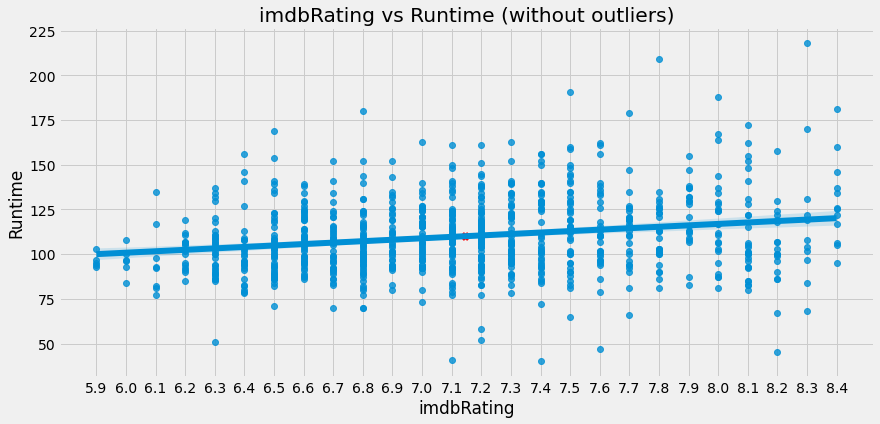

In [200]:
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
# Movie centroid based on runtime and imdbRating
# without outliers
df_runtime_rating_out = df_runtime_rating[np.abs(df_runtime_rating['imdbRating'] - df_runtime_rating['imdbRating'].mean()) <= (2*df_runtime_rating['imdbRating'].std())] # 2 std

x = df_runtime_rating_out['imdbRating']
y = df_runtime_rating_out['Runtime']
centroid_out = df_runtime_rating_out.mean(axis=0) # centroid

# Plot
xticks = np.arange(x.min(), x.max()+0.1, step=0.1)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=x, y=y); 
plt.scatter(centroid[1], centroid[0], color='r', marker='x');

plt.xticks(xticks)
plt.title('imdbRating vs Runtime (without outliers)')
plt.show()

In [201]:
# There's no big difference without outliers
centroid_out

Runtime       110.084024
imdbRating      7.149704
dtype: float64

In [202]:
# Movie closer to centroid, based on runtime and imdbRating
# sub - subtract mean runtime and rating values
# pow - exponential power
# sum - sum both columns (runtime, imdbRating)
# idxmin - get id of min value
id_min_diff = df_runtime_rating_out.sub(df_runtime_rating_out.mean()).pow(2).sum(1).idxmin()
df.loc[df_runtime_rating_out.loc[[id_min_diff]].index].iloc[:,:-6]

Title  Year   imdbID Rated  Runtime  Genre        Director  \
462  Palmer  2021  6857376     R      110  Drama  Fisher Stevens   

               Writer        Cinematographer  \
462  Cheryl Guerriero  Tobias A. Schliessler   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   

                                                  Plot Language  \
462  An ex-convict strikes up a friendship with a b...  English   

           Country  Metascore  imdbRating  imdbVotes  \
462  United States         53         7.2      32806   

                                            Production           Timestamp  \
462  Sidney Kimmel Entertainment, Hercules Film Fun... 2021-02-28 23:31:37   

          Date      Time  
462 2021-02-28  23:31:37

In [203]:
# Three closest movies to centroid (runtime / rating)
id_min_3diff = df_runtime_rating_out.sub(df_runtime_rating_out.mean()).pow(2).sum(1).nsmallest(3).index
df.loc[df_runtime_rating_out.loc[id_min_3diff].index].iloc[:,:-6]

Title  Year   imdbID      Rated  Runtime  \
462  Palmer  2021  6857376          R      110   
77   Border  2018  5501104          R      110   
518  Pusher  1996  0117407  Not Rated      110   

                                                 Genre              Director  \
462                                              Drama        Fisher Stevens   
77   Crime, Drama, Fantasy, Mystery, Romance, Thriller            Ali Abbasi   
518                                    Crime, Thriller  Nicolas Winding Refn   

                                                Writer        Cinematographer  \
462                                   Cheryl Guerriero  Tobias A. Schliessler   
77   Isabella Eklöf, Ali Abbasi, John Ajvide Lindqvist          Nadim Carlsen   
518                    Jens Dahl, Nicolas Winding Refn          Morten Søborg   

                                                Actors  \
462  Justin Timberlake, Ryder Allen, Alisha Wainwri...   
77   Eva Melander, Eero Milonoff, Jörgen Thorsson, ...   
518  Kim Bodnia, Zlatko Buric, Laura Drasbæk, Slavk...   

                                                  Plot  \
462  An ex-convict strikes up a friendship with a b...   
77   A customs officer who can smell fear develops ...   
518  A drug pusher grows increasingly desperate aft...   

                              Language          Country  Metascore  \
462                            English    United States         53   
77                    Swedish, English  Sweden, Denmark         75   
518  Danish, Swedish, Serbian, English          Denmark         72   

     imdbRating  imdbVotes                                         Production  \
462         7.2      32806  Sidney Kimmel Entertainment, Hercules Film Fun...   
77          7.0      28559  Meta Film Stockholm, Black Spark Film & TV, Kä...   
518         7.3      38908                               Balboa Entertainment   

              Timestamp       Date      Time  
462 2021-02-28 23:31:37 2021-02-28  23:31:37  
77  2019-03-16 00:32:00 2019-03-16  00:32:00  
518 2021-04-19 23:40:57 2021-04-19  23:40:57

### Metascore / imdbRating

In [204]:
df_metaimdb = df_rating[~df_rating['Metascore'].isnull()]
df_metaimdb = df_metaimdb[df_metaimdb['Metascore'] != 0]
df_metaimdb['Metascore'] = df_metaimdb['Metascore'].fillna(0).astype(int)

# Correlation?
df_metaimdb[['Metascore','imdbRating']].corr(method='pearson').round(2)

Metascore  imdbRating
Metascore         1.0         0.5
imdbRating        0.5         1.0

In [205]:
# Convert Metascore to range 0-10
df_metaimdb['Meta10'] = df_metaimdb['Metascore'] / 10
# Difference between imdbRating and normalized Metascore
df_metaimdb['imdbMeta'] = df_metaimdb['imdbRating'] - df_metaimdb['Meta10']

# Reorder and select
cols = ['Title','Year','Genre','imdbRating','Meta10','imdbMeta']
df_metaimdb = df_metaimdb[cols]
df_metaimdb['Year'] = df_metaimdb['Year'].astype(int)

# Stats
df_metaimdb[['imdbRating','Meta10','imdbMeta']].describe().round(2)

imdbRating  Meta10  imdbMeta
count      794.00  794.00     794.0
mean         7.15    7.14       0.0
std          0.66    1.27       1.1
min          3.60    0.90      -2.4
25%          6.70    6.40      -0.8
50%          7.10    7.20      -0.1
75%          7.57    8.10       0.7
max          9.20   10.00       5.1

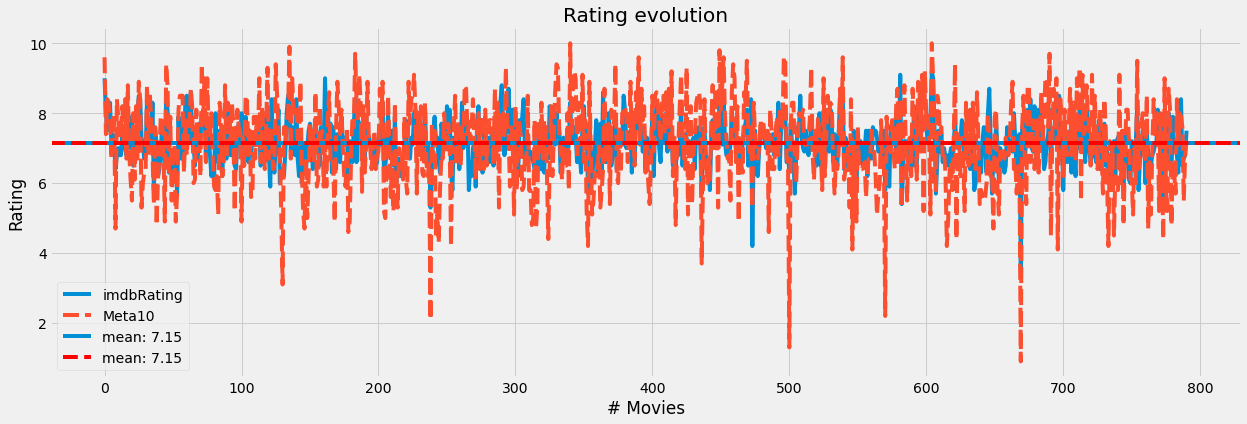

In [206]:
# imdbRating vs Meta10 variance
cols = ['Title','imdbRating','Meta10']
plot_imdbVSmeta = df_metaimdb[cols].groupby('Title').mean()
plot_imdbVSmeta = plot_imdbVSmeta.reset_index(drop=True)

x = plot_imdbVSmeta['imdbRating']
y = plot_imdbVSmeta['Meta10']

# Plot
xsize = len(x) // 40

plt.figure(figsize=(xsize,6))
sns.lineplot(data=plot_imdbVSmeta)

xlabel = 'mean: ' + str(round(x.mean(),2))
plt.axhline(y=x.mean(), label=xlabel)
ylabel = 'mean: ' + str(round(y.mean(),2))
plt.axhline(y=y.mean(), color='red', ls='--', label=ylabel)

plt.title('Rating evolution')
plt.xlabel('# Movies')
plt.ylabel('Rating')

plt.legend()
plt.show()

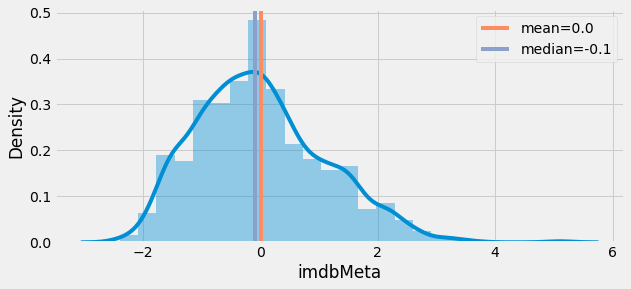

In [207]:
# imdbMeta distribution 
# imdbMeta - difference between imdbRating and Metascore (converted to 0 to 10)
plt.figure(figsize=(20,4))

plot_metaimdb = df_metaimdb['imdbMeta']

plt.subplot(1,2,1)
ax1 = sns.distplot(plot_metaimdb, kde_kws=dict(bw=0.2))
ax1.axvline(x=plot_metaimdb.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_metaimdb.mean(), 2)}")
ax1.axvline(x=plot_metaimdb.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_metaimdb.median(), 2)}")

plt.legend()
plt.show()

In [208]:
# Top differences between ratings
df_metaimdb.loc[abs(df_metaimdb['imdbMeta']).sort_values(ascending=False).index].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
250  Twin Peaks: Fire Walk with Me  1992   
193                       The Room  2003   
317                  The Gentlemen  2019   
829        Ghostbusters: Afterlife  2021   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
193                                     Drama         3.6     0.9       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7

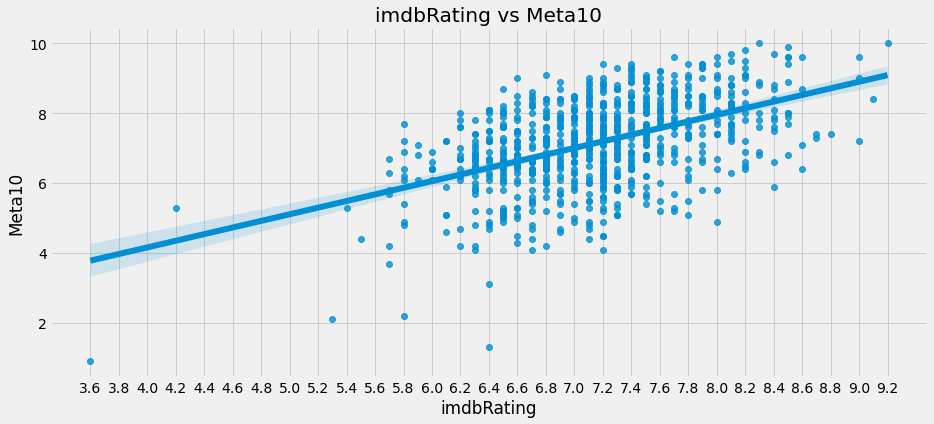

In [209]:
# Relationship between variables (all data)
xx = df_metaimdb['imdbRating']
yy = df_metaimdb['Meta10']

# Plot
# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
xticks = np.arange(xx.min(), xx.max()+0.1, step=0.2)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=xx, y=yy)
plt.xticks(xticks)

plt.title('imdbRating vs Meta10')
plt.show()

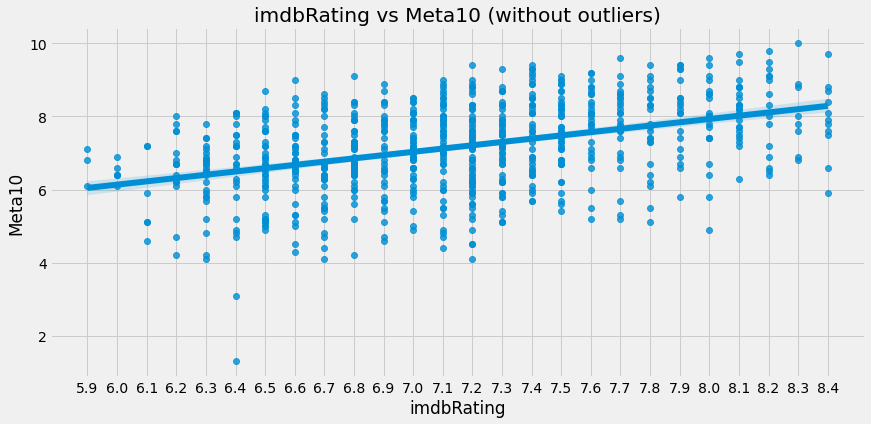

In [210]:
# Without outliers
df_metaimdb_out = df_metaimdb[np.abs(df_metaimdb['imdbRating'] - df_metaimdb['imdbRating'].mean()) 
                                <= (2*df_metaimdb['imdbRating'].std())] # 2 std

xx = df_metaimdb_out['imdbRating']
yy = df_metaimdb_out['Meta10']

# Plot
# https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
xticks = np.arange(xx.min(), xx.max()+0.1, step=0.1)
xsize = len(xticks) // 2

plt.figure(figsize=(xsize, 6))
sns.regplot(x=xx, y=yy)
plt.xticks(xticks)

plt.title('imdbRating vs Meta10 (without outliers)')
plt.show()

In [211]:
# better Metascore than imdbRating
print('Movies with better Metascore than imdbRating: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] < 0])))

Movies with better Metascore than imdbRating: 413


In [212]:
# Movies with better Metascore than imdbRating
df_metaimdb[df_metaimdb['imdbMeta'] < 0].nsmallest(N, 'imdbMeta', keep='all')

Title  Year  \
573            The Swerve  2018   
457                  Time  2020   
358                 Carol  2015   
369  The Duke of Burgundy  2014   
421             Nomadland  2020   
790  The Power of the Dog  2021   
895          Petite Maman  2021   
8               Lady Bird  2017   
487             High Life  2018   
505   Inside Llewyn Davis  2013   
629      The Green Knight  2021   
689         Winter's Bone  2010   

                                                 Genre  imdbRating  Meta10  \
573                            Drama, Horror, Thriller         6.6     9.0   
457                             Documentary, Biography         6.8     9.1   
358                                     Drama, Romance         7.2     9.4   
369                                     Drama, Romance         6.5     8.7   
421                                              Drama         7.3     9.3   
790                            Drama, Romance, Western         6.9     8.9   
895                                     Drama, Fantasy         7.4     9.4   
8                                        Comedy, Drama         7.4     9.3   
487  Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...         5.8     7.7   
505                               Comedy, Drama, Music         7.4     9.3   
629                          Adventure, Drama, Fantasy         6.6     8.5   
689                                     Drama, Mystery         7.1     9.0   

     imdbMeta  
573      -2.4  
457      -2.3  
358      -2.2  
369      -2.2  
421      -2.0  
790      -2.0  
895      -2.0  
8        -1.9  
487      -1.9  
505      -1.9  
629      -1.9  
689      -1.9

In [213]:
# negative imdbRating and positive Metascore 
print('Movies with negative imdbRating and positive Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbRating'] < 5][df_metaimdb['Meta10'] > 5])))

Movies with negative imdbRating and positive Metascore: 1


In [214]:
# better imdbRating than Metascore
print('Movies with better imdbRating than Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] > 0])))

Movies with better imdbRating than Metascore: 353


In [215]:
# Movies with better imdbRating than Metascore
df_metaimdb[df_metaimdb['imdbMeta'] > 0].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
193                       The Room  2003   
250  Twin Peaks: Fire Walk with Me  1992   
317                  The Gentlemen  2019   
829        Ghostbusters: Afterlife  2021   

                                        Genre  imdbRating  Meta10  imdbMeta  
612                    Crime, Drama, Thriller         6.4     1.3       5.1  
530                            Comedy, Horror         5.8     2.2       3.6  
312  Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                  Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                              Crime, Drama         7.2     4.1       3.1  
490                   Biography, Drama, Music         8.0     4.9       3.1  
193                                     Drama         3.6     0.9       2.7  
250          Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
317                     Action, Comedy, Crime         7.8     5.1       2.7  
829        Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7

In [216]:
# positive imdbRating and negative Metascore 
print('Movies with positive imdbRating and negative Metascore: ' + str(len(df_metaimdb[df_metaimdb['imdbRating'] > 5][df_metaimdb['Meta10'] < 5])))

Movies with positive imdbRating and negative Metascore: 38


In [217]:
# Movies with positive imdbRating and negative Metascore
df_metaimdb[df_metaimdb['imdbRating'] > 5][df_metaimdb['Meta10'] < 5].nlargest(N, 'imdbMeta', keep='all')

Title  Year  \
612                 Run Hide Fight  2020   
530   The Babysitter: Killer Queen  2020   
312             Charlie Countryman  2013   
169                       Geostorm  2017   
788               The Unforgivable  2021   
490              Bohemian Rhapsody  2018   
250  Twin Peaks: Fire Walk with Me  1992   
829        Ghostbusters: Afterlife  2021   
140                     The Jacket  2005   
445                           Stay  2005   

                                         Genre  imdbRating  Meta10  imdbMeta  
612                     Crime, Drama, Thriller         6.4     1.3       5.1  
530                             Comedy, Horror         5.8     2.2       3.6  
312   Action, Comedy, Drama, Romance, Thriller         6.4     3.1       3.3  
169                   Action, Sci-Fi, Thriller         5.3     2.1       3.2  
788                               Crime, Drama         7.2     4.1       3.1  
490                    Biography, Drama, Music         8.0     4.9       3.1  
250           Drama, Horror, Mystery, Thriller         7.2     4.5       2.7  
829         Adventure, Comedy, Fantasy, Sci-Fi         7.2     4.5       2.7  
140  Drama, Fantasy, Mystery, Sci-Fi, Thriller         7.1     4.4       2.7  
445                   Drama, Mystery, Thriller         6.7     4.1       2.6

In [218]:
# Matching rating
print('Movies with matching rating: ' + str(len(df_metaimdb[df_metaimdb['imdbMeta'] == 0])))

Movies with matching rating: 28


In [219]:
# Movies with matching rating (imdbRating = Meta10)
df_metaimdb[df_metaimdb['imdbMeta'] == 0]

Title  Year  \
56     Ant-Man and the Wasp  2018   
123            Run Lola Run  1998   
124              Layer Cake  2004   
133                  Primer  2004   
170                 Bronson  2008   
210                  Aliens  1986   
228          Ford v Ferrari  2019   
325                 Swallow  2019   
359                     Una  2016   
367    The Snowtown Murders  2011   
368     Journey to the West  2013   
398               Black Box  2020   
418          Corpus Christi  2019   
440                     Run  2020   
550        Army of the Dead  2021   
557  The Godfather: Part II  1974   
566          Public Enemies  2009   
579          Lady Vengeance  2005   
596              Inside Man  2006   
597             Black Widow  2021   
601    People Places Things  2015   
617       The Suicide Squad  2021   
635      Young Frankenstein  1974   
684    The Royal Tenenbaums  2001   
708                  Mirror  1975   
773                eXistenZ  1999   
777                   Drive  2011   
824             The Martian  2015   

                                           Genre  imdbRating  Meta10  imdbMeta  
56             Action, Adventure, Comedy, Sci-Fi         7.0     7.0       0.0  
123                       Crime, Drama, Thriller         7.7     7.7       0.0  
124               Action, Crime, Drama, Thriller         7.3     7.3       0.0  
133                      Drama, Sci-Fi, Thriller         6.8     6.8       0.0  
170              Action, Biography, Crime, Drama         7.1     7.1       0.0  
210          Action, Adventure, Sci-Fi, Thriller         8.4     8.4       0.0  
228              Action, Biography, Drama, Sport         8.1     8.1       0.0  
325                                        Drama         6.5     6.5       0.0  
359                                        Drama         6.2     6.2       0.0  
367                      Biography, Crime, Drama         6.6     6.6       0.0  
368  Action, Adventure, Comedy, Fantasy, Romance         6.8     6.8       0.0  
398            Horror, Mystery, Sci-Fi, Thriller         6.2     6.2       0.0  
418                                        Drama         7.7     7.7       0.0  
440                            Mystery, Thriller         6.7     6.7       0.0  
550      Action, Crime, Horror, Sci-Fi, Thriller         5.7     5.7       0.0  
557                                 Crime, Drama         9.0     9.0       0.0  
566     Action, Biography, Crime, Drama, History         7.0     7.0       0.0  
579                       Crime, Drama, Thriller         7.5     7.5       0.0  
596              Crime, Drama, Mystery, Thriller         7.6     7.6       0.0  
597                    Action, Adventure, Sci-Fi         6.7     6.7       0.0  
601                              Comedy, Romance         6.8     6.8       0.0  
617            Action, Adventure, Comedy, Sci-Fi         7.2     7.2       0.0  
635                                       Comedy         8.0     8.0       0.0  
684                                Comedy, Drama         7.6     7.6       0.0  
708                             Biography, Drama         8.0     8.0       0.0  
773            Horror, Mystery, Sci-Fi, Thriller         6.8     6.8       0.0  
777                                Action, Drama         7.8     7.8       0.0  
824                     Adventure, Drama, Sci-Fi         8.0     8.0       0.0

In [220]:
# Movies with most balanced reviews (minor difference between imdb and metascore rating), considering movies with a rating over the 75th quantile
df_best_movies = df_metaimdb[abs(df_metaimdb['imdbMeta']) < 1][df_metaimdb['imdbRating'] > df_metaimdb['imdbRating'].quantile(0.75)]
df_best_movies['imdbMeta'] = abs(df_best_movies['imdbMeta']).round(1)

show_all(df_best_movies.nsmallest(N, 'imdbMeta', keep='all').sort_values(['imdbRating','imdbMeta'], ascending=False))

In [221]:
# Top movies by total rating (imdbRating + Metascore*)
df_metaimdb['Rate20'] = df_metaimdb['imdbRating'] + df_metaimdb['Meta10']

df_metaimdb[df_metaimdb['Rate20'] > df_metaimdb['Rate20'].quantile(0.75)].nlargest(30, 'Rate20', keep='all')

Title  Year  \
249                                      The Godfather  1972   
743                                       12 Angry Men  1957   
806                                        City Lights  1931   
891                                 Lawrence of Arabia  1962   
62                                       Spirited Away  2001   
107                                           Parasite  2019   
673  Dr. Strangelove or: How I Learned to Stop Worr...  1964   
810                                       Modern Times  1936   
18                                     Pan's Labyrinth  2006   
557                             The Godfather: Part II  1974   
711                                     Apocalypse Now  1979   
811                                      The Third Man  1949   
480                                            Virunga  2014   
417                         Portrait of a Lady on Fire  2019   
622                                    Rosemary's Baby  1968   
34                                     The Dark Knight  2008   
722                                There Will Be Blood  2007   
192                                              Alien  1979   
714                                         La La Land  2016   
59                                                Roma  2018   
128                                     Marriage Story  2019   
760                                    Before Midnight  2013   
315                            They Shall Not Grow Old  2018   
377                             No Country for Old Men  2007   
787                                 Back to the Future  1985   
70                                         Shoplifters  2018   
182              Eternal Sunshine of the Spotless Mind  2004   
416                               Call Me by Your Name  2017   
853                                            Amadeus  1984   
58                                     The Truman Show  1998   
132                                       The Irishman  2019   

                                              Genre  imdbRating  Meta10  \
249                                    Crime, Drama         9.2    10.0   
743                                    Crime, Drama         9.0     9.6   
806                          Comedy, Drama, Romance         8.5     9.9   
891                Adventure, Biography, Drama, War         8.3    10.0   
62   Animation, Adventure, Family, Fantasy, Mystery         8.6     9.6   
107                         Comedy, Drama, Thriller         8.5     9.6   
673                                     Comedy, War         8.4     9.7   
810                          Comedy, Drama, Romance         8.5     9.6   
18                              Drama, Fantasy, War         8.2     9.8   
557                                    Crime, Drama         9.0     9.0   
711                             Drama, Mystery, War         8.5     9.4   
811                    Film-Noir, Mystery, Thriller         8.1     9.7   
480                                Documentary, War         8.2     9.5   
417                                  Drama, Romance         8.1     9.5   
622                                   Drama, Horror         8.0     9.6   
34                   Action, Crime, Drama, Thriller         9.1     8.4   
722                                           Drama         8.2     9.3   
192                                  Horror, Sci-Fi         8.5     8.9   
714          Comedy, Drama, Music, Musical, Romance         8.0     9.4   
59                                            Drama         7.7     9.6   
128                                  Drama, Romance         7.9     9.4   
760                                  Drama, Romance         7.9     9.4   
315                       Documentary, History, War         8.2     9.1   
377                          Crime, Drama, Thriller         8.2     9.1   
787                       Adventure, Comedy, Sci-Fi         8.6     8.7   
70                                     Crime, Dram

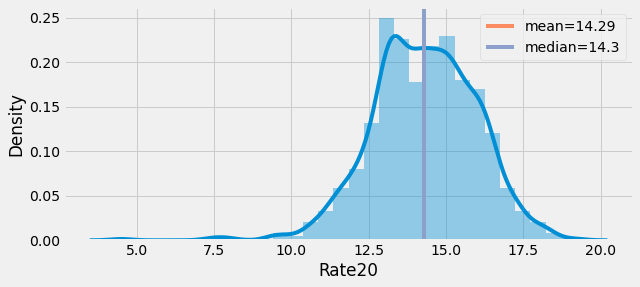

In [222]:
# Rate20 distribution 
plot_rate20 = df_metaimdb['Rate20']

# Plot Rate20
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_rate20, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_rate20.mean(), c=sns.color_palette("Set2")[1], label=f"mean={round(plot_rate20.mean(), 2)}")
ax1.axvline(x=plot_rate20.median(), c=sns.color_palette("Set2")[2], label=f"median={round(plot_rate20.median(), 2)}")
plt.legend();

### Weighted average rating

In [223]:
# https://www.datacamp.com/community/tutorials/recommender-systems-python

# WeightedRating (WR) = (v/v+m * R) + (m/v+m * C)

# v is the number of votes for the movie;
# m is the minimum votes required to be listed in the chart;
# R is the average rating of the movie;
# C is the mean vote across the whole report.

In [224]:
df_rating['imdbVotes'].describe()

count    8.940000e+02
mean     1.468344e+05
std      2.392185e+05
min      8.700000e+01
25%      1.769175e+04
50%      6.221750e+04
75%      1.775850e+05
max      2.524553e+06
Name: imdbVotes, dtype: float64

In [225]:
# Calculate mean of imdbRating column
C = df_rating['imdbRating'].mean()
print(C)

# Calculate the minimum number of votes required to be in the chart, m
m = df_rating['imdbVotes'].quantile(0.25).astype(int) # 50th percentile
print(m)

7.145190156599557
17691


In [226]:
# Filter out all qualified movies into a new DataFrame
q_movies = df_rating.copy().loc[df_rating['imdbVotes'] > m]
q_movies.shape

(670, 9)

In [227]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
#q_movies['Score'] = q_movies.apply(weighted_rating(q_movies, m, C), axis=1)
v = q_movies['imdbVotes']
R = q_movies['imdbRating']
q_movies['Score'] = weighted_rating(v, R, m, C)

# Top N
N = 10

#Print the top n movies based on score
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating', 'Score']
q_movies[cols].nlargest(N, 'Score', keep='all')

Title  Year  imdbVotes  imdbRating     Score
249           The Godfather  1972    1763879         9.2  9.179644
34          The Dark Knight  2008    2524553         9.1  9.086675
557  The Godfather: Part II  1974    1221218         9.0  8.973485
743            12 Angry Men  1957     756999         9.0  8.957474
289               Inception  2010    2249772         8.8  8.787341
750              The Matrix  1999    1845835         8.7  8.685408
795            Interstellar  2014    1707089         8.7  8.683764
787      Back to the Future  1985    1150655         8.6  8.577780
733  Léon: The Professional  1994    1117761         8.6  8.577007
62            Spirited Away  2001     723949         8.6  8.564857

In [228]:
# Without weighted average
cols = ['Title', 'Year', 'imdbVotes', 'imdbRating']

df_rating[cols].nlargest(N, 'imdbRating', keep='all')

Title  Year  imdbVotes  imdbRating
249                             The Godfather  1972    1763879         9.2
27                 Hans Zimmer Live in Prague  2017       2622         9.1
34                            The Dark Knight  2008    2524553         9.1
316  David Attenborough: A Life on Our Planet  2020      30944         9.0
557                    The Godfather: Part II  1974    1221218         9.0
743                              12 Angry Men  1957     756999         9.0
289                                 Inception  2010    2249772         8.8
750                                The Matrix  1999    1845835         8.7
795                              Interstellar  2014    1707089         8.7
62                              Spirited Away  2001     723949         8.6
733                    Léon: The Professional  1994    1117761         8.6
787                        Back to the Future  1985    1150655         8.6
889                   Spider-Man: No Way Home  2021     539929         8.6

## Votes

In [229]:
cols = ['Title', 'Year', 'Rated', 'Runtime', 'Genre', 'Director',
       'Writer', 'Language', 'Country', 'Metascore', 'imdbRating', 'imdbVotes', 'Production', 'Timestamp']

# Set votes dataframe
df_votes = df[cols].copy()

In [230]:
# imdbVotes statistics
df_votes['imdbVotes'].describe()

count    8.940000e+02
mean     1.468344e+05
std      2.392185e+05
min      8.700000e+01
25%      1.769175e+04
50%      6.221750e+04
75%      1.775850e+05
max      2.524553e+06
Name: imdbVotes, dtype: float64

In [231]:
# Movies with most imdbVotes
N = 10
df_votes.nlargest(N, 'imdbVotes', keep='all')

Title  Year  Rated  Runtime  \
34          The Dark Knight  2008  PG-13      152   
289               Inception  2010  PG-13      148   
750              The Matrix  1999      R      136   
249           The Godfather  1972      R      175   
795            Interstellar  2014  PG-13      169   
557  The Godfather: Part II  1974      R      202   
778                 Memento  2000      R      113   
106                   Joker  2019      R      122   
787      Back to the Future  1985     PG      116   
733  Léon: The Professional  1994      R      110   

                                   Genre                         Director  \
34        Action, Crime, Drama, Thriller                Christopher Nolan   
289  Action, Adventure, Sci-Fi, Thriller                Christopher Nolan   
750                       Action, Sci-Fi  Lana Wachowski, Lilly Wachowski   
249                         Crime, Drama             Francis Ford Coppola   
795             Adventure, Drama, Sci-Fi                Christopher Nolan   
557                         Crime, Drama             Francis Ford Coppola   
778                    Mystery, Thriller                Christopher Nolan   
106               Crime, Drama, Thriller                    Todd Phillips   
787            Adventure, Comedy, Sci-Fi                  Robert Zemeckis   
733       Action, Crime, Drama, Thriller                       Luc Besson   

                                                Writer  \
34   Bob Kane, Jonathan Nolan, Christopher Nolan, D...   
289                                  Christopher Nolan   
750                    Lilly Wachowski, Lana Wachowski   
249                   Francis Ford Coppola, Mario Puzo   
795                  Jonathan Nolan, Christopher Nolan   
557                   Francis Ford Coppola, Mario Puzo   
778                  Jonathan Nolan, Christopher Nolan   
106  Bob Kane, Todd Phillips, Jerry Robinson, Scott...   
787                          Robert Zemeckis, Bob Gale   
733                                         Luc Besson   

                                       Language  \
34                            English, Mandarin   
289                   English, Japanese, French   
750                                     English   
249                     English, Italian, Latin   
795                                     English   
557  English, Italian, Spanish, Latin, Sicilian   
778                                     English   
106                                     English   
787                                     English   
733                    English, Italian, French   

                                   Country  Metascore  imdbRating  imdbVotes  \
34           United States, United Kingdom         84         9.1    2524553   
289          United States, United Kingdom         74         8.8    2249772   
750               United States, Australia         73         8.7    1845835   
249                          United States        100         9.2    1763879   
795  United States, United Kingdom, Canada         74         8.7    1707089   
557                          United States         90         9.0    1221218   
778                          United States         80         8.5    1199532   
106                  United States, Canada         59         8.4    1164846   
787                          United States         87         8.6    1150655   
733                  France, United States         64         8.6    1117761   

                                            Production           Timestamp  
34   Warner Bros., Legendary Entertainment, Syncopy... 2018-05-31 22:36:06  
289     Warner Bros., Legendary Entertainment, Syncopy 2020-08-27 23:51:02  
750  Warner Bros., Village Roadshow Pictures, Grouc... 2021-11-26 23:17:48  
249             Paramount Pictures, Alfran Productions 2020-06-07 19:42:43  
795  Paramount Pictures, Warner Bros., Legendary En... 2022-01-01 00:52:28  
557  Paramount Pictures, The Coppola Company, 

In [232]:
# Movies with fewer imdbVotes
# filter out documentaries
df_votes[~df_votes['Genre'].str.contains('Documentary')].nsmallest(N, 'imdbVotes', keep='all')

Title  Year      Rated  Runtime  \
491       Hero on the Front  2018        N/A       85   
547         Bad Investigate  2018        N/A      120   
816                  Holler  2020          R       90   
761                PVT CHAT  2020    Unrated       86   
568                     Joy  2018      TV-MA       99   
573              The Swerve  2018        N/A       95   
779            Running Time  1997        N/A       70   
401                  Listen  2020        N/A       73   
878  Nothing Bad Can Happen  2013  Not Rated      110   
414                 Patrick  2019        N/A       97   

                                               Genre  \
491                          Biography, History, War   
547  Action, Comedy, Crime, Drama, Mystery, Thriller   
816                                            Drama   
761                                            Drama   
568                                            Drama   
573                          Drama, Horror, Thriller   
779                                  Crime, Thriller   
401                                            Drama   
878                   Crime, Drama, Horror, Thriller   
414                           Comedy, Drama, Mystery   

                                        Director  \
491  Gonçalo Galvão Teles, Jorge Paixão da Costa   
547                                  Luis Ismael   
816                                Nicole Riegel   
761                                    Ben Hozie   
568                             Sudabeh Mortezai   
573                                Dean Kapsalis   
779                                  Josh Becker   
401                                    Ana Rocha   
878                                 Katrin Gebbe   
414                                 Tim Mielants   

                                               Writer  \
491           Mário Botequilha, Jorge Paixão da Costa   
547           Dinis Santos, Daniel Costa, Luis Ismael   
816                                     Nicole Riegel   
761                                         Ben Hozie   
568                                  Sudabeh Mortezai   
573                                     Dean Kapsalis   
779                           Peter Choi, Josh Becker   
401  Ana Rocha, Aaron Brookner, Paula Alvarez Vaccaro   
878                                      Katrin Gebbe   
414                  Tim Mielants, Benjamin Sprengers   

                                    Language                   Country  \
491                               Portuguese                  Portugal   
547   Galician, Portuguese, English, Spanish                  Portugal   
816                                  English             United States   
761                                  English             United States   
568                          English, German                   Austria   
573                                  English             United States   
779                                  English             United States   
401                      English, Portuguese  Portugal, United Kingdom   
878                                   German                   Germany   
414  Dutch, French, English, German, Flemish      Belgium, Netherlands   

     Metascore  imdbRating  imdbVotes  \
491          0         6.3        676   
547          0         6.6        712   
816         76         6.2       1173   
761         61         5.8       1213   
568         75         6.6       1293   
573         90         6.6       1314   
779          0         6.8       1548   
401          0         7.0       1667   
878         51         6.9       1678   
414         73         6.8       1760   

                                            Production           Timestamp  
491                         Ukbar Filmes, Ukbar Filmes 2021-03-27 23:17:52  
547                                    Lightbox Filmes 2021-05-18 23:39:27  
816  Hunting Lane Films, Feigco Entertainment, Leve... 2022-01-11 23:42:03  
7

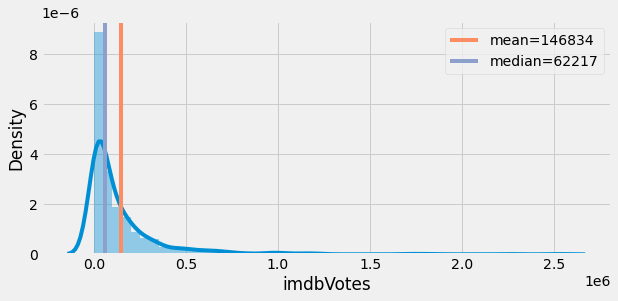

In [233]:
# imdbVotes distribution 
plot_votes = df_votes['imdbVotes']

# Plot imdbVotes
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
ax1 = sns.distplot(plot_votes, kde_kws=dict(bw=0.2))

ax1.axvline(x=plot_votes.mean(), c=sns.color_palette("Set2")[1], label=f"mean={int(plot_votes.mean())}")
ax1.axvline(x=plot_votes.median(), c=sns.color_palette("Set2")[2], label=f"median={int(plot_votes.median())}")
plt.legend();

In [234]:
# https://en.wikipedia.org/wiki/Kurtosis
# Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. 
df_rating.imdbVotes.kurtosis()

26.511024763364656

## Production Companies

In [235]:
cols = ['Title', 'Year', 'Rated', 'Genre', 'Director', 'Language', 'Country', 'imdbRating', 'Production', 'Timestamp']

# Set production dataframe
df_production = df[cols].copy()

In [236]:
# Number of production companies
len(counter_display(df_production, 'Production', 'Title', None).index)

2500

In [237]:
# Production / ratings
df_production_rating = get_mean_value(df_production, 'Production', 'imdbRating')

In [238]:
# Top producton companies 
N = 20

show_all(df_production_rating.nlargest(N, 'Total', keep='all').style.background_gradient(subset=['imdbRating']).set_precision(2))

In [239]:
# Production compnaies with highest imdbRating average
show_all(df_production_rating[df_production_rating['Total'] > 2].nlargest(N, 'imdbRating', keep='all'))

In [240]:
# Search by production company
prod_company = 'Wild Bunch'
show_all(pd.DataFrame(df_production_rating.loc[prod_company]).T)

In [241]:
# Common Production pairing
df_production_pairs = pairing(df_production, 'Production')

# Show top pairs
N = 20
show_all(df_production_pairs.nlargest(N, 'Count', keep='all'))

In [242]:
# Production / Director
df_production_director = df_production.copy()

gb_production_director_pair = double_group_info(df_production_director, 'Production', 'Director')
show_all(gb_production_director_pair)

In [243]:
# Production / Country
df_production_country = df_production.copy()

gb_production_country_pair = double_group_info(df_production_country, 'Production', 'Country')
show_all(gb_production_country_pair)